# Comparison Of Models For Multi Target Detection In Heavy Tailed Clutter

## Imports

In [6]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset


In [4]:
# os.environ["#wandb_NOTEBOOK_NAME"] = "compare.ipynb"
# #wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
# #wandb.init(project="Diffusion-for-radar", mode="online")

## dataset

In [5]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 3, random_n_targets=False, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        # If nu is provided, fix it; otherwise clutter nu will be drawn uniformly in [0.1, 1.5]
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # Clutter-to-noise ratio in dB

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3     # Range resolution in m
        self.dv = 0.249 # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float))

        # Precompute the range steering matrix (matched filter in range)
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N, dtype=torch.float)
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target

        # Scale the target signature to achieve the desired SCNR (in dB)
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
        return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)
        p, q = torch.meshgrid(torch.arange(self.N, dtype=torch.float),
                              torch.arange(self.K, dtype=torch.float), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z

        # Impart heavy–tailed behavior via Gamma modulation (shape and scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation using a range–steering operation.
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N, dtype=torch.float), self.R) *
                                (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate noise (complex Gaussian)
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / 
             torch.sqrt(torch.tensor(2.0 * self.sigma2)))
        # Generate clutter; if self.nu is not set, choose nu uniformly in [0.1, 1.5]
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label map
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            # If not random, use fixed number of targets.
            n = torch.randint(1, self.n_targets + 1, (1,)).item() if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1
        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S + C + W
        IQ_map = X
        # Range matched filtering using the precomputed steering matrix.
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S

        # Apply an FFT along slow–time, fftshift and flip to obtain the range–Doppler (RD) map.
        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        clean_RD_map = S_RD.flip(dims=[1])
        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)
        RD_map = X_RD.flip(dims=[1])
        return S, C, IQ_map, clean_RD_map, RD_map, rd_label


### Visualization functions

In [6]:
def visualize_sample(dataset, sample_index: int = 0):

    S, C, IQ_map, clean_RD_map, RD_map, RD_label = dataset[sample_index]

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 6, 1)
    plt.imshow(torch.real(S), aspect='auto', cmap='viridis')
    plt.title("Real S", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 2)
    plt.imshow(torch.imag(S), aspect='auto', cmap='viridis')
    plt.title("Imag S", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 3)
    plt.imshow(torch.real(C), aspect='auto', cmap='viridis')
    plt.title("Real C", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 4)
    plt.imshow(torch.imag(C), aspect='auto', cmap='viridis')
    plt.title("Imag C", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 5)
    plt.imshow(torch.real(IQ_map), aspect='auto', cmap='viridis')
    plt.title("Real IQ map", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 6)
    plt.imshow(torch.imag(IQ_map), aspect='auto', cmap='viridis')
    plt.title("Imag IQ map", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(torch.real(RD_map), aspect='auto', cmap='viridis')
    plt.title("Real RD", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1, 5, 2)
    plt.imshow(torch.imag(RD_map), aspect='auto', cmap='viridis')
    plt.title("Imag RD", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1, 5, 3)
    plt.imshow(torch.abs(RD_map), aspect='auto', cmap='viridis')
    plt.title("RD Map (abs)", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1, 5, 4)
    plt.imshow(torch.abs(clean_RD_map), aspect='auto', cmap='viridis')
    plt.title("clean RD Map (abs)", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1, 5, 5)
    plt.imshow(RD_label, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Label", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.tight_layout()
    plt.show()


In [7]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=1,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )

            S, C, IQ_map, clean_RD_map, RD_map, RD_label = dataset[0]

            rd_magnitude = torch.abs(RD_map)
            rd_db = 20 * torch.log10(rd_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(rd_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            _, C_sample, W_sample, _ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # 2) Now plot a SECOND figure comparing all nu's at once
    # -----------------------------------------------------
    plt.figure(figsize=(8, 6))

    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


### Define datasets and dataloaders

In [8]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

### Visualize a sample from the dataset

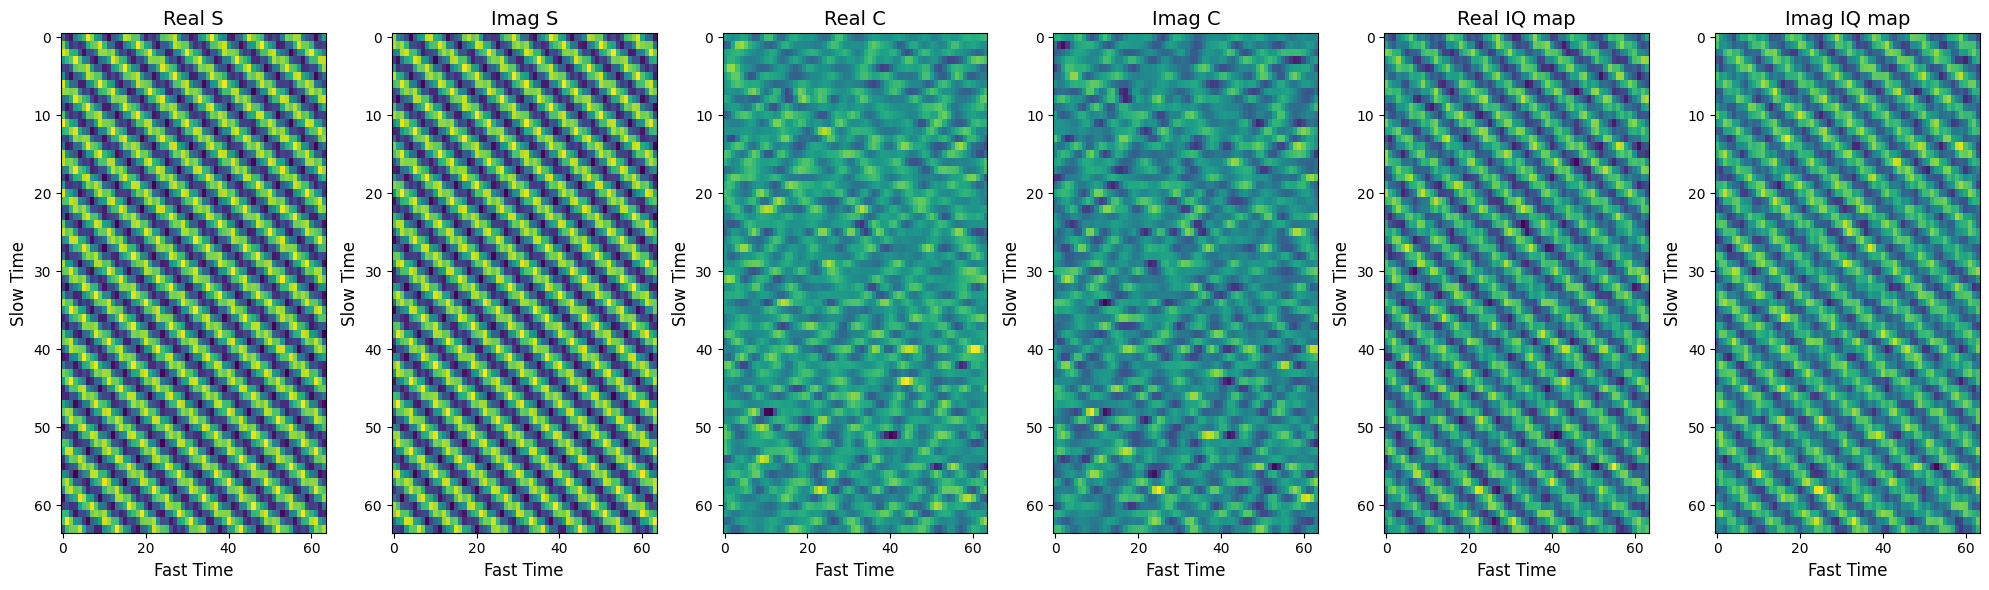

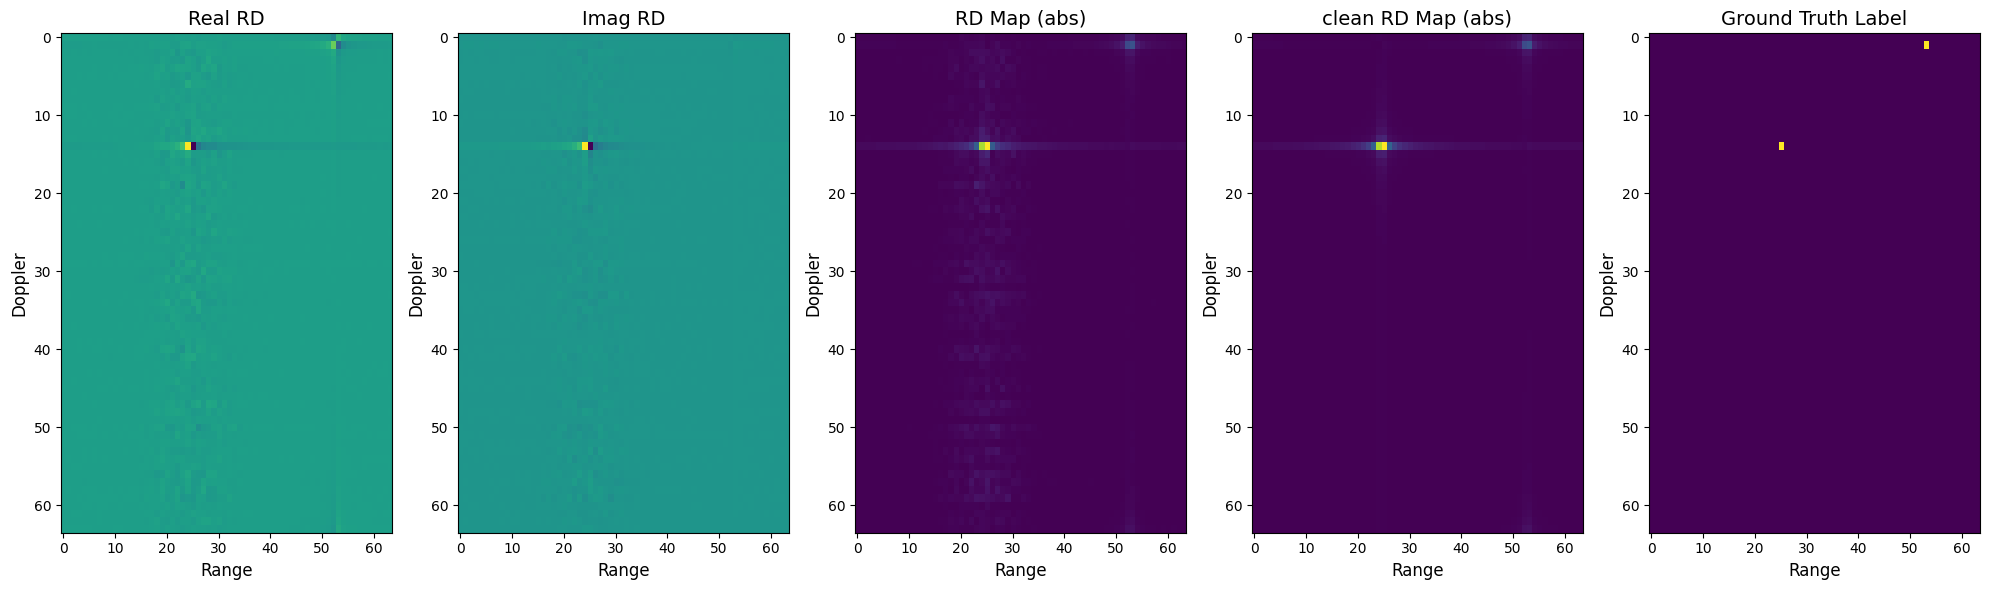

In [10]:
visualize_sample(train_dataset_with_targets, sample_index=1)

### View different values of SCNR & nu

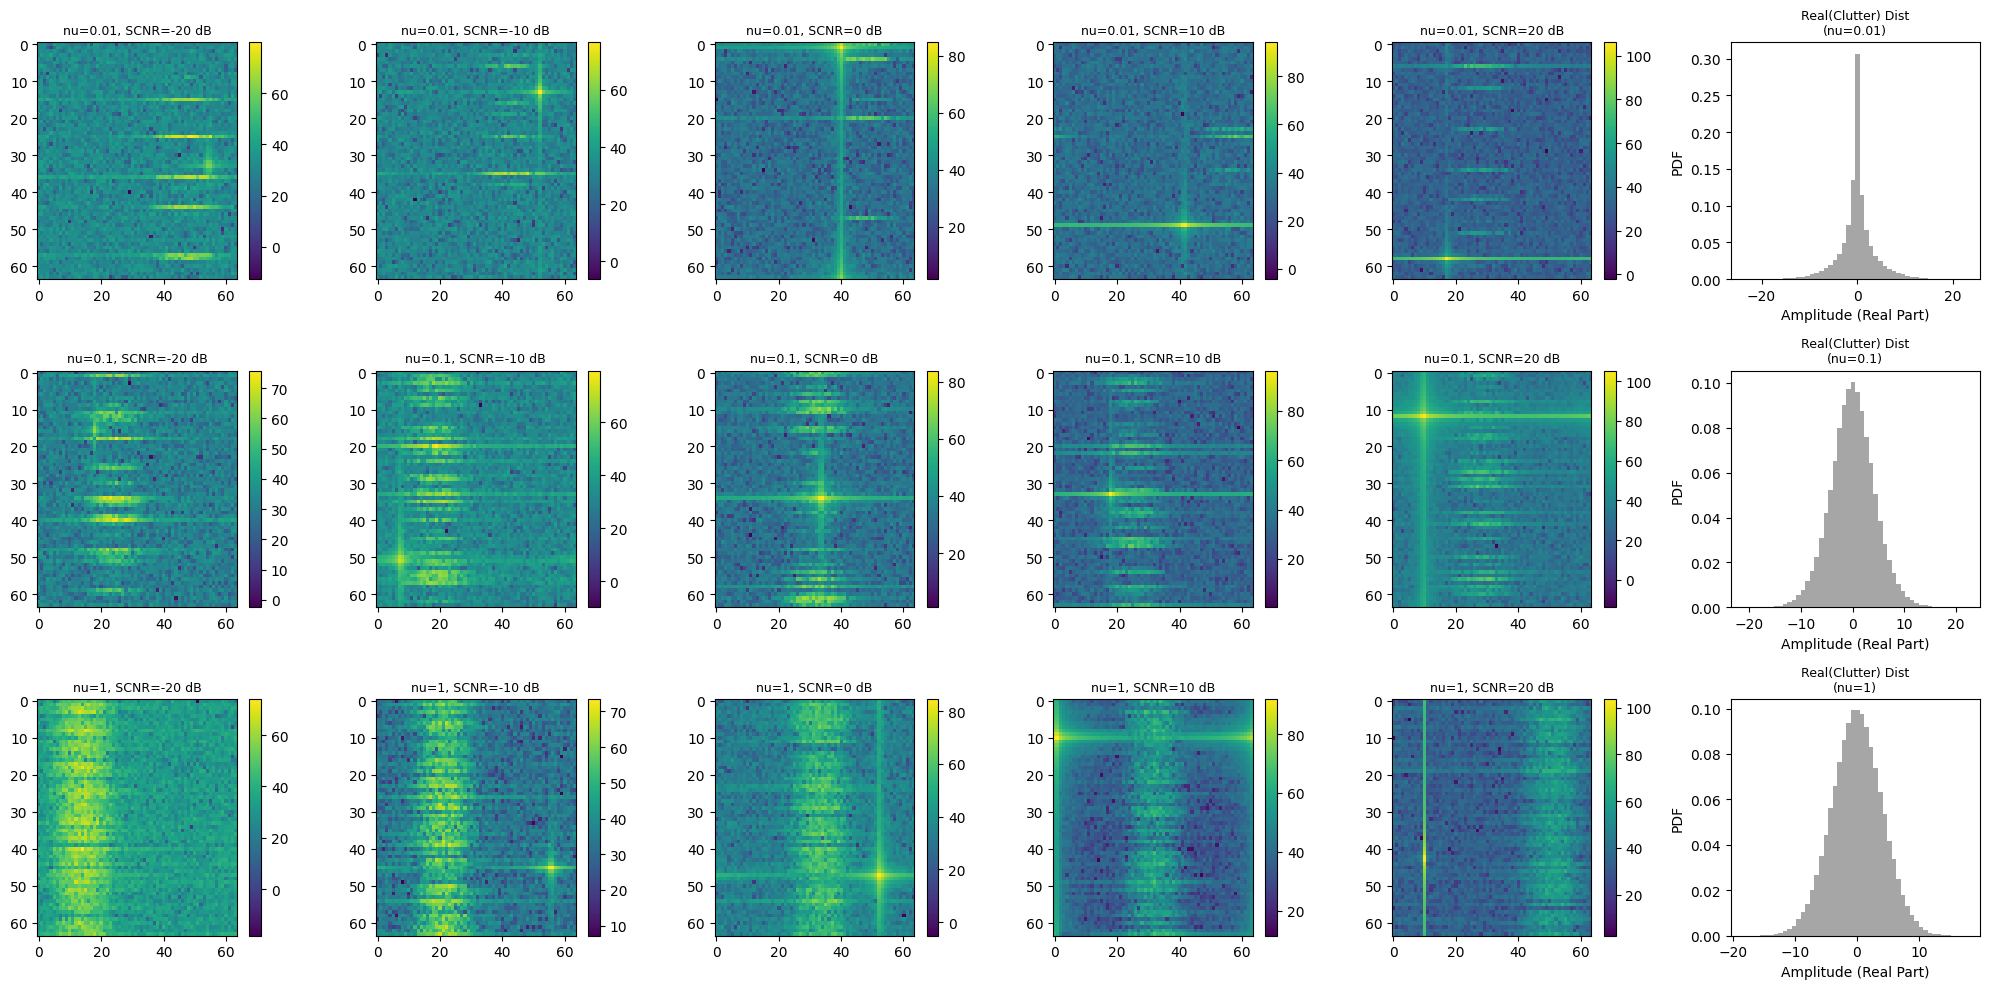

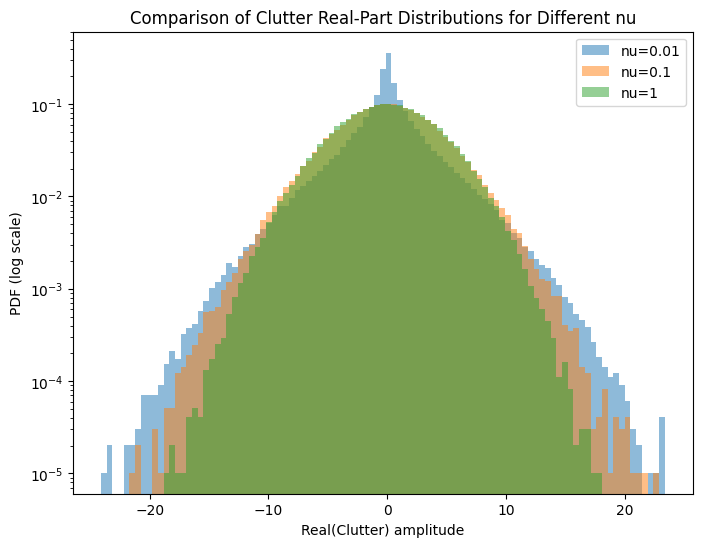

In [11]:
compare_nu_scnr(
    nu_values=[0.01, 0.1, 1],
    scnr_values=[-20, -10, 0, 10, 20],
    radar_dataset_class=RadarDataset
)

## CFAR

In [12]:
def ca_cfar_2d(signal, num_train, num_guard, Pfa):
    """
    Standard CA–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Scaling factor for exponential noise
    alpha = num_training_cells * (Pfa**(-1/num_training_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            noise_level = np.mean(training_cells)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map

def tm_cfar_2d(signal, num_train, num_guard, trim_ratio, Pfa):
    """
    TM–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Number of cells to trim from each end
    trim_cells = int(trim_ratio * num_training_cells)
    effective_cells = num_training_cells - 2 * trim_cells
    if effective_cells <= 0:
        effective_cells = num_training_cells  # fallback
    alpha = effective_cells * (Pfa**(-1/effective_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            sorted_cells = np.sort(training_cells)
            if 2 * trim_cells < num_training_cells:
                trimmed = sorted_cells[trim_cells: num_training_cells - trim_cells]
            else:
                trimmed = sorted_cells
            noise_level = np.mean(trimmed)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map


In [13]:
def simulate_cfar_performance(cfar_func, specified_Pfa, nu_val, num_trials=100,
                              n_targets=3, random_n_targets=False, **cfar_kwargs):
    """
    For a given CFAR function, specified false–alarm parameter, and clutter nu,
    simulate num_trials frames and compute the average probability of detection (Pd)
    and measured probability of false alarm (Pfa_meas).
    """
    dataset = RadarDataset(num_samples=num_trials, n_targets=n_targets,
                           random_n_targets=random_n_targets, nu=nu_val)
    total_true_detections = 0
    total_targets = 0
    total_false_alarms = 0
    total_non_target_cells = 0
    for i in range(num_trials):
        _, _, _, _, RD_map, rd_label = dataset[i]
        RD_mag = torch.abs(RD_map).detach().numpy()
        detection_map = cfar_func(RD_mag, **cfar_kwargs, Pfa=specified_Pfa)
        gt = rd_label.detach().numpy()
        true_detections = np.sum((detection_map == 1) & (gt == 1))
        false_alarms = np.sum((detection_map == 1) & (gt == 0))
        total_targets += np.sum(gt)
        total_true_detections += true_detections
        total_false_alarms += false_alarms
        total_non_target_cells += (gt.size - np.sum(gt))
    pd_rate = total_true_detections / total_targets if total_targets > 0 else 0
    measured_pfa = total_false_alarms / total_non_target_cells if total_non_target_cells > 0 else 0
    return pd_rate, measured_pfa

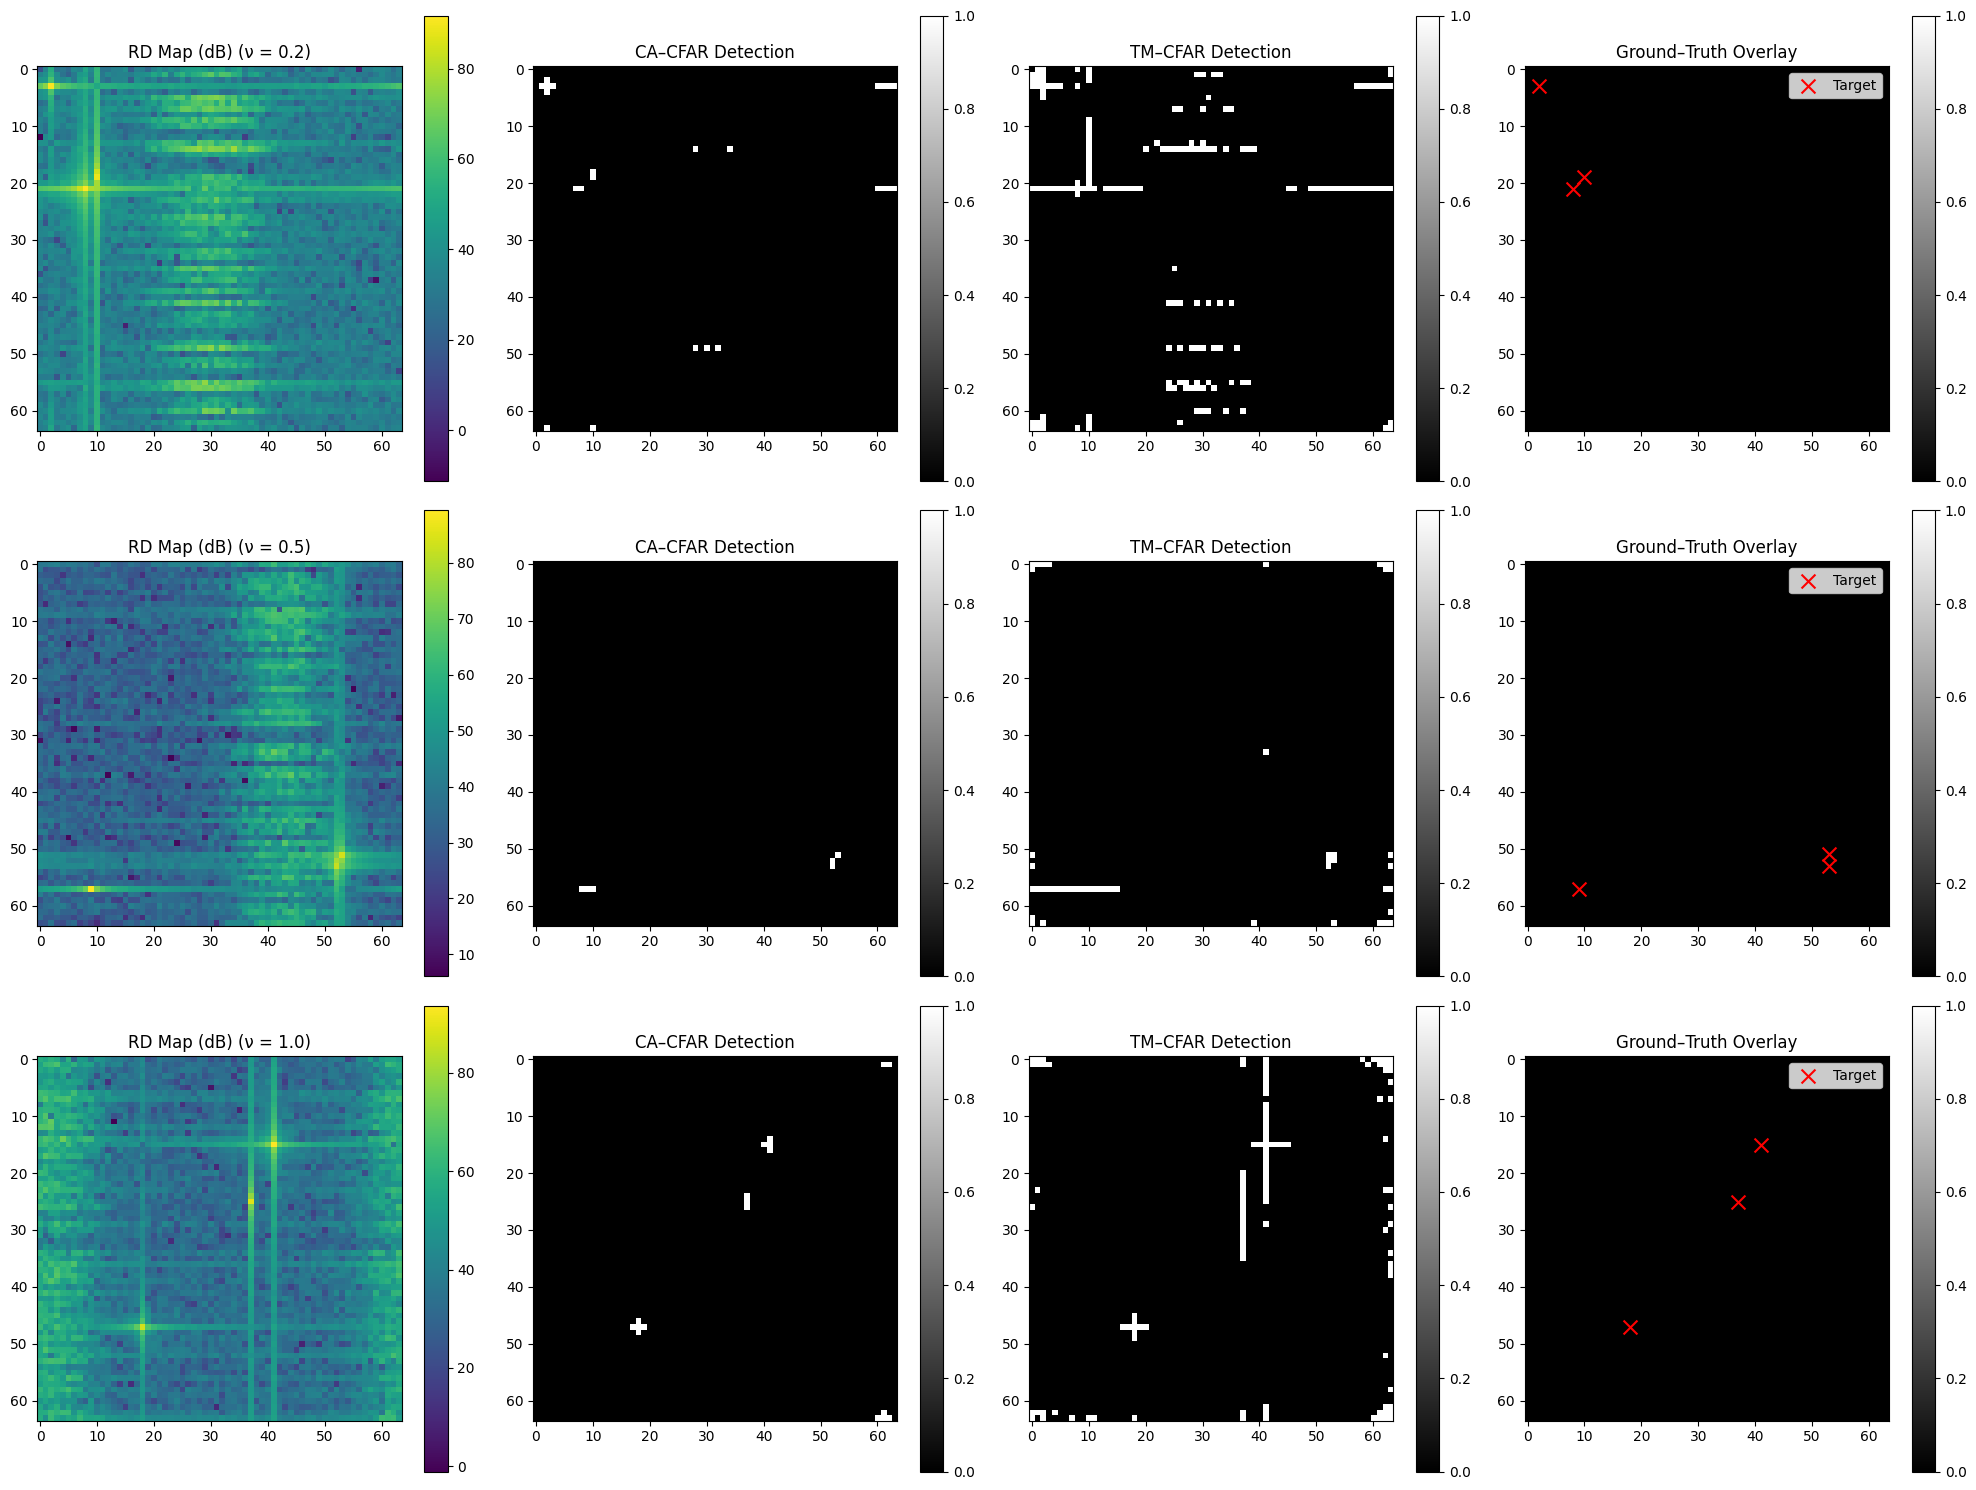

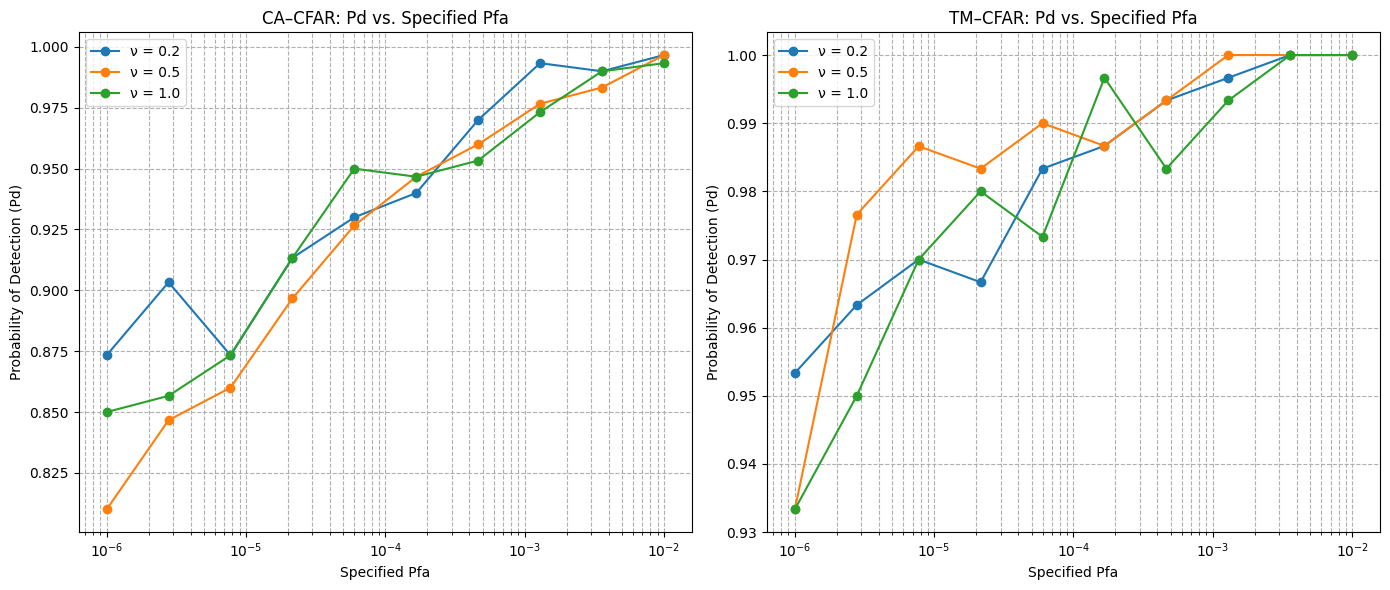

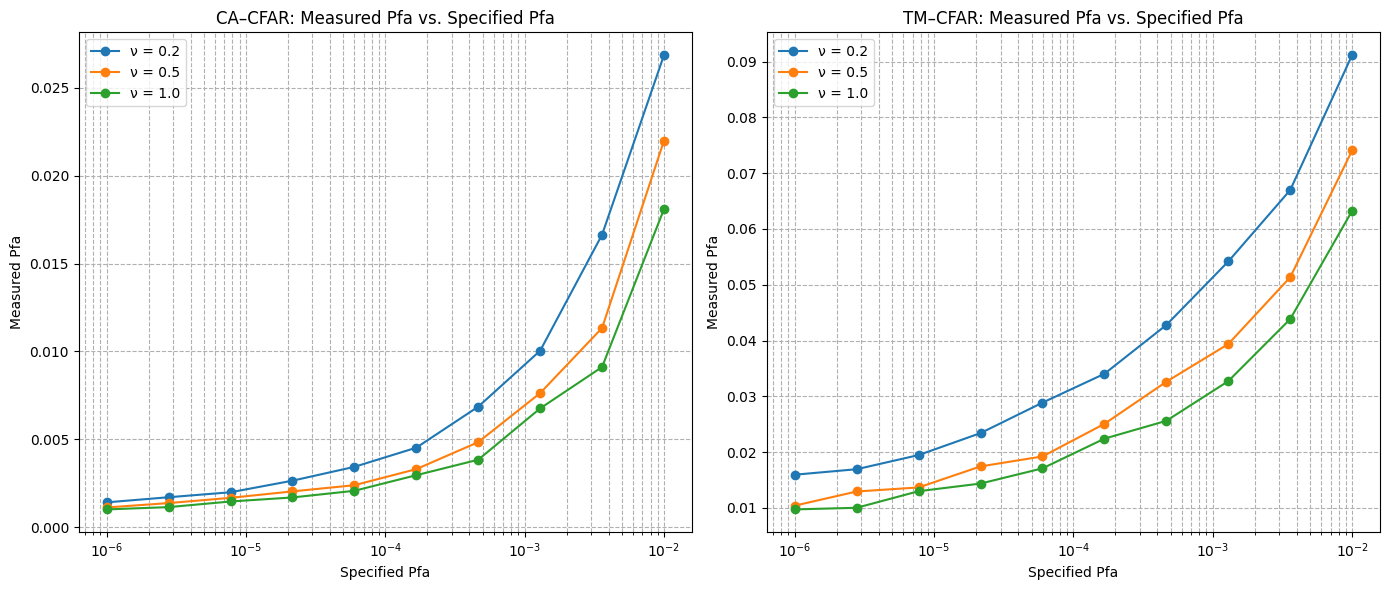

In [14]:
if __name__ == '__main__':
    torch.manual_seed(0)
    np.random.seed(0)

    # ------------------------------
    # Part 1: Single–frame Demo and Ground–Truth Overlay
    # ------------------------------
    # Use three clutter “spikiness” (ν) values for demonstration.
    nu_values = [0.2, 0.5, 1.0]
    num_train = 4       # training cells per side
    num_guard = 1       # guard cells per side
    trim_ratio = 0.25   # for TM–CFAR
    demo_Pfa = 1e-4     # chosen false–alarm parameter for the demo

    # For demonstration, we will generate one frame per ν value and show:
    # (a) the RD map (in dB),
    # (b) the CA–CFAR detection map,
    # (c) the TM–CFAR detection map,
    # (d) an overlay of the ground–truth target positions on the RD map.
    fig_demo, axs_demo = plt.subplots(len(nu_values), 4, figsize=(20, 5 * len(nu_values)))
    for idx, nu_val in enumerate(nu_values):
        dataset = RadarDataset(num_samples=1, n_targets=3, random_n_targets=False, nu=nu_val)
        S, C, IQ_map, clean_RD_map, RD_map, rd_label = dataset[0]
        RD_map_mag = torch.abs(RD_map).detach().numpy()
        gt = rd_label.detach().numpy()
        # Apply CFAR detectors with the demo_Pfa:
        ca_detection = ca_cfar_2d(RD_map_mag, num_train, num_guard, demo_Pfa)
        tm_detection = tm_cfar_2d(RD_map_mag, num_train, num_guard, trim_ratio, demo_Pfa)
        
        # (a) RD map in dB
        im0 = axs_demo[idx, 0].imshow(20 * np.log10(RD_map_mag + 1e-12), cmap='viridis')
        axs_demo[idx, 0].set_title(f'RD Map (dB) (ν = {nu_val})')
        fig_demo.colorbar(im0, ax=axs_demo[idx, 0])
        
        # (b) CA–CFAR detection map
        im1 = axs_demo[idx, 1].imshow(ca_detection, cmap='gray')
        axs_demo[idx, 1].set_title('CA–CFAR Detection')
        fig_demo.colorbar(im1, ax=axs_demo[idx, 1])
        
        # (c) TM–CFAR detection map
        im2 = axs_demo[idx, 2].imshow(tm_detection, cmap='gray')
        axs_demo[idx, 2].set_title('TM–CFAR Detection')
        fig_demo.colorbar(im2, ax=axs_demo[idx, 2])
        
        # (d) Overlay ground–truth targets on the RD map.
        axs_demo[idx, 3].imshow(0*20 * np.log10(RD_map_mag + 1e-12), cmap='gray')
        # Find indices where ground–truth label equals 1
        r_inds, d_inds = np.where(gt == 1)
        axs_demo[idx, 3].scatter(d_inds, r_inds, marker='x', color='red', s=100, label='Target')
        axs_demo[idx, 3].set_title('Ground–Truth Overlay')
        fig_demo.colorbar(im2, ax=axs_demo[idx, 3])
        axs_demo[idx, 3].legend()
    plt.tight_layout()
    plt.show()
    
    # ------------------------------
    # Part 2: Monte Carlo Simulation to Plot ROC Curves (Pd vs Pfa)
    # ------------------------------
    # We sweep over a range of specified Pfa values (for threshold setting)
    pfa_values = np.logspace(-6, -2, num=10)
    num_trials = 100  # number of Monte Carlo trials per point
    # For each CFAR method and for each nu, we store the resulting Pd and the measured Pfa.
    # (We use fixed n_targets=3 and random_n_targets=False to have reproducible ground truth.)
    results_ca = {nu: {'Pd': [], 'Pfa_meas': []} for nu in nu_values}
    results_tm = {nu: {'Pd': [], 'Pfa_meas': []} for nu in nu_values}

    for nu_val in nu_values:
        for pfa in pfa_values:
            # CA–CFAR simulation:
            pd_ca, pfa_meas_ca = simulate_cfar_performance(ca_cfar_2d, pfa, nu_val, num_trials=num_trials,
                                                            n_targets=3, random_n_targets=False,
                                                            num_train=num_train, num_guard=num_guard)
            results_ca[nu_val]['Pd'].append(pd_ca)
            results_ca[nu_val]['Pfa_meas'].append(pfa_meas_ca)
            # TM–CFAR simulation:
            pd_tm, pfa_meas_tm = simulate_cfar_performance(tm_cfar_2d, pfa, nu_val, num_trials=num_trials,
                                                            n_targets=3, random_n_targets=False,
                                                            num_train=num_train, num_guard=num_guard,
                                                            trim_ratio=trim_ratio)
            results_tm[nu_val]['Pd'].append(pd_tm)
            results_tm[nu_val]['Pfa_meas'].append(pfa_meas_tm)
    
    # Plot ROC curves: Pd vs. specified Pfa (x-axis, log-scale)
    fig_roc, axs_roc = plt.subplots(1, 2, figsize=(14, 6))
    
    # CA–CFAR ROC plot:
    for nu_val in nu_values:
        axs_roc[0].plot(pfa_values, results_ca[nu_val]['Pd'], marker='o', label=f'ν = {nu_val}')
    axs_roc[0].set_xscale('log')
    axs_roc[0].set_xlabel('Specified Pfa')
    axs_roc[0].set_ylabel('Probability of Detection (Pd)')
    axs_roc[0].set_title('CA–CFAR: Pd vs. Specified Pfa')
    axs_roc[0].grid(True, which='both', ls='--')
    axs_roc[0].legend()
    
    # TM–CFAR ROC plot:
    for nu_val in nu_values:
        axs_roc[1].plot(pfa_values, results_tm[nu_val]['Pd'], marker='o', label=f'ν = {nu_val}')
    axs_roc[1].set_xscale('log')
    axs_roc[1].set_xlabel('Specified Pfa')
    axs_roc[1].set_ylabel('Probability of Detection (Pd)')
    axs_roc[1].set_title('TM–CFAR: Pd vs. Specified Pfa')
    axs_roc[1].grid(True, which='both', ls='--')
    axs_roc[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Optionally, you can also plot the measured Pfa (averaged over Monte Carlo runs)
    fig_pfa, axs_pfa = plt.subplots(1, 2, figsize=(14, 6))
    for nu_val in nu_values:
        axs_pfa[0].plot(pfa_values, results_ca[nu_val]['Pfa_meas'], marker='o', label=f'ν = {nu_val}')
    axs_pfa[0].set_xscale('log')
    axs_pfa[0].set_xlabel('Specified Pfa')
    axs_pfa[0].set_ylabel('Measured Pfa')
    axs_pfa[0].set_title('CA–CFAR: Measured Pfa vs. Specified Pfa')
    axs_pfa[0].grid(True, which='both', ls='--')
    axs_pfa[0].legend()

    for nu_val in nu_values:
        axs_pfa[1].plot(pfa_values, results_tm[nu_val]['Pfa_meas'], marker='o', label=f'ν = {nu_val}')
    axs_pfa[1].set_xscale('log')
    axs_pfa[1].set_xlabel('Specified Pfa')
    axs_pfa[1].set_ylabel('Measured Pfa')
    axs_pfa[1].set_title('TM–CFAR: Measured Pfa vs. Specified Pfa')
    axs_pfa[1].grid(True, which='both', ls='--')
    axs_pfa[1].legend()

    plt.tight_layout()
    plt.show()


## DAFC

In [15]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

In [16]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range", map_type: str = "IQ"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        if map_type == "IQ":
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)
        else: # RD
            if detection_type == "range":
                self.input_dim = (64, 128)  # (K, 2*N)
            else:  # doppler
                self.input_dim = (64, 128)  # (N, 2*K)

        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


In [17]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [18]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, _, rd_label in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [19]:
def plot_training_history(history: dict, detection_type: str, map_type: str):
    """Plot and save training history for a given detector type.

    Parameters
    ----------
    history : dict
        A dictionary containing keys "train_loss", "val_loss", 
        "train_accuracy", and "val_accuracy", each mapping to a list 
        of values recorded per epoch.
    detection_type : str
        A string indicating the type/category of the detector 
        (e.g., 'Target', 'Object', 'Clutter').
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Define a style
    #plt.style.use('seaborn')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    if map_type == "RD":
        plt.savefig(f"{detection_type}_RD_training_history.png", dpi=300)
    else:
        plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


In [20]:
def train_model(model, criterion, train_loader, val_loader, detection_type, map_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    """
    Train range or Doppler detector

    Args:
        model: Neural network model
        criterion: Loss function
        train_loader: Training data loader
        val_loader: Validation data loader
        detection_type: "range" or "doppler"
        map_type: "IQ" or "RD"
        epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer
    """

    # Initialize #wandb
    #wandb.init(
    #     project="radar_detection",  # replace with your project name
    #     name=f"{detection_type}_{map_type}_run",
    #     config={
    #         "detection_type": detection_type,
    #         "map_type": map_type,
    #         "epochs": epochs,
    #         "learning_rate": learning_rate,
    #         "weight_decay": weight_decay,
    #         "optimizer": "Adam"
    #     },
    #     tags=[detection_type, map_type]
    # )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    # Check the last computed learning rate
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    if map_type == "IQ":
        print('Training IQ network')
        for epoch in epoch_pbar:
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for _, _, X, _, _, rd_label in train_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                # Forward pass
                outputs = model(X)
                loss = criterion(outputs, label)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = (outputs > 0.5).float()
                train_correct += (predictions == label).float().sum().item()
                train_total += label.numel()

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for _, _, X, _, _, rd_label in val_loader:
                    X = X.to(device)
                    rd_label = rd_label.to(device)

                    # Preprocess input and get 1D label
                    label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                    outputs = model(X)
                    loss = criterion(outputs, label)

                    val_loss += loss.item()
                    predictions = (outputs > 0.5).float()
                    val_correct += (predictions == label).float().sum().item()
                    val_total += label.numel()

            # Calculate epoch metrics
            epoch_train_loss = train_loss / len(train_loader)
            epoch_val_loss = val_loss / len(val_loader)
            epoch_train_acc = train_correct / train_total
            epoch_val_acc = val_correct / val_total

            # Update history
            history["train_loss"].append(epoch_train_loss)
            history["val_loss"].append(epoch_val_loss)
            history["train_accuracy"].append(epoch_train_acc)
            history["val_accuracy"].append(epoch_val_acc)

            # Log metrics to #wandb
            #wandb.log({
            #     "epoch": epoch + 1,
            #     "train_loss": epoch_train_loss,
            #     "val_loss": epoch_val_loss,
            #     "train_accuracy": epoch_train_acc,
            #     "val_accuracy": epoch_val_acc,
            #     "learning_rate": scheduler.optimizer.param_groups[0]["lr"]
            # })

            # Learning rate scheduling
            scheduler.step(epoch_val_loss)

            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                best_model_state = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                    break

            # Print epoch results every 10 epochs
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch + 1}/{epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Save model
        torch.save(model.state_dict(), f"{detection_type}_64_{map_type}_IQ_model.pt")



    return history


In [21]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

In [ ]:
# Train IQ range detector
print("\nTraining IQ Range Detector:")
map_type = "IQ"
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type, map_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(range_history, "Range", map_type)


Training IQ Range Detector:
ratio: 0.067742919921875 , n1: 44396 , n_total: 655360
w1:  14.692758725439802
Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<54:01, 10.84s/it]


Epoch 1/300
Train Loss: 0.8068 | Val Loss: 0.6801
Train Acc: 0.8430 | Val Acc: 0.7356


Training Progress:   4%|▎         | 11/300 [01:59<52:30, 10.90s/it]


Epoch 11/300
Train Loss: 0.6520 | Val Loss: 0.6500
Train Acc: 0.7211 | Val Acc: 0.7297


Training Progress:   7%|▋         | 21/300 [03:48<50:43, 10.91s/it]


Epoch 21/300
Train Loss: 0.6266 | Val Loss: 0.6291
Train Acc: 0.7286 | Val Acc: 0.7381


Training Progress:  10%|█         | 31/300 [05:37<48:37, 10.85s/it]


Epoch 31/300
Train Loss: 0.5463 | Val Loss: 0.5417
Train Acc: 0.7784 | Val Acc: 0.7931


Training Progress:  14%|█▎        | 41/300 [07:26<47:03, 10.90s/it]


Epoch 41/300
Train Loss: 0.3967 | Val Loss: 0.3895
Train Acc: 0.8604 | Val Acc: 0.8645


Training Progress:  17%|█▋        | 51/300 [09:15<45:13, 10.90s/it]


Epoch 51/300
Train Loss: 0.2920 | Val Loss: 0.2812
Train Acc: 0.9107 | Val Acc: 0.9149


Training Progress:  20%|██        | 61/300 [11:03<43:21, 10.88s/it]


Epoch 61/300
Train Loss: 0.2330 | Val Loss: 0.2350
Train Acc: 0.9327 | Val Acc: 0.9332


Training Progress:  24%|██▎       | 71/300 [12:52<41:35, 10.90s/it]


Epoch 71/300
Train Loss: 0.2036 | Val Loss: 0.1975
Train Acc: 0.9452 | Val Acc: 0.9480


Training Progress:  27%|██▋       | 81/300 [14:41<39:41, 10.87s/it]


Epoch 81/300
Train Loss: 0.1885 | Val Loss: 0.1847
Train Acc: 0.9502 | Val Acc: 0.9515


Training Progress:  30%|███       | 91/300 [16:30<37:55, 10.89s/it]


Epoch 91/300
Train Loss: 0.1745 | Val Loss: 0.1722
Train Acc: 0.9545 | Val Acc: 0.9545


Training Progress:  34%|███▎      | 101/300 [18:18<36:08, 10.90s/it]


Epoch 101/300
Train Loss: 0.1696 | Val Loss: 0.1652
Train Acc: 0.9565 | Val Acc: 0.9585


Training Progress:  37%|███▋      | 111/300 [20:07<34:15, 10.87s/it]


Epoch 111/300
Train Loss: 0.1627 | Val Loss: 0.1546
Train Acc: 0.9583 | Val Acc: 0.9600


Training Progress:  40%|████      | 121/300 [21:56<32:38, 10.94s/it]


Epoch 121/300
Train Loss: 0.1536 | Val Loss: 0.1512
Train Acc: 0.9614 | Val Acc: 0.9614


Training Progress:  44%|████▎     | 131/300 [23:45<30:41, 10.90s/it]


Epoch 131/300
Train Loss: 0.1523 | Val Loss: 0.1529
Train Acc: 0.9623 | Val Acc: 0.9611


Training Progress:  47%|████▋     | 141/300 [25:34<28:51, 10.89s/it]


Epoch 141/300
Train Loss: 0.1451 | Val Loss: 0.1443
Train Acc: 0.9643 | Val Acc: 0.9644


Training Progress:  50%|█████     | 151/300 [27:23<27:03, 10.89s/it]


Epoch 151/300
Train Loss: 0.1412 | Val Loss: 0.1457
Train Acc: 0.9656 | Val Acc: 0.9651


Training Progress:  54%|█████▎    | 161/300 [29:12<25:20, 10.94s/it]


Epoch 161/300
Train Loss: 0.1374 | Val Loss: 0.1397
Train Acc: 0.9666 | Val Acc: 0.9660


Training Progress:  57%|█████▋    | 171/300 [31:02<23:33, 10.96s/it]


Epoch 171/300
Train Loss: 0.1340 | Val Loss: 0.1345
Train Acc: 0.9674 | Val Acc: 0.9668


Training Progress:  60%|██████    | 181/300 [32:51<21:44, 10.96s/it]


Epoch 181/300
Train Loss: 0.1336 | Val Loss: 0.1316
Train Acc: 0.9679 | Val Acc: 0.9685


Training Progress:  64%|██████▎   | 191/300 [34:41<19:49, 10.91s/it]


Epoch 191/300
Train Loss: 0.1341 | Val Loss: 0.1292
Train Acc: 0.9681 | Val Acc: 0.9702


Training Progress:  67%|██████▋   | 201/300 [36:30<17:58, 10.89s/it]


Epoch 201/300
Train Loss: 0.1313 | Val Loss: 0.1301
Train Acc: 0.9687 | Val Acc: 0.9695


Training Progress:  70%|███████   | 211/300 [38:19<16:10, 10.90s/it]


Epoch 211/300
Train Loss: 0.1321 | Val Loss: 0.1344
Train Acc: 0.9688 | Val Acc: 0.9667


Training Progress:  74%|███████▎  | 221/300 [40:08<14:20, 10.89s/it]


Epoch 221/300
Train Loss: 0.1294 | Val Loss: 0.1321
Train Acc: 0.9691 | Val Acc: 0.9690


Training Progress:  77%|███████▋  | 231/300 [41:57<12:38, 10.99s/it]


Epoch 231/300
Train Loss: 0.1288 | Val Loss: 0.1222
Train Acc: 0.9694 | Val Acc: 0.9703


Training Progress:  80%|████████  | 241/300 [43:47<10:48, 11.00s/it]


Epoch 241/300
Train Loss: 0.1259 | Val Loss: 0.1221
Train Acc: 0.9702 | Val Acc: 0.9708


Training Progress:  84%|████████▎ | 251/300 [45:36<08:54, 10.91s/it]


Epoch 251/300
Train Loss: 0.1253 | Val Loss: 0.1271
Train Acc: 0.9706 | Val Acc: 0.9713


Training Progress:  87%|████████▋ | 261/300 [47:25<07:04, 10.88s/it]


Epoch 261/300
Train Loss: 0.1226 | Val Loss: 0.1258
Train Acc: 0.9710 | Val Acc: 0.9698


Training Progress:  90%|█████████ | 271/300 [49:14<05:17, 10.94s/it]


Epoch 271/300
Train Loss: 0.1223 | Val Loss: 0.1187
Train Acc: 0.9715 | Val Acc: 0.9722


Training Progress:  94%|█████████▎| 281/300 [51:03<03:27, 10.93s/it]


Epoch 281/300
Train Loss: 0.1199 | Val Loss: 0.1205
Train Acc: 0.9720 | Val Acc: 0.9710


Training Progress:  97%|█████████▋| 291/300 [52:52<01:38, 10.90s/it]


Epoch 291/300
Train Loss: 0.1186 | Val Loss: 0.1168
Train Acc: 0.9726 | Val Acc: 0.9727


Training Progress: 100%|██████████| 300/300 [54:30<00:00, 10.90s/it]


In [ ]:
# Train IQ Doppler detector
map_type = "IQ"
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type, map_type)
plot_training_history(doppler_history, "Doppler", map_type)

ratio: 0.03422309027777778 , n1: 44156 , n_total: 1290240
w1:  29.07869341773433

Training IQ Doppler Detector:
Last computed LR: 0.001


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Training IQ network


Training Progress:   0%|          | 1/300 [00:10<54:25, 10.92s/it]


Epoch 1/300
Train Loss: 1.2558 | Val Loss: 0.9664
Train Acc: 0.5449 | Val Acc: 0.6539


Training Progress:   4%|▎         | 11/300 [01:59<52:18, 10.86s/it]


Epoch 11/300
Train Loss: 0.8750 | Val Loss: 0.8612
Train Acc: 0.6162 | Val Acc: 0.6209


Training Progress:   7%|▋         | 21/300 [03:48<50:38, 10.89s/it]


Epoch 21/300
Train Loss: 0.6403 | Val Loss: 0.6241
Train Acc: 0.7717 | Val Acc: 0.7828


Training Progress:  10%|█         | 31/300 [05:37<48:52, 10.90s/it]


Epoch 31/300
Train Loss: 0.5438 | Val Loss: 0.5361
Train Acc: 0.8171 | Val Acc: 0.8152


Training Progress:  14%|█▎        | 41/300 [07:26<47:03, 10.90s/it]


Epoch 41/300
Train Loss: 0.4572 | Val Loss: 0.4492
Train Acc: 0.8583 | Val Acc: 0.8694


Training Progress:  17%|█▋        | 51/300 [09:15<45:06, 10.87s/it]


Epoch 51/300
Train Loss: 0.3738 | Val Loss: 0.3758
Train Acc: 0.8911 | Val Acc: 0.8968


Training Progress:  20%|██        | 61/300 [11:03<43:17, 10.87s/it]


Epoch 61/300
Train Loss: 0.3350 | Val Loss: 0.3378
Train Acc: 0.9085 | Val Acc: 0.9020


Training Progress:  24%|██▎       | 71/300 [12:52<41:28, 10.87s/it]


Epoch 71/300
Train Loss: 0.3067 | Val Loss: 0.3056
Train Acc: 0.9174 | Val Acc: 0.9128


Training Progress:  27%|██▋       | 81/300 [14:41<39:46, 10.90s/it]


Epoch 81/300
Train Loss: 0.2889 | Val Loss: 0.2876
Train Acc: 0.9242 | Val Acc: 0.9257


Training Progress:  30%|███       | 91/300 [16:30<37:49, 10.86s/it]


Epoch 91/300
Train Loss: 0.2786 | Val Loss: 0.2792
Train Acc: 0.9268 | Val Acc: 0.9259


Training Progress:  34%|███▎      | 101/300 [18:18<36:04, 10.88s/it]


Epoch 101/300
Train Loss: 0.2656 | Val Loss: 0.2754
Train Acc: 0.9306 | Val Acc: 0.9276


Training Progress:  37%|███▋      | 111/300 [20:07<34:08, 10.84s/it]


Epoch 111/300
Train Loss: 0.2580 | Val Loss: 0.2613
Train Acc: 0.9334 | Val Acc: 0.9287


Training Progress:  40%|████      | 121/300 [21:56<32:29, 10.89s/it]


Epoch 121/300
Train Loss: 0.2579 | Val Loss: 0.2569
Train Acc: 0.9343 | Val Acc: 0.9347


Training Progress:  44%|████▎     | 131/300 [23:44<30:36, 10.87s/it]


Epoch 131/300
Train Loss: 0.2509 | Val Loss: 0.2523
Train Acc: 0.9359 | Val Acc: 0.9374


Training Progress:  47%|████▋     | 141/300 [25:33<28:49, 10.88s/it]


Epoch 141/300
Train Loss: 0.2468 | Val Loss: 0.2412
Train Acc: 0.9377 | Val Acc: 0.9371


Training Progress:  50%|█████     | 151/300 [27:22<26:59, 10.87s/it]


Epoch 151/300
Train Loss: 0.2416 | Val Loss: 0.2453
Train Acc: 0.9387 | Val Acc: 0.9399


Training Progress:  54%|█████▎    | 161/300 [29:11<25:09, 10.86s/it]


Epoch 161/300
Train Loss: 0.2366 | Val Loss: 0.2315
Train Acc: 0.9409 | Val Acc: 0.9427


Training Progress:  57%|█████▋    | 171/300 [30:59<23:17, 10.84s/it]


Epoch 171/300
Train Loss: 0.2314 | Val Loss: 0.2380
Train Acc: 0.9424 | Val Acc: 0.9446


Training Progress:  60%|██████    | 181/300 [32:48<21:33, 10.87s/it]


Epoch 181/300
Train Loss: 0.2304 | Val Loss: 0.2281
Train Acc: 0.9426 | Val Acc: 0.9431


Training Progress:  64%|██████▎   | 191/300 [34:37<19:46, 10.89s/it]


Epoch 191/300
Train Loss: 0.2257 | Val Loss: 0.2233
Train Acc: 0.9444 | Val Acc: 0.9438


Training Progress:  67%|██████▋   | 201/300 [36:26<17:58, 10.89s/it]


Epoch 201/300
Train Loss: 0.2204 | Val Loss: 0.2215
Train Acc: 0.9452 | Val Acc: 0.9449


Training Progress:  70%|███████   | 211/300 [38:14<16:06, 10.86s/it]


Epoch 211/300
Train Loss: 0.2154 | Val Loss: 0.2145
Train Acc: 0.9468 | Val Acc: 0.9472


Training Progress:  74%|███████▎  | 221/300 [40:03<14:19, 10.88s/it]


Epoch 221/300
Train Loss: 0.2106 | Val Loss: 0.2136
Train Acc: 0.9482 | Val Acc: 0.9489


Training Progress:  77%|███████▋  | 231/300 [41:52<12:31, 10.89s/it]


Epoch 231/300
Train Loss: 0.2010 | Val Loss: 0.1958
Train Acc: 0.9503 | Val Acc: 0.9510


Training Progress:  80%|████████  | 241/300 [43:41<10:43, 10.91s/it]


Epoch 241/300
Train Loss: 0.1871 | Val Loss: 0.1841
Train Acc: 0.9536 | Val Acc: 0.9536


Training Progress:  84%|████████▎ | 251/300 [45:30<08:52, 10.88s/it]


Epoch 251/300
Train Loss: 0.1763 | Val Loss: 0.1768
Train Acc: 0.9563 | Val Acc: 0.9554


Training Progress:  87%|████████▋ | 261/300 [47:19<07:04, 10.88s/it]


Epoch 261/300
Train Loss: 0.1583 | Val Loss: 0.1590
Train Acc: 0.9611 | Val Acc: 0.9619


Training Progress:  90%|█████████ | 271/300 [49:08<05:16, 10.91s/it]


Epoch 271/300
Train Loss: 0.1452 | Val Loss: 0.1411
Train Acc: 0.9658 | Val Acc: 0.9658


Training Progress:  94%|█████████▎| 281/300 [50:56<03:26, 10.86s/it]


Epoch 281/300
Train Loss: 0.1271 | Val Loss: 0.1274
Train Acc: 0.9708 | Val Acc: 0.9701


Training Progress:  97%|█████████▋| 291/300 [52:45<01:37, 10.87s/it]


Epoch 291/300
Train Loss: 0.1169 | Val Loss: 0.1133
Train Acc: 0.9739 | Val Acc: 0.9735


Training Progress: 100%|██████████| 300/300 [54:23<00:00, 10.88s/it]


In [203]:
def plot_pd_pfa(results: dict, save_path: str = 'pd_pfa.png'):
    """Plot PD vs PFA (ROC curves) for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa) tuples.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('ROC Curves for Different Clutter Conditions', fontsize=16, fontweight='bold')

    for nu, (pd, pfa) in results.items():
        plt.plot(pfa, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('Probability of False Alarm (log scale)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xscale('log')
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def load_trained_models():
    """Load trained range and Doppler models"""
    range_model = DAFCRadarNet(detection_type="range", map_type="IQ")
    doppler_model = DAFCRadarNet(detection_type="doppler", map_type="IQ")

    try:
        range_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/range_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded range model successfully")
    except FileNotFoundError:
        print("Range model not found. Please train the model first.")
        return None, None

    try:
        doppler_model.load_state_dict(torch.load('/home/hawk/Desktop/BGU/successful_attempts/target_detection/models/doppler_64_DAFC_IQ_model.pt', weights_only=True))
        print("Loaded doppler model successfully")
    except FileNotFoundError:
        print("Doppler model not found. Please train the model first.")
        return None, None

    range_model.eval()
    doppler_model.eval()

    return range_model, doppler_model

def plot_pd_scnr(results: dict, save_path: str = 'pd_scnr.png'):
    """Plot PD vs SCNR curves for different ν values.

    Parameters
    ----------
    results : dict
        A dictionary with keys as ν values and values as (pd, pfa, scnr) 
        tuples, where pd and pfa are probabilities and scnr is a list 
        of SCNR values.
    save_path : str
        File path to save the figure.
    """
    plt.figure(figsize=(12, 6))
    plt.title('Detection Performance vs SCNR', fontsize=16, fontweight='bold')

    for nu, (pd, pfa, scnr) in results.items():
        plt.plot(scnr, pd, label=f'ν = {nu}', linewidth=2, marker='o')

    plt.xlabel('SCNR (dB)', fontsize=12)
    plt.ylabel('Probability of Detection', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Parameter ν', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [ ]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)

    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    #print(R.shape)

    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)

    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    #print(V.shape)
    return V

In [204]:
class CombinedRadarTester:
    def __init__(self, range_model: nn.Module, doppler_model: nn.Module, device: torch.device):
        """Initialize combined radar tester"""
        self.range_model = range_model.to(device)
        self.doppler_model = doppler_model.to(device)
        self.device = device
        self.R = generate_range_steering_matrix().to(device)
        self.V = generate_doppler_steering_matrix().to(device)

    def feed_forward(self, loader: DataLoader) -> tuple:
        """Run models once and get all predictions"""
        self.range_model.eval()
        self.doppler_model.eval()

        all_Y_r = []
        all_Y_v = []
        all_X_rv_proj = []
        all_Y_true = []

        with torch.no_grad():
            for _, _, X, _, RD, Y in loader:
                X = X.to(self.device)

                # Get range and Doppler predictions
                Y_r = self.range_model(X)
                Y_v = self.doppler_model(X)

                # Get range-Doppler projection
                # if needed
                X = X.to(torch.complex64)  # Convert X to a complex type if not already
                #print(X.shape)
                Z = torch.abs(self.R.H @ X @ self.V.conj())

                all_Y_r.append(Y_r)
                all_Y_v.append(Y_v)
                all_X_rv_proj.append(Z)
                all_Y_true.append(Y.to(self.device))

        # Concatenate all batches
        Y_r = torch.cat(all_Y_r, dim=0)
        Y_v = torch.cat(all_Y_v, dim=0)
        X_rv_proj = torch.cat(all_X_rv_proj, dim=0)
        Y_true = torch.cat(all_Y_true, dim=0)

        return Y_r, Y_v, X_rv_proj, Y_true

    @staticmethod
    def predict(Y_r: torch.Tensor, Y_v: torch.Tensor, X_rv_proj: torch.Tensor, threshold: float) -> torch.Tensor:
        """Apply threshold to predictions to get detections"""
        # Thresholding
        Y_r_binary = (Y_r > threshold).float()
        Y_v_binary = (Y_v > threshold).float()

        # Combine range and Doppler detections
        Y_rv = Y_r.unsqueeze(-1) @ Y_v.unsqueeze(-2)
        Y_rv_binary = Y_r_binary.unsqueeze(-1) @ Y_v_binary.unsqueeze(-2)

        # Final decision matrix
        ###X_rv_proj = abs(X_rv_proj.to(device))
        ###Y_rv       = Y_rv.to(device)
        ###Y_rv_binary= Y_rv_binary.to(device)

        #print(X_rv_proj.shape, Y_rv.shape, Y_rv_binary.shape)
        ###U = X_rv_proj[:, :, :63] * Y_rv * Y_rv_binary
        U = X_rv_proj * Y_rv * Y_rv_binary
        Y_hat = (U / U.max() > threshold).float()

        return Y_hat

    def get_metrics(self, Y_hat: torch.Tensor, Y_true: torch.Tensor) -> dict:
        """Evaluate detection performance for full dataset at once"""
        # Create the neighborhood kernel for 2D convolution
        kernel = torch.ones(1, 1, 3, 3, device=self.device)

        # Extend Y_hat and Y_true for convolution
        Y_hat_expanded = Y_hat.unsqueeze(1).float()  # [B, 1, H, W]
        Y_true_expanded = Y_true.unsqueeze(1).float()  # [B, 1, H, W]

        # Get extended matrices through convolution
        Y_true_extended = F.conv2d(Y_true_expanded, kernel, padding=1).squeeze(1)
        Y_true_extended = (Y_true_extended > 0)

        # Calculate PFA: Exclude target neighborhoods
        valid_cells = (~Y_true_extended).float()  # Cells not in target neighborhoods
        false_alarms = (Y_hat * valid_cells).sum()
        total_valid_cells = valid_cells.sum()
        Pfa = false_alarms.item() / total_valid_cells.item()

        # For PD: count targets and successful detections
        n_targets = Y_true.sum(dim=(1, 2))  # [B]

        # Get hits using extended Y_hat
        Y_hat_extended = F.conv2d(Y_hat_expanded, kernel, padding=1).squeeze(1)
        Y_hat_extended = (Y_hat_extended > 0).float()

        detected = (Y_hat_extended * Y_true).sum(dim=(1, 2))  # [B]

        # Calculate PD (if no targets, count as PD=1)
        Pd = torch.where(n_targets > 0, detected / n_targets, torch.ones_like(n_targets, dtype=torch.float32))
        Pd = Pd.mean().item()

        return {"Pd": Pd, "Pfa": Pfa}

    def find_threshold(self, loader: DataLoader, target_pfa: float) -> float:
        """Find threshold for target PFA using binary search"""
        # Get all predictions once
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(loader)

        th = 0.5  # Start at 0.5
        step = 0.5
        cnt = 1
        pfa_res = 1.0
        rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

        while rel_err >= 0.01 and cnt < 20:
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            pfa_res = metrics["Pfa"]
            rel_err = abs(pfa_res - target_pfa) / abs(target_pfa)

            step = step * 0.5
            if pfa_res > target_pfa:
                th += step
            else:
                th -= step

            cnt += 1

        print(f"Found threshold = {th:.4f}, PFA = {pfa_res:.6f} after {cnt} iterations")
        return th

    def evaluate_pd_pfa(self, nu: float, scnr: float = 0) -> tuple:
        test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
        test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
        
        Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)
        
        # Store results for different target PFAs
        results = []
        target_pFAs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

        for target_pfa in tqdm(target_pFAs, desc="Testing PFAs"):
            # Use existing find_threshold method
            th = self.find_threshold(test_loader, target_pfa)
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)
            results.append((metrics["Pd"], metrics["Pfa"]))
        
        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list)
        
    def evaluate_pd_scnr(self, nu: float, target_pfa: float = 5e-4) -> tuple:
        """Evaluate PD vs SCNR for fixed PFA"""
        # First find threshold using a reference dataset (SCNR = 0)
        ref_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=0)
        ref_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu)
        ref_dataset = ConcatDataset([ref_dataset_with_targets, ref_dataset_no_targets])
        ref_loader = DataLoader(ref_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

        # Find threshold using binary search
        th = self.find_threshold(ref_loader, target_pfa)

        # Now evaluate for different SCNR values
        results = []
        scnr_range = np.arange(-30, 21, 5)

        for scnr in tqdm(scnr_range, desc="Testing SCNR values"):
            # Create dataset for this SCNR
            test_dataset_with_targets = RadarDataset(4096, n_targets=4, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset_no_targets = RadarDataset(2048, n_targets=0, random_n_targets=False, nu=nu, scnr=scnr)
            test_dataset = ConcatDataset([test_dataset_with_targets, test_dataset_no_targets])
            test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)

            # Get predictions
            Y_r, Y_v, X_rv_proj, Y_true = self.feed_forward(test_loader)

            # Evaluate using found threshold
            Y_hat = self.predict(Y_r, Y_v, X_rv_proj, th)
            metrics = self.get_metrics(Y_hat, Y_true)

            results.append((metrics["Pd"], metrics["Pfa"]))

        pd_list, pfa_list = zip(*results)
        return np.array(pd_list), np.array(pfa_list), scnr_range



In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)
range_model, doppler_model = load_trained_models()
tester = CombinedRadarTester(range_model, doppler_model, device)

# Test parameters
nu_values = [0.2, 0.5, 1.0]

# PD vs PFA test (SCNR = 0dB)
pd_pfa_results = {}
print("Running PD vs PFA test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa = tester.evaluate_pd_pfa(nu, scnr=0)
    pd_pfa_results[nu] = (pd, pfa)
plot_pd_pfa(pd_pfa_results)

# PD vs SCNR test (PFA = 5e-4)
pd_scnr_results = {}
print("\nRunning PD vs SCNR test...")
for nu in tqdm(nu_values, desc="Testing clutter conditions"):
    pd, pfa, scnr = tester.evaluate_pd_scnr(nu)
    pd_scnr_results[nu] = (pd, pfa, scnr)
plot_pd_scnr(pd_scnr_results)

using device:  cuda
Loaded range model successfully
Loaded doppler model successfully
Running PD vs PFA test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.1245, PFA = 0.000010 after 11 iterations


Found threshold = 0.1057, PFA = 0.000050 after 12 iterations


Found threshold = 0.1021, PFA = 0.000099 after 11 iterations


Found threshold = 0.0500, PFA = 0.000498 after 12 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:17<00:35, 17.52s/it]

Found threshold = 0.0308, PFA = 0.001010 after 11 iterations


Found threshold = 0.1355, PFA = 0.000010 after 12 iterations


Found threshold = 0.0946, PFA = 0.000050 after 13 iterations


Found threshold = 0.1047, PFA = 0.000100 after 12 iterations


Found threshold = 0.0400, PFA = 0.000497 after 10 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [00:34<00:17, 17.24s/it]

Found threshold = 0.0282, PFA = 0.001005 after 13 iterations


Found threshold = 0.1633, PFA = 0.000010 after 12 iterations


Found threshold = 0.0955, PFA = 0.000050 after 12 iterations


Found threshold = 0.0671, PFA = 0.000100 after 12 iterations


Found threshold = 0.0416, PFA = 0.000499 after 13 iterations


Testing clutter conditions: 100%|██████████| 3/3 [00:51<00:00, 17.23s/it]

Found threshold = 0.0328, PFA = 0.000998 after 13 iterations



Running PD vs SCNR test...


Testing clutter conditions:   0%|          | 0/3 [00:00<?, ?it/s]

Found threshold = 0.0479, PFA = 0.000498 after 10 iterations


Testing clutter conditions:  33%|███▎      | 1/3 [00:34<01:09, 34.75s/it]

Found threshold = 0.0452, PFA = 0.000496 after 12 iterations


Testing clutter conditions:  67%|██████▋   | 2/3 [01:09<00:34, 34.74s/it]

Found threshold = 0.0380, PFA = 0.000502 after 13 iterations


Testing clutter conditions: 100%|██████████| 3/3 [01:44<00:00, 34.70s/it]


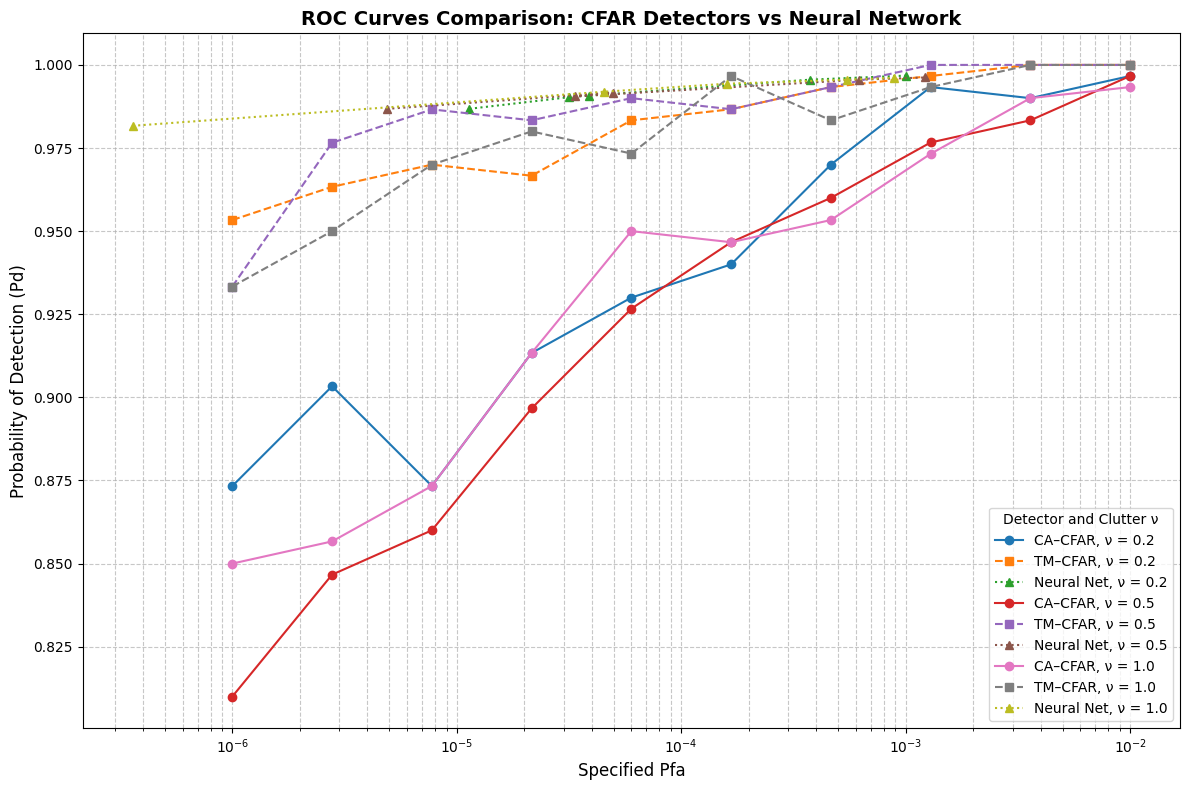

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pfa_values used for the CFAR simulations
# (In your CFAR simulation, pfa_values = np.logspace(-6, -2, num=10))
# Ensure these are defined in your scope.
# pfa_values = np.logspace(-6, -2, num=10)

plt.figure(figsize=(12, 8))
markers = {'CA': 'o', 'TM': 's', 'NN': '^'}
linestyles = {'CA': '-', 'TM': '--', 'NN': ':'}

# Loop over each clutter condition (ν value)
for nu in nu_values:
    # Plot CA–CFAR results
    plt.plot(
        pfa_values, 
        results_ca[nu]['Pd'], 
        marker=markers['CA'], linestyle=linestyles['CA'],
        label=f'CA–CFAR, ν = {nu}'
    )
    
    # Plot TM–CFAR results
    plt.plot(
        pfa_values, 
        results_tm[nu]['Pd'], 
        marker=markers['TM'], linestyle=linestyles['TM'],
        label=f'TM–CFAR, ν = {nu}'
    )
    
    # Plot Neural Network results
    # Here, pd_pfa_results[nu] returns a tuple (pd_array, pfa_array)
    nn_pd, nn_pfa = pd_pfa_results[nu]
    plt.plot(
        nn_pfa, 
        nn_pd, 
        marker=markers['NN'], linestyle=linestyles['NN'],
        label=f'Neural Net, ν = {nu}'
    )

plt.xscale('log')
plt.xlabel('Specified Pfa', fontsize=12)
plt.ylabel('Probability of Detection (Pd)', fontsize=12)
plt.title('ROC Curves Comparison: CFAR Detectors vs Neural Network', fontsize=14, fontweight='bold')
plt.grid(True, which='both', ls='--', alpha=0.7)
plt.legend(title='Detector and Clutter ν', fontsize=10)
plt.tight_layout()
plt.show()


## Diffusion

## diffusion blocks

In [51]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 189  # Range interval (m)
        self.v_min, self.v_max = -7.8, 7.8  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.8, 7.8  # Clutter min/max velocity (m/s)
        self.dr = 3   # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

        # Precompute the range steering matrix for matched filtering.
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N)
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N)))
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K)))
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
        return rd_signal

    def generate_clutter(self, nu):
        # random clutter velocity
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = (2 * torch.pi * (2 * self.fc * clutter_vel) / self.c)
        sigma_f = 0.05
        p, q = torch.meshgrid(torch.arange(self.N), torch.arange(self.K), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)

        # complex random generation
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.maximum(e.real, torch.tensor(0.0)))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        # gamma-distributed scattered reflectivities
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # range steering
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) * (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-20, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Build the label
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S + C + W

        # Matched filtering in range dimension:
        X_range = self.range_steering_full.conj() @ X
        S_range = self.range_steering_full.conj() @ S

        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        # Use the real part for the clean map
        clean_RD_map = S_RD.flip(dims=[1]).real

        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)
        # Use the magnitude for the noisy version
        noisy_RD_map = X_RD.abs().flip(dims=[1])
        
        return {
            'clean': abs(S),
            'noisy': abs(X),
            'rd_label': rd_label
        }

In [52]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, scnr=-10)
train_dataset_with_targets[0]["clean"].type()

'torch.FloatTensor'

### UNet

In [33]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)


*Attention*



In [34]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)

        # reshape to (B, num_heads, C//num_heads, H*W)
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) / math.sqrt(C // self.num_heads)
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return x + out


In [35]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)


In [36]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

In [37]:
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [38]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, time_emb_dim=32):
        """
        in_channels=2 because we concatenate:
            - x_t: the noised (or current reverse process) image (1 channel)
            - cond: the conditioning (noisy observed) image (1 channel)
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Bottleneck with attention
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        # Decoder with time embedding injections
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Time embeddings injected at various stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,2,H,W) where channels are [x_t, cond]
        t: (B,) normalized timesteps
        """
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

        x1 = self.inc(x)                 # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)     # (B,128,...)
        x3_skip, x3 = self.down2(x2)     # (B,256,...)
        x4_skip, x4 = self.down3(x3)     # (B,256,...)
        
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

## Diffusion process (noising and denoising)

In [39]:
class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Loss: train network to predict the noise added.
        x0: clean image (B,1,H,W)
        cond: conditioning (observed noisy image) (B,1,H,W)
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        
        # Concatenate along channel dimension: [x_noisy, cond]
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        One reverse diffusion step (from x_t to x_{t-1}).
        """
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised image conditioned on cond.
        cond: (B,1,H,W) the observed noisy image.
        shape: desired shape of x (B,1,H,W)
        """
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x


### Training 

In [40]:
def train_one_epoch(diffusion, dataloader, optimizer, device):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        x0 = batch['clean'].to(device)   # (B,H,W)
        cond = batch['noisy'].to(device) # (B,H,W)
        if x0.ndim == 3:
            x0 = x0.unsqueeze(1)
        if cond.ndim == 3:
            cond = cond.unsqueeze(1)

        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()

        loss = diffusion.p_losses(x0, t, cond)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        x0 = batch['clean'].to(device)
        cond = batch['noisy'].to(device)
        if x0.ndim == 3:
            x0 = x0.unsqueeze(1)
        if cond.ndim == 3:
            cond = cond.unsqueeze(1)

        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()

        # For the first batch, generate a sample and compute metrics
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dataset and split
full_dataset = RadarDataset(num_samples=100000)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

train_dataset_with_targets = RadarDataset(num_samples=102400, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)

# 3. Instantiate model and diffusion
cond_unet = ConditionalUNet(in_channels=2, out_channels=1, time_emb_dim=32).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

# 4. Optimizer
optimizer = torch.optim.Adam(cond_diffusion.parameters(), lr=1e-5)

# 5. Train Loop
num_epochs = 500
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_psnrs = []
val_mses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion.state_dict(), "best_cond_diffusion.pth")
        print("   --> Best model saved.")

# 6. Plot training curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()


RuntimeError: Input type (c10::complex<float>) and bias type (float) should be the same

### Inference

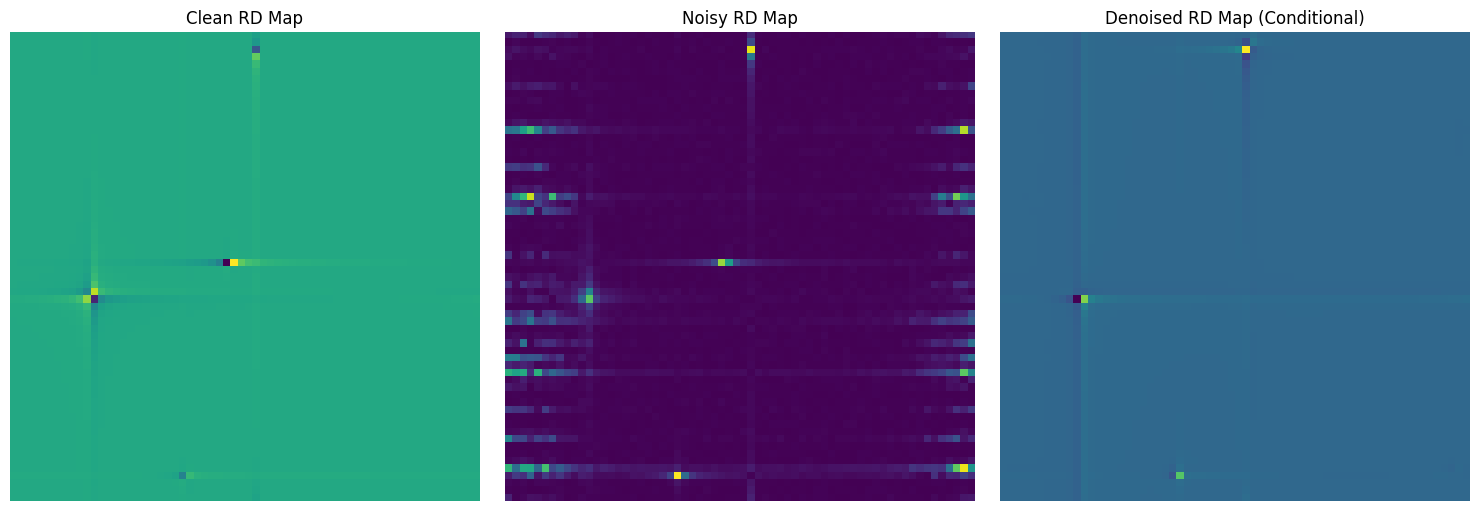

In [65]:
def run_inference():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Instantiate the same model and diffusion
    cond_unet = ConditionalUNet(in_channels=2, out_channels=1, time_emb_dim=32).to(device)
    cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # 2. Load the saved best checkpoint
    checkpoint_path = "best_cond_diffusion.pth"
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    # 3. Get a sample from dataset (or your own custom input)
    val_dataset = RadarDataset(num_samples=100, n_targets=8)



    val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True,scnr=-10)
    val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0, scnr=-10)

    val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])


    sample = val_dataset[0]
    clean_img = sample['clean']  # shape (H,W)
    noisy_img = sample['noisy']  # shape (H,W)

    # 4. Prepare for the model
    cond_img = noisy_img.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)
    shape = (1,1,clean_img.shape[0], clean_img.shape[1])       # same H,W

    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, shape)

    # 5. Visualization
    denoised_img = generated_sample.squeeze().cpu().numpy()
    clean_np = clean_img.cpu().numpy()
    noisy_np = noisy_img.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(clean_np, cmap='viridis')
    axes[0].set_title("Clean RD Map")
    axes[0].axis("off")

    axes[1].imshow(noisy_np, cmap='viridis')
    axes[1].set_title("Noisy RD Map")
    axes[1].axis("off")

    axes[2].imshow(denoised_img, cmap='viridis')
    axes[2].set_title("Denoised RD Map (Conditional)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_inference()


In [31]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

##########################################
# Utility: Cosine Beta Schedule Function #
##########################################

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)

##########################################
# Model Components                       #
##########################################

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # x is (B,) - timesteps
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # (B, dim)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Adjust padding if needed:
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class SelfAttention(nn.Module):
    """A simple self-attention layer to capture global context."""
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)
    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(b, c, -1).permute(0,2,1)  # (b, hw, c)
        k = self.k(x_norm).reshape(b, c, -1)                 # (b, c, hw)
        v = self.v(x_norm).reshape(b, c, -1).permute(0,2,1)  # (b, hw, c)
        attn = torch.bmm(q, k) / math.sqrt(c)
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0,2,1).reshape(b, c, h, w)
        out = self.proj(out)
        return x + out  # Residual connection

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, time_emb_dim=32):
        """
        in_channels=2 because we concatenate:
            - x_t: the noised image (1 channel)
            - cond: the conditioning (observed noisy image, 1 channel)
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.bot = DoubleConv(256, 512)
        # Adding self-attention in the bottleneck for better global context
        self.attn_bot = SelfAttention(512)
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Time embeddings injected at several stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,2,H,W) [x_t, cond]
        t: (B,) normalized timesteps in [0,1]
        """
        t_emb = self.time_emb(t)
        x1 = self.inc(x)              # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)    # (B,128, ...)
        x3_skip, x3 = self.down2(x2)    # (B,256, ...)
        x4_skip, x4 = self.down3(x3)    # (B,256, ...)
        x_bot = self.bot(x4)
        # Apply self-attention in the bottleneck
        x_bot = self.attn_bot(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        # You could try FiLM-style conditioning here (i.e. scaling and shifting) for further improvement
        x_bot = x_bot + t_bot
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, schedule='cosine'):
        super().__init__()
        self.model = model  # ConditionalUNet
        self.T = T
        # Use cosine schedule by default, or fall back to linear if specified
        if schedule == 'cosine':
            betas = cosine_beta_schedule(T)
            self.register_buffer("betas", betas)
        else:
            self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward (diffusion) process: q(x_t|x0)
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Compute loss between the predicted noise and true noise.
        x0: clean image (B,1,H,W)
        cond: conditioning image (B,1,H,W)
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T  # Normalize timestep to [0,1]
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        Reverse (denoising) step: sample x_{t-1} from x_t.
        t: an integer timestep
        """
        batch_size = x.shape[0]
        betas_t = self.betas[t].view(1, 1, 1, 1).repeat(batch_size, 1, 1, 1)
        alphas_t = self.alphas[t].view(1, 1, 1, 1).repeat(batch_size, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(1, 1, 1, 1).repeat(batch_size, 1, 1, 1)
        t_norm = torch.full((batch_size,), t, device=x.device, dtype=torch.float32) / self.T
        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised sample conditioned on `cond`.
        cond: (B,1,H,W) conditioning image.
        shape: desired shape for the generated sample.
        """
        x = torch.randn(shape, device=next(self.model.parameters()).device)
        for t in reversed(range(self.T)):
            x = self.p_sample(x, t, cond)
        return x

##########################################
# Metrics Functions                      #
##########################################

def compute_psnr(img1, img2):
    """
    Compute Peak Signal-to-Noise Ratio between two images.
    Assumes images are scaled to [0,1].
    """
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def compute_ssim(img1, img2):
    """
    Compute Structural Similarity Index (SSIM) between two images.
    """
    img1 = np.array(img1, dtype=np.float64)
    img2 = np.array(img2, dtype=np.float64)
    return ssim(img1, img2, data_range=img2.max() - img2.min())

##########################################
# Training and Evaluation                #
##########################################

def train_conditional_diffusion_model(diffusion, dataloader, optimizer, device,
                                      epochs=30, val_dataloader=None, checkpoint_path="checkpoint.pt"):
    diffusion.train()
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            # Get data and add channel dimensions if needed:
            x0 = batch['clean'].to(device)  # Clean image (B,H,W)
            cond = batch['noisy'].to(device)  # Noisy image (B,H,W)
            if x0.ndim == 3:
                x0 = x0.unsqueeze(1)
            if cond.ndim == 3:
                cond = cond.unsqueeze(1)
            t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
            loss = diffusion.p_losses(x0, t, cond)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1
            pbar.set_postfix(loss=loss.item())
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

        # Only run validation every 15 epochs (and on the final epoch)
        if val_dataloader is not None and ((epoch + 1) % 300 == 0 or (epoch + 1) == epochs):
            val_loss, val_psnr, val_ssim = evaluate_model(diffusion, val_dataloader, device)
            print(f"Validation Loss: {val_loss:.4f} | PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(diffusion.state_dict(), checkpoint_path)
                print("Saved best model checkpoint.")

def evaluate_model(diffusion, dataloader, device):
    diffusion.eval()
    total_loss = 0
    total_psnr = 0
    total_ssim = 0
    count = 0
    with torch.no_grad():
        for batch in dataloader:
            x0 = batch['clean'].to(device)
            cond = batch['noisy'].to(device)
            if x0.ndim == 3:
                x0 = x0.unsqueeze(1)
            if cond.ndim == 3:
                cond = cond.unsqueeze(1)
            # Generate sample using the diffusion model:
            generated = diffusion.sample(cond, x0.shape)
            loss = F.mse_loss(generated, x0).item()
            total_loss += loss
            # Convert to numpy for metric computation:
            x0_np = x0.squeeze().cpu().numpy()
            generated_np = generated.squeeze().cpu().numpy()
            psnr_val = compute_psnr(x0_np, generated_np)
            ssim_val = compute_ssim(x0_np, generated_np)
            total_psnr += psnr_val
            total_ssim += ssim_val
            count += 1
    diffusion.train()
    return total_loss / count, total_psnr / count, total_ssim / count

##########################################
# Inference Function                     #
##########################################

def inference(diffusion, cond_img, device, shape=None, checkpoint_path=None):
    """
    Run inference using a trained diffusion model.
    
    Args:
        diffusion: the ConditionalDiffusion model.
        cond_img: conditioning image tensor of shape (1,1,H,W).
        device: torch.device.
        shape: desired output shape. If None, defaults to cond_img.shape.
        checkpoint_path: path to a saved model checkpoint.
        
    Returns:
        Generated (denoised) image tensor.
    """
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        state_dict = torch.load(checkpoint_path, map_location=device)
        diffusion.load_state_dict(state_dict)
        print("Loaded model checkpoint.")
    diffusion.eval()
    if shape is None:
        shape = cond_img.shape
    with torch.no_grad():
        generated = diffusion.sample(cond_img, shape)
    return generated

##########################################
# Main: Training & Inference             #
##########################################

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # --- Prepare your datasets ---
    # Replace RadarDataset with your actual dataset class.
    train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
    train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)
    combined_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
    
    # Optionally split into training and validation sets (e.g., 90/10 split):
    val_size = int(0.1 * len(combined_dataset))
    train_size = len(combined_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])
    
    dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                              pin_memory=torch.cuda.is_available(), persistent_workers=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2,
                                pin_memory=torch.cuda.is_available(), persistent_workers=True)
    
    # --- Instantiate the model and diffusion process ---
    cond_unet = ConditionalUNet(in_channels=2, out_channels=1, time_emb_dim=32).to(device)
    cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02, schedule='cosine').to(device)
    optimizer = Adam(cond_diffusion.parameters(), lr=1e-4)
    
    # --- Train the model ---
    train_conditional_diffusion_model(cond_diffusion, dataloader, optimizer, device,
                                      epochs=500, val_dataloader=val_dataloader,
                                      checkpoint_path="best_diffusion.pt")
    
    # --- Inference on a sample ---
    # Get one sample from the validation set:
    sample = next(iter(val_dataloader))
    clean_img = sample['clean'][0]   # shape: (H,W)
    noisy_img = sample['noisy'][0]     # shape: (H,W)
    cond_img = noisy_img.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)
    
    generated_sample = inference(cond_diffusion, cond_img, device,
                                 shape=(1, 1, clean_img.shape[0], clean_img.shape[1]),
                                 checkpoint_path="best_diffusion.pt")
    denoised_img = generated_sample.squeeze().cpu().detach().numpy()
    
    # --- Plot the results ---
    clean_np = clean_img.cpu().numpy()
    noisy_np = noisy_img.cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(clean_np, cmap='viridis')
    axes[0].set_title('Clean RD Map')
    axes[0].axis('off')
    axes[1].imshow(noisy_np, cmap='viridis')
    axes[1].set_title('Noisy RD Map')
    axes[1].axis('off')
    axes[2].imshow(denoised_img, cmap='viridis')
    axes[2].set_title('Denoised RD Map (Conditional)')
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()


Epoch 1/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.79it/s, loss=0.702]


Epoch 1 Average Loss: 0.9703


Epoch 2/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.06it/s, loss=0.546]


Epoch 2 Average Loss: 0.6013


Epoch 3/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.57it/s, loss=0.479]


Epoch 3 Average Loss: 0.5142


Epoch 4/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.63it/s, loss=0.497]


Epoch 4 Average Loss: 0.4761


Epoch 5/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.38] 


Epoch 5 Average Loss: 0.4461


Epoch 6/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.67it/s, loss=0.461]


Epoch 6 Average Loss: 0.4251


Epoch 7/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.41it/s, loss=0.229]


Epoch 7 Average Loss: 0.4067


Epoch 8/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.70it/s, loss=0.355]


Epoch 8 Average Loss: 0.3865


Epoch 9/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.78it/s, loss=0.324]


Epoch 9 Average Loss: 0.3648


Epoch 10/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.92it/s, loss=0.254]


Epoch 10 Average Loss: 0.3496


Epoch 11/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.74it/s, loss=0.286]


Epoch 11 Average Loss: 0.3342


Epoch 12/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.78it/s, loss=0.429]


Epoch 12 Average Loss: 0.3184


Epoch 13/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.274]


Epoch 13 Average Loss: 0.3048


Epoch 14/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.75it/s, loss=0.3]  


Epoch 14 Average Loss: 0.2945


Epoch 15/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.77it/s, loss=0.311]


Epoch 15 Average Loss: 0.2835


Epoch 16/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.71it/s, loss=0.333]


Epoch 16 Average Loss: 0.2740


Epoch 17/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.72it/s, loss=0.232] 


Epoch 17 Average Loss: 0.2631


Epoch 18/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.67it/s, loss=0.232] 


Epoch 18 Average Loss: 0.2543


Epoch 19/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.46it/s, loss=0.282]


Epoch 19 Average Loss: 0.2458


Epoch 20/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.39it/s, loss=0.194]


Epoch 20 Average Loss: 0.2410


Epoch 21/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.12it/s, loss=0.237]


Epoch 21 Average Loss: 0.2342


Epoch 22/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.17it/s, loss=0.343] 


Epoch 22 Average Loss: 0.2319


Epoch 23/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.93it/s, loss=0.146] 


Epoch 23 Average Loss: 0.2201


Epoch 24/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.11it/s, loss=0.18]  


Epoch 24 Average Loss: 0.2161


Epoch 25/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.25it/s, loss=0.187] 


Epoch 25 Average Loss: 0.2142


Epoch 26/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.09it/s, loss=0.211] 


Epoch 26 Average Loss: 0.2066


Epoch 27/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.03it/s, loss=0.152] 


Epoch 27 Average Loss: 0.2024


Epoch 28/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.70it/s, loss=0.158] 


Epoch 28 Average Loss: 0.2000


Epoch 29/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.15]  


Epoch 29 Average Loss: 0.1937


Epoch 30/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.95it/s, loss=0.292] 


Epoch 30 Average Loss: 0.1924


Epoch 31/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.88it/s, loss=0.157] 


Epoch 31 Average Loss: 0.1920


Epoch 32/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.94it/s, loss=0.179] 


Epoch 32 Average Loss: 0.1825


Epoch 33/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.93it/s, loss=0.214] 


Epoch 33 Average Loss: 0.1821


Epoch 34/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.92it/s, loss=0.125] 


Epoch 34 Average Loss: 0.1780


Epoch 35/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.94it/s, loss=0.163] 


Epoch 35 Average Loss: 0.1771


Epoch 36/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.64it/s, loss=0.254] 


Epoch 36 Average Loss: 0.1774


Epoch 37/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.77it/s, loss=0.189] 


Epoch 37 Average Loss: 0.1720


Epoch 38/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.76it/s, loss=0.131] 


Epoch 38 Average Loss: 0.1729


Epoch 39/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.55it/s, loss=0.191] 


Epoch 39 Average Loss: 0.1694


Epoch 40/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.02it/s, loss=0.228] 


Epoch 40 Average Loss: 0.1682


Epoch 41/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.91it/s, loss=0.101] 


Epoch 41 Average Loss: 0.1668


Epoch 42/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.08it/s, loss=0.174] 


Epoch 42 Average Loss: 0.1652


Epoch 43/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.72it/s, loss=0.269] 


Epoch 43 Average Loss: 0.1647


Epoch 44/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.63it/s, loss=0.137] 


Epoch 44 Average Loss: 0.1607


Epoch 45/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.60it/s, loss=0.156] 


Epoch 45 Average Loss: 0.1624


Epoch 46/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.40it/s, loss=0.109] 


Epoch 46 Average Loss: 0.1568


Epoch 47/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.21it/s, loss=0.197] 


Epoch 47 Average Loss: 0.1579


Epoch 48/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.92it/s, loss=0.119] 


Epoch 48 Average Loss: 0.1572


Epoch 49/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.93it/s, loss=0.128] 


Epoch 49 Average Loss: 0.1554


Epoch 50/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.91it/s, loss=0.105] 


Epoch 50 Average Loss: 0.1541


Epoch 51/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.94it/s, loss=0.171] 


Epoch 51 Average Loss: 0.1598


Epoch 52/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.21it/s, loss=0.25]  


Epoch 52 Average Loss: 0.1513


Epoch 53/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.47it/s, loss=0.136] 


Epoch 53 Average Loss: 0.1504


Epoch 54/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.47it/s, loss=0.135] 


Epoch 54 Average Loss: 0.1493


Epoch 55/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.38it/s, loss=0.209] 


Epoch 55 Average Loss: 0.1462


Epoch 56/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.14it/s, loss=0.104] 


Epoch 56 Average Loss: 0.1505


Epoch 57/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.91it/s, loss=0.179] 


Epoch 57 Average Loss: 0.1444


Epoch 58/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.87it/s, loss=0.146] 


Epoch 58 Average Loss: 0.1445


Epoch 59/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.47it/s, loss=0.167] 


Epoch 59 Average Loss: 0.1516


Epoch 60/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.52it/s, loss=0.198] 


Epoch 60 Average Loss: 0.1450


Epoch 61/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.55it/s, loss=0.11]  


Epoch 61 Average Loss: 0.1446


Epoch 62/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.20it/s, loss=0.187] 


Epoch 62 Average Loss: 0.1432


Epoch 63/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.96it/s, loss=0.19]  


Epoch 63 Average Loss: 0.1424


Epoch 64/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.77it/s, loss=0.108] 


Epoch 64 Average Loss: 0.1393


Epoch 65/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.67it/s, loss=0.0802]


Epoch 65 Average Loss: 0.1391


Epoch 66/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.69it/s, loss=0.064] 


Epoch 66 Average Loss: 0.1429


Epoch 67/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.82it/s, loss=0.0963]


Epoch 67 Average Loss: 0.1393


Epoch 68/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.02it/s, loss=0.195] 


Epoch 68 Average Loss: 0.1378


Epoch 69/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.49it/s, loss=0.0911]


Epoch 69 Average Loss: 0.1431


Epoch 70/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.48it/s, loss=0.151] 


Epoch 70 Average Loss: 0.1354


Epoch 71/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.53it/s, loss=0.126] 


Epoch 71 Average Loss: 0.1386


Epoch 72/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.07it/s, loss=0.144] 


Epoch 72 Average Loss: 0.1344


Epoch 73/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.76it/s, loss=0.133] 


Epoch 73 Average Loss: 0.1350


Epoch 74/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.71it/s, loss=0.132] 


Epoch 74 Average Loss: 0.1364


Epoch 75/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.36it/s, loss=0.202] 


Epoch 75 Average Loss: 0.1356


Epoch 76/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.72it/s, loss=0.103] 


Epoch 76 Average Loss: 0.1329


Epoch 77/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.02it/s, loss=0.0664]


Epoch 77 Average Loss: 0.1325


Epoch 78/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.52it/s, loss=0.111] 


Epoch 78 Average Loss: 0.1314


Epoch 79/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.49it/s, loss=0.0977]


Epoch 79 Average Loss: 0.1323


Epoch 80/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.48it/s, loss=0.168] 


Epoch 80 Average Loss: 0.1335


Epoch 81/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.52it/s, loss=0.138] 


Epoch 81 Average Loss: 0.1298


Epoch 82/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.0815]


Epoch 82 Average Loss: 0.1284


Epoch 83/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.51it/s, loss=0.132] 


Epoch 83 Average Loss: 0.1282


Epoch 84/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.16it/s, loss=0.0743]


Epoch 84 Average Loss: 0.1279


Epoch 85/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.84it/s, loss=0.0632]


Epoch 85 Average Loss: 0.1287


Epoch 86/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.85it/s, loss=0.0756]


Epoch 86 Average Loss: 0.1290


Epoch 87/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.09it/s, loss=0.121] 


Epoch 87 Average Loss: 0.1291


Epoch 88/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.50it/s, loss=0.186] 


Epoch 88 Average Loss: 0.1275


Epoch 89/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.45it/s, loss=0.0419]


Epoch 89 Average Loss: 0.1265


Epoch 90/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.49it/s, loss=0.0659]


Epoch 90 Average Loss: 0.1256


Epoch 91/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.55it/s, loss=0.108] 


Epoch 91 Average Loss: 0.1274


Epoch 92/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.23it/s, loss=0.209] 


Epoch 92 Average Loss: 0.1255


Epoch 93/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.89it/s, loss=0.139] 


Epoch 93 Average Loss: 0.1244


Epoch 94/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.41it/s, loss=0.0785]


Epoch 94 Average Loss: 0.1264


Epoch 95/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.274] 


Epoch 95 Average Loss: 0.1234


Epoch 96/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.53it/s, loss=0.154] 


Epoch 96 Average Loss: 0.1259


Epoch 97/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.13]  


Epoch 97 Average Loss: 0.1227


Epoch 98/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.54it/s, loss=0.202] 


Epoch 98 Average Loss: 0.1230


Epoch 99/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.54it/s, loss=0.106] 


Epoch 99 Average Loss: 0.1244


Epoch 100/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.49it/s, loss=0.112] 


Epoch 100 Average Loss: 0.1240


Epoch 101/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.11it/s, loss=0.0816]


Epoch 101 Average Loss: 0.1206


Epoch 102/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.91it/s, loss=0.105] 


Epoch 102 Average Loss: 0.1205


Epoch 103/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.91it/s, loss=0.184] 


Epoch 103 Average Loss: 0.1218


Epoch 104/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.56it/s, loss=0.0651]


Epoch 104 Average Loss: 0.1201


Epoch 105/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.66it/s, loss=0.149] 


Epoch 105 Average Loss: 0.1221


Epoch 106/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.63it/s, loss=0.158] 


Epoch 106 Average Loss: 0.1214


Epoch 107/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.66it/s, loss=0.0374]


Epoch 107 Average Loss: 0.1200


Epoch 108/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.63it/s, loss=0.105] 


Epoch 108 Average Loss: 0.1211


Epoch 109/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.32it/s, loss=0.085] 


Epoch 109 Average Loss: 0.1157


Epoch 110/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.36it/s, loss=0.0863]


Epoch 110 Average Loss: 0.1195


Epoch 111/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.75it/s, loss=0.193] 


Epoch 111 Average Loss: 0.1191


Epoch 112/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.68it/s, loss=0.0606]


Epoch 112 Average Loss: 0.1165


Epoch 113/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.78it/s, loss=0.0809]


Epoch 113 Average Loss: 0.1221


Epoch 114/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.70it/s, loss=0.102] 


Epoch 114 Average Loss: 0.1223


Epoch 115/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.69it/s, loss=0.117] 


Epoch 115 Average Loss: 0.1180


Epoch 116/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.72it/s, loss=0.0677]


Epoch 116 Average Loss: 0.1156


Epoch 117/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.46it/s, loss=0.12]  


Epoch 117 Average Loss: 0.1241


Epoch 118/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.19it/s, loss=0.124] 


Epoch 118 Average Loss: 0.1184


Epoch 119/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.88it/s, loss=0.132] 


Epoch 119 Average Loss: 0.1170


Epoch 120/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.24it/s, loss=0.105] 


Epoch 120 Average Loss: 0.1169


Epoch 121/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.77it/s, loss=0.0986]


Epoch 121 Average Loss: 0.1181


Epoch 122/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.0726]


Epoch 122 Average Loss: 0.1133


Epoch 123/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.68it/s, loss=0.162] 


Epoch 123 Average Loss: 0.1160


Epoch 124/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.171] 


Epoch 124 Average Loss: 0.1175


Epoch 125/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.38it/s, loss=0.0755]


Epoch 125 Average Loss: 0.1150


Epoch 126/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.88it/s, loss=0.061] 


Epoch 126 Average Loss: 0.1150


Epoch 127/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.65it/s, loss=0.144] 


Epoch 127 Average Loss: 0.1151


Epoch 128/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.70it/s, loss=0.145] 


Epoch 128 Average Loss: 0.1122


Epoch 129/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.68it/s, loss=0.0925]


Epoch 129 Average Loss: 0.1122


Epoch 130/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.71it/s, loss=0.0771]


Epoch 130 Average Loss: 0.1129


Epoch 131/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.74it/s, loss=0.102] 


Epoch 131 Average Loss: 0.1156


Epoch 132/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.113] 


Epoch 132 Average Loss: 0.1119


Epoch 133/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.61it/s, loss=0.0702]


Epoch 133 Average Loss: 0.1124


Epoch 134/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.30it/s, loss=0.147] 


Epoch 134 Average Loss: 0.1135


Epoch 135/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.99it/s, loss=0.145] 


Epoch 135 Average Loss: 0.1128


Epoch 136/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.95it/s, loss=0.171] 


Epoch 136 Average Loss: 0.1113


Epoch 137/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.71it/s, loss=0.104] 


Epoch 137 Average Loss: 0.1114


Epoch 138/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.77it/s, loss=0.114] 


Epoch 138 Average Loss: 0.1112


Epoch 139/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.70it/s, loss=0.102] 


Epoch 139 Average Loss: 0.1147


Epoch 140/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.83it/s, loss=0.0707]


Epoch 140 Average Loss: 0.1141


Epoch 141/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.58it/s, loss=0.162] 


Epoch 141 Average Loss: 0.1104


Epoch 142/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.30it/s, loss=0.112] 


Epoch 142 Average Loss: 0.1122


Epoch 143/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.33it/s, loss=0.101]  


Epoch 143 Average Loss: 0.1110


Epoch 144/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.74it/s, loss=0.0928]


Epoch 144 Average Loss: 0.1112


Epoch 145/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.77it/s, loss=0.0711]


Epoch 145 Average Loss: 0.1122


Epoch 146/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.117] 


Epoch 146 Average Loss: 0.1088


Epoch 147/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.75it/s, loss=0.109] 


Epoch 147 Average Loss: 0.1091


Epoch 148/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.73it/s, loss=0.126] 


Epoch 148 Average Loss: 0.1107


Epoch 149/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.75it/s, loss=0.112] 


Epoch 149 Average Loss: 0.1104


Epoch 150/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.48it/s, loss=0.0573]


Epoch 150 Average Loss: 0.1100


Epoch 151/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.22it/s, loss=0.0479]


Epoch 151 Average Loss: 0.1065


Epoch 152/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.96it/s, loss=0.164] 


Epoch 152 Average Loss: 0.1090


Epoch 153/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.33it/s, loss=0.123] 


Epoch 153 Average Loss: 0.1087


Epoch 154/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.63it/s, loss=0.11]  


Epoch 154 Average Loss: 0.1090


Epoch 155/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.59it/s, loss=0.136] 


Epoch 155 Average Loss: 0.1085


Epoch 156/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.61it/s, loss=0.0596]


Epoch 156 Average Loss: 0.1087


Epoch 157/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.50it/s, loss=0.0561]


Epoch 157 Average Loss: 0.1082


Epoch 158/500: 100%|██████████| 1152/1152 [00:25<00:00, 45.34it/s, loss=0.156] 


Epoch 158 Average Loss: 0.1088


Epoch 159/500: 100%|██████████| 1152/1152 [00:25<00:00, 44.87it/s, loss=0.144] 


Epoch 159 Average Loss: 0.1068


Epoch 160/500:  97%|█████████▋| 1115/1152 [00:24<00:00, 44.78it/s, loss=0.0817]


KeyboardInterrupt: 

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# (Assume SinusoidalPosEmb, DoubleConv, Down, Up, and SelfAttention2d are defined as before.)

class ConditionalUNetMultiTask(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, time_emb_dim=32):
        """
        in_channels=2 because we concatenate:
            - x_t: the noised (or current reverse process) image (1 channel)
            - cond: the conditioning (noisy observed) image (1 channel)
        out_channels for noise prediction remains 1.
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Bottleneck with attention
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        # Decoder with time embedding injections
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        # Head for noise prediction (diffusion output)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Auxiliary detection head (for target segmentation)
        self.det_head = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1)
        )
        # Time embeddings injected at various stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,2,H,W) where channels are [x_t, cond]
        t: (B,) normalized timesteps
        """
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

        x1 = self.inc(x)                 # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)     # (B,128,...)
        x3_skip, x3 = self.down2(x2)     # (B,256,...)
        x4_skip, x4 = self.down3(x3)     # (B,256,...)
        
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)
        noise_output = self.outc(x)
        det_logits = self.det_head(x)  # detection logits for target segmentation
        
        # Return both outputs as a tuple
        return noise_output, det_logits
class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # now ConditionalUNetMultiTask
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond, target_mask=None, detection_loss_weight=0.1):
        """
        Loss: train network to predict the noise added AND (optionally) predict target masks.
        x0: clean image (B,1,H,W)
        cond: conditioning (observed noisy image) (B,1,H,W)
        target_mask: (optional) target segmentation mask (B,1,H,W), with values 0 or 1.
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        # Concatenate along channel dimension: [x_noisy, cond]
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred, det_logits = self.model(model_input, t_norm)
        loss_noise = F.mse_loss(noise_pred, noise)
        loss = loss_noise
        # If a target mask is provided, compute detection loss
        if target_mask is not None:
            loss_det = F.binary_cross_entropy_with_logits(det_logits, target_mask)
            loss += detection_loss_weight * loss_det
        return loss

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])
        model_input = torch.cat([x, cond], dim=1)
        noise_pred, _ = self.model(model_input, t_norm)  # ignore detection head during sampling
        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x
def train_one_epoch(diffusion, dataloader, optimizer, device, detection_loss_weight=0.1):
    diffusion.train()
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        x0 = batch['clean'].to(device)   # (B,H,W)
        cond = batch['noisy'].to(device)   # (B,H,W)
        target_mask = batch.get('target_mask', None)
        if target_mask is not None:
            target_mask = target_mask.to(device)
            
        if x0.ndim == 3:
            x0 = x0.unsqueeze(1)
        if cond.ndim == 3:
            cond = cond.unsqueeze(1)

        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()

        loss = diffusion.p_losses(x0, t, cond, target_mask=target_mask, detection_loss_weight=detection_loss_weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


@torch.no_grad()
def validate(diffusion, dataloader, device):
    diffusion.eval()
    val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        x0 = batch['clean'].to(device)   # (B,H,W)
        cond = batch['noisy'].to(device)   # (B,H,W)
        if x0.ndim == 3:
            x0 = x0.unsqueeze(1)
        if cond.ndim == 3:
            cond = cond.unsqueeze(1)

        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        loss = diffusion.p_losses(x0, t, cond)
        val_loss += loss.item()

        # For the first batch, generate a sample and compute metrics
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the multi-task UNet
cond_unet_mt = ConditionalUNetMultiTask(in_channels=2, out_channels=1, time_emb_dim=32).to(device)
cond_diffusion_mt = ConditionalDiffusion(model=cond_unet_mt, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

optimizer = torch.optim.Adam(cond_diffusion_mt.parameters(), lr=1e-5)

# Assume your dataset now yields 'clean', 'noisy', and optionally 'target_mask'
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,
                          pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cond_diffusion_mt, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion_mt, val_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")
    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cond_diffusion_mt.state_dict(), "best_cond_diffusion_mt.pth")
        print("   --> Best model saved.")


Epoch 1/100: Train Loss = 1.0066 | Val Loss = 1.0002
   [Generation Metrics] MSE: 233776.3438 | PSNR: 39.01 dB
   --> Best model saved.
Epoch 2/100: Train Loss = 1.0003 | Val Loss = 1.0002
   [Generation Metrics] MSE: 265135.5938 | PSNR: 36.39 dB
Epoch 3/100: Train Loss = 1.0003 | Val Loss = 1.0003
   [Generation Metrics] MSE: 266925.0000 | PSNR: 37.76 dB
Epoch 4/100: Train Loss = 0.9997 | Val Loss = 0.9993
   [Generation Metrics] MSE: 188421.7812 | PSNR: 37.65 dB
   --> Best model saved.
Epoch 5/100: Train Loss = 0.9725 | Val Loss = 0.8143
   [Generation Metrics] MSE: 379405.4375 | PSNR: 38.64 dB
   --> Best model saved.
Epoch 6/100: Train Loss = 0.7478 | Val Loss = 0.7166
   [Generation Metrics] MSE: 233862.2031 | PSNR: 38.20 dB
   --> Best model saved.
Epoch 7/100: Train Loss = 0.7108 | Val Loss = 0.7022
   [Generation Metrics] MSE: 249925.1406 | PSNR: 34.50 dB
   --> Best model saved.
Epoch 8/100: Train Loss = 0.6933 | Val Loss = 0.6940
   [Generation Metrics] MSE: 344565.8438 | PS

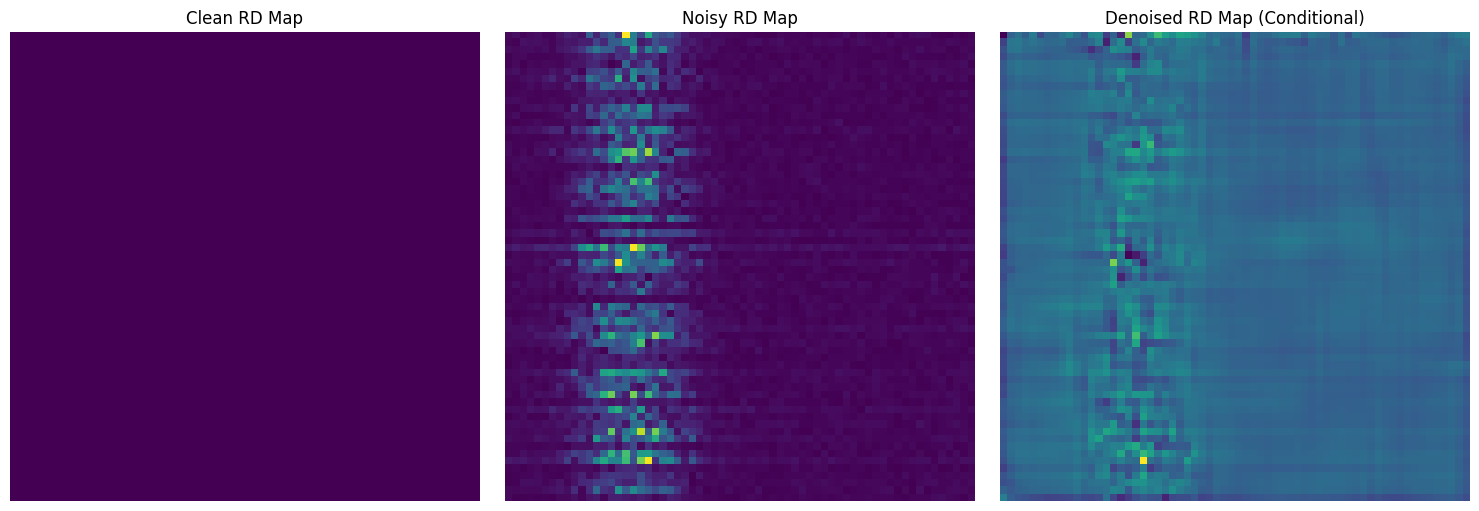

In [48]:
sample = next(iter(val_dataloader))
clean_img = sample['clean'][0]   # shape: (H,W)
noisy_img = sample['noisy'][0]     # shape: (H,W)
cond_img = noisy_img.unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)

generated_sample = inference(cond_diffusion, cond_img, device,
                                shape=(1, 1, clean_img.shape[0], clean_img.shape[1]),
                                checkpoint_path="best_cond_diffusion_mt.pt")
denoised_img = generated_sample.squeeze().cpu().detach().numpy()

# --- Plot the results ---
clean_np = clean_img.cpu().numpy()
noisy_np = noisy_img.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(clean_np, cmap='viridis')
axes[0].set_title('Clean RD Map')
axes[0].axis('off')
axes[1].imshow(noisy_np, cmap='viridis')
axes[1].set_title('Noisy RD Map')
axes[1].axis('off')
axes[2].imshow(denoised_img, cmap='viridis')
axes[2].set_title('Denoised RD Map (Conditional)')
axes[2].axis('off')
plt.tight_layout()
plt.show()

## Deep research

In [20]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import StudentT, Gamma

##############################################
# Radar Dataset Definition
##############################################
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 3, random_n_targets=False, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None
        self.N = 64        # Number of range bins
        self.K = 64        # Number of Doppler bins
        self.B = 50e6      # Bandwidth
        self.T0 = 1e-3     # Pulse duration
        self.fc = 9.39e9   # Carrier frequency
        self.c = 3e8       # Speed of light
        self.CNR = 15      # Clutter-to-noise ratio in dB
        self.r_min, self.r_max = 0, 189    # Range limits
        self.v_min, self.v_max = -7.8, 7.8  # Velocity limits
        self.vc_min, self.vc_max = -7.8, 7.8  # Clutter velocity limits
        self.dr = 3      # Range resolution
        self.dv = 0.249  # Velocity resolution
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float))
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N, dtype=torch.float)
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
        return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  
        p, q = torch.meshgrid(torch.arange(self.N, dtype=torch.float),
                              torch.arange(self.K, dtype=torch.float), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N, dtype=torch.float), self.R) *
                                (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / 
             torch.sqrt(torch.tensor(2.0 * self.sigma2)))
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)).item() if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1
        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S + C + W
        IQ_map = X
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S
        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        clean_RD_map = S_RD.flip(dims=[1])
        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)
        RD_map = X_RD.flip(dims=[1])
        return S, C, W, IQ_map, clean_RD_map, RD_map, rd_label

##############################################
# U-Net Denoiser with Diffusion Model
##############################################
class ResBlock(nn.Module):
    """Residual block with time embedding."""
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_ch)
        self.time_proj = nn.Linear(time_emb_dim, out_ch)
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else None

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)
        time_term = self.time_proj(F.silu(t_emb))
        h = h + time_term[:, :, None, None]
        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)
        if self.shortcut is not None:
            x = self.shortcut(x)
        return x + h

class UNetDenoiser(nn.Module):
    """U-Net architecture for denoising diffusion model."""
    def __init__(self, in_channels=2, base_channels=64, time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim*4),
            nn.SiLU(),
            nn.Linear(time_emb_dim*4, time_emb_dim)
        )
        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        # Encoder: Downsample path
        self.down1 = ResBlock(base_channels, base_channels, time_emb_dim)
        self.down2_downsample = nn.Conv2d(base_channels, base_channels*2, kernel_size=3, stride=2, padding=1)
        self.down2 = ResBlock(base_channels*2, base_channels*2, time_emb_dim)
        self.down3_downsample = nn.Conv2d(base_channels*2, base_channels*4, kernel_size=3, stride=2, padding=1)
        self.bottom = ResBlock(base_channels*4, base_channels*4, time_emb_dim)
        # Decoder: Upsample path
        self.up2_upsample = nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.up2_conv = ResBlock(base_channels*4, base_channels*2, time_emb_dim)
        self.up1_upsample = nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1)
        self.up1_conv = ResBlock(base_channels*2, base_channels, time_emb_dim)
        self.final_conv = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        t = t if isinstance(t, torch.Tensor) else torch.tensor([t], device=x.device)
        t = t.to(x.device).float().view(-1)
        half_dim = self.time_emb_dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half_dim, device=x.device) / half_dim)
        angles = t[:, None] * freqs[None, :]
        time_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)
        time_emb = self.time_mlp(time_emb)
        h = self.initial_conv(x)
        h1 = self.down1(h, time_emb)
        h2_in = self.down2_downsample(h1)
        h2 = self.down2(h2_in, time_emb)
        h3_in = self.down3_downsample(h2)
        h3 = self.bottom(h3_in, time_emb)
        u2 = self.up2_upsample(h3)
        u2 = torch.cat([u2, h2], dim=1)
        u2 = self.up2_conv(u2, time_emb)
        u1 = self.up1_upsample(u2)
        u1 = torch.cat([u1, h1], dim=1)
        u1 = self.up1_conv(u1, time_emb)
        out = self.final_conv(u1)
        return out

##############################################
# Diffusion Model Training with Student-t Noise
##############################################
def train_diffusion_model(num_epochs=10, batch_size=16, device='cuda'):
    # Create RadarDataset and DataLoader
    dataset = RadarDataset(num_samples=100000)  # Adjust sample count as needed
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = UNetDenoiser(in_channels=2, base_channels=64, time_emb_dim=256).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Diffusion noise schedule parameters
    T = 1000
    betas = torch.linspace(1e-4, 2e-2, T)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    # Move alpha_bars to the training device to avoid indexing issues
    alpha_bars = alpha_bars.to(device)
    
    nu = 5  # degrees of freedom for Student-t noise
    noise_dist = StudentT(df=nu)
    
    model.train()
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            # Data from RadarDataset: (S, C, W, IQ_map, clean_RD_map, RD_map, rd_label)
            # We use IQ_map as the clean signal x_0.
            _, _, _, IQ_map, _, _, _ = data
            # Convert complex IQ_map to 2 channels (real & imaginary)
            if torch.is_complex(IQ_map):
                clean_map = torch.stack([IQ_map.real, IQ_map.imag], dim=1)
            else:
                clean_map = IQ_map  # already in 2-channel format
            clean_map = clean_map.to(device).float()
            B, _, H, W = clean_map.shape
            
            # Sample random diffusion step t for each sample in the batch
            t = torch.randint(1, T, (B,), device=device)
            alpha_bar_t = alpha_bars[t].view(B, 1, 1, 1)
            
            # Sample heavy-tailed noise from Student-t distribution
            noise = noise_dist.sample(sample_shape=clean_map.shape).to(device)
            noise = noise.type(clean_map.dtype)
            
            # Create the noisy input x_t:
            # x_t = sqrt(alpha_bar_t)*x_0 + sqrt(1 - alpha_bar_t)*noise
            noisy_map = torch.sqrt(alpha_bar_t) * clean_map + torch.sqrt(1 - alpha_bar_t) * noise
            
            # Model predicts the noise component
            pred_noise = model(noisy_map, t)
            
            # Compute loss (MSE between predicted and true noise)
            loss = F.mse_loss(pred_noise, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 50 == 0:
                print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}")
    
    # Save the trained model
    torch.save(model.state_dict(), "unet_diffusion_model.pth")
    print("Training completed and model saved.")

##############################################
# Main Execution
##############################################
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_diffusion_model(num_epochs=100, batch_size=16, device=device)


Epoch 1, Step 0, Loss: 2.6698
Epoch 1, Step 50, Loss: 1.0994
Epoch 1, Step 100, Loss: 0.9465
Epoch 1, Step 150, Loss: 1.3036
Epoch 1, Step 200, Loss: 1.0213
Epoch 1, Step 250, Loss: 1.2337
Epoch 1, Step 300, Loss: 0.8958
Epoch 1, Step 350, Loss: 1.0815
Epoch 1, Step 400, Loss: 1.3035
Epoch 1, Step 450, Loss: 1.0466
Epoch 1, Step 500, Loss: 1.1590
Epoch 1, Step 550, Loss: 0.7985
Epoch 1, Step 600, Loss: 0.9225
Epoch 1, Step 650, Loss: 1.0808
Epoch 1, Step 700, Loss: 0.9096
Epoch 1, Step 750, Loss: 0.9221
Epoch 1, Step 800, Loss: 0.8037
Epoch 1, Step 850, Loss: 0.9488
Epoch 1, Step 900, Loss: 0.5494
Epoch 1, Step 950, Loss: 0.7172
Epoch 1, Step 1000, Loss: 0.8906
Epoch 1, Step 1050, Loss: 0.6086
Epoch 1, Step 1100, Loss: 0.6669
Epoch 1, Step 1150, Loss: 0.7258
Epoch 1, Step 1200, Loss: 1.0198
Epoch 1, Step 1250, Loss: 0.8162
Epoch 1, Step 1300, Loss: 0.5778
Epoch 1, Step 1350, Loss: 0.7239
Epoch 1, Step 1400, Loss: 0.6791
Epoch 1, Step 1450, Loss: 0.8792
Epoch 1, Step 1500, Loss: 0.9482


KeyboardInterrupt: 

In [21]:
torch.save(model.state_dict(), "unet_diffusion_model.pth")
print("Training completed and model saved.")

Training completed and model saved.


In [15]:
import math
import torch
from torch.distributions import StudentT

# (Assuming the UNetDenoiser class definition is available from the training code above)

def run_inference(model, T, betas, alphas, alpha_bars, device, sample_shape):
    """
    Runs the reverse diffusion process (deterministic) to obtain a clean IQ map.
    
    Args:
        model: The trained UNetDenoiser model.
        T: Total number of diffusion steps.
        betas: Tensor of beta schedule [T].
        alphas: Tensor of alpha values (1-beta) [T].
        alpha_bars: Cumulative product of alphas [T].
        device: Device (cpu or cuda).
        sample_shape: Tuple (B, 2, H, W) for the desired IQ map shape.
    
    Returns:
        x0: The final denoised IQ map (with 2 channels: real & imag).
    """
    # Sample initial noise from a Student-t distribution (heavy-tailed)
    nu = 5  # degrees of freedom (should match training)
    noise_dist = StudentT(df=nu)
    x_t = noise_dist.sample(sample_shape=sample_shape).to(device).float()
    
    # Reverse diffusion loop: t = T-1, T-2, ... , 1
    for t_val in reversed(range(1, T)):
        # Create a tensor of time steps (one per batch element)
        t = torch.full((sample_shape[0],), t_val, device=device, dtype=torch.long)
        # Get the cumulative noise levels for the current and previous time steps
        alpha_bar_t = alpha_bars[t_val].view(1, 1, 1, 1)  # scalar, broadcasted
        alpha_bar_prev = alpha_bars[t_val - 1].view(1, 1, 1, 1)
        
        with torch.no_grad():
            # Predict the noise in x_t using the U-Net
            pred_noise = model(x_t, t)
        
        # Compute the predicted clean signal x0 using:
        # x0_pred = (x_t - sqrt(1 - alpha_bar_t) * pred_noise) / sqrt(alpha_bar_t)
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_bar_t)
        
        # Reverse update: compute the mean of the reverse distribution.
        # For deterministic sampling, we set x_{t-1} = mean:
        #   x_{t-1} = sqrt(alpha_bar_prev)*x0_pred + sqrt(1 - alpha_bar_prev)*pred_noise
        x_t = torch.sqrt(alpha_bar_prev) * x0_pred + torch.sqrt(1 - alpha_bar_prev) * pred_noise
        
        # Optionally, for stochastic sampling add noise scaled by the reverse variance when t_val > 1.
        # For deterministic denoising, we omit this extra noise.
    
    # At the end of the loop, x_t approximates x0, the denoised IQ map.
    return x_t

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Diffusion parameters: should match those used during training.
    T = 1000
    betas = torch.linspace(1e-4, 2e-2, T).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0).to(device)
    
    # Load the trained model from checkpoint
    model = UNetDenoiser(in_channels=2, base_channels=64, time_emb_dim=256).to(device)
    model.load_state_dict(torch.load("unet_diffusion_model.pth", map_location=device))
    model.eval()
    
    # Define the desired output shape (batch, channels, H, W)
    # For example, for a single IQ map with resolution 64x64 and 2 channels (real, imag):
    sample_shape = (1, 2, 64, 64)
    
    # Run inference (reverse diffusion) to obtain the denoised IQ map
    denoised = run_inference(model, T, betas, alphas, alpha_bars, device, sample_shape)
    
    # Convert the 2-channel output into a complex IQ map:
    # Channel 0 is real and channel 1 is imaginary.
    denoised_complex = denoised[:, 0, :, :] + 1j * denoised[:, 1, :, :]
    print("Denoised IQ map shape:", denoised_complex.shape)
    # You can further process or visualize the denoised_complex output as needed.


Denoised IQ map shape: torch.Size([1, 64, 64])


SCNR (Noisy): -3.22 dB
SCNR (Clean Target): -1.64 dB
SCNR (Denoised): -3.83 dB


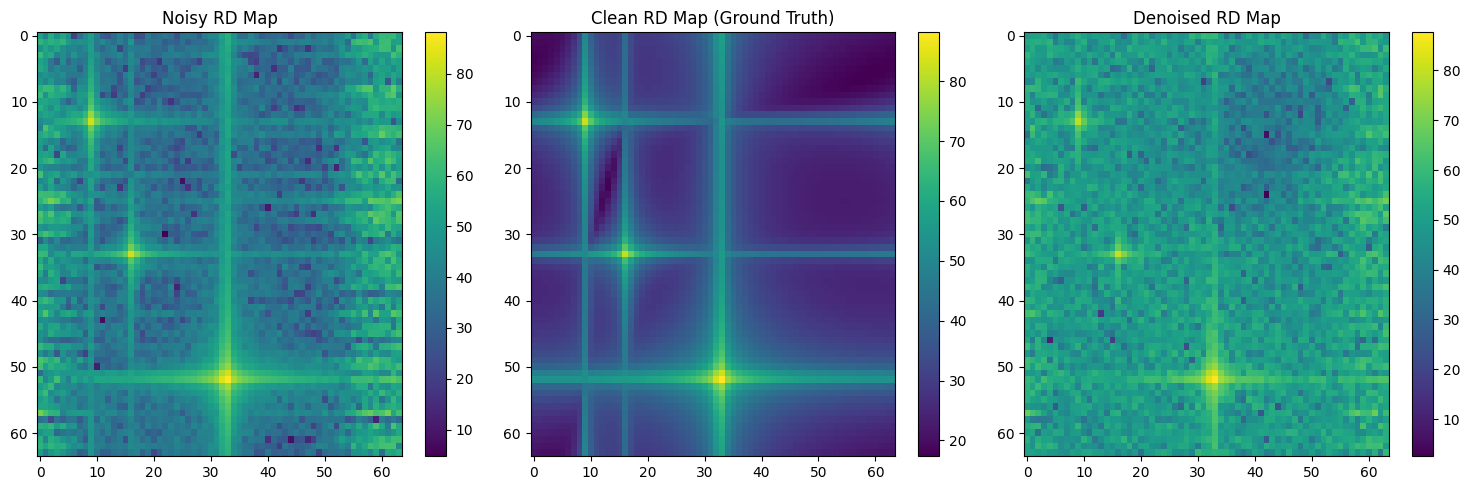

In [22]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import StudentT

# --- (Assume RadarDataset, UNetDenoiser, and training code above are defined) ---

##############################################
# Helper Functions for Range-Doppler Processing and SCNR
##############################################
def compute_rd_map(x, range_steering_full):
    """
    Given an IQ map x (complex, shape [B, N, K]),
    compute the range-Doppler map using the provided range steering matrix.
    """
    # x: [B, N, K] (complex)
    # range_steering_full: [N, dR]  (complex)
    # Compute range-domain signal: X_range = range_steering_full^H @ x, shape: [B, dR, K]
    # (Using conjugate transpose of steering matrix)
    X_range = torch.matmul(range_steering_full.conj().T, x)
    # FFT along the Doppler (last) axis
    X_RD = torch.fft.fft(X_range, dim=-1)
    X_RD = torch.fft.fftshift(X_RD, dim=-1)
    # Flip to align with ground truth if needed (as in RadarDataset)
    RD_map = X_RD.flip(dims=[-1])
    return RD_map

def compute_scnr(rd_map, rd_label):
    """
    Computes SCNR in dB given a range-Doppler map and the ground truth label.
    rd_map: [dR, dV] complex tensor
    rd_label: [dR, dV] binary mask (1 at target locations)
    """
    mag2 = rd_map.abs() ** 2
    # Use rd_label as boolean mask (if nonzero then target)
    mask = rd_label.bool()
    target_power = mag2[mask].sum()
    background_power = mag2[~mask].sum() + 1e-8
    scnr = 10 * torch.log10(target_power / background_power)
    return scnr.item()

##############################################
# Inference: Conditional Diffusion Denoising and Visualization
##############################################
def run_inference(model, noisy_map, t_start, T, betas, alpha_bars, device):
    """
    Runs a reverse diffusion chain starting from a given noisy_map.
    We first “inject” additional heavy-tailed noise to move the observed IQ map
    onto the diffusion trajectory at time t_start, then run reverse steps from t_start down to 0.
    
    Args:
        model: trained UNetDenoiser.
        noisy_map: observed IQ map with shape [B, 2, H, W] (float tensor).
        t_start: starting diffusion step (e.g., 500).
        T: total number of diffusion steps.
        betas: tensor of beta schedule [T].
        alpha_bars: cumulative product tensor [T].
        device: computation device.
        
    Returns:
        x0: denoised IQ map with shape [B, 2, H, W].
    """
    B = noisy_map.shape[0]
    # Move the observed noisy_map to the diffusion trajectory at step t_start:
    # x_t = sqrt(alpha_bar_t)*noisy_map + sqrt(1 - alpha_bar_t)*noise
    nu = 5  # same degrees of freedom as used during training
    noise_dist = StudentT(df=nu)
    noise = noise_dist.sample(sample_shape=noisy_map.shape).to(device).float()
    
    alpha_bar_t = alpha_bars[t_start].view(1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * noisy_map + torch.sqrt(1 - alpha_bar_t) * noise

    # Reverse diffusion from t_start down to t = 0 (deterministic chain)
    for t_val in reversed(range(1, t_start)):
        t_tensor = torch.full((B,), t_val, device=device, dtype=torch.long)
        alpha_bar_current = alpha_bars[t_val].view(1, 1, 1, 1)
        alpha_bar_prev = alpha_bars[t_val - 1].view(1, 1, 1, 1)
        with torch.no_grad():
            pred_noise = model(x_t, t_tensor)
        # Estimate the original signal at this stage:
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_current) * pred_noise) / torch.sqrt(alpha_bar_current)
        # Deterministic update:
        x_t = torch.sqrt(alpha_bar_prev) * x0_pred + torch.sqrt(1 - alpha_bar_prev) * pred_noise
    return x_t

##############################################
# Main Inference Routine
##############################################
def inference_and_visualize():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load one sample from the dataset
    dataset = RadarDataset(num_samples=1000)
    # Get one sample (S: clean target signal, IQ_map: observed noisy map, rd_label: ground truth mask)
    S, _, _, IQ_map, clean_RD_map, RD_map, rd_label = dataset[0]
    # S: complex tensor [N, K]; IQ_map: complex tensor [N, K]
    # Convert to 2-channel (real, imag) float tensors:
    def complex_to_channels(x):
        return torch.stack([x.real, x.imag], dim=0)  # shape [2, N, K]
    
    clean_map = complex_to_channels(S)  # "clean" target signal
    noisy_map = complex_to_channels(IQ_map)  # observed IQ map (with clutter & noise)
    
    # Expand dims to include batch dimension:
    clean_map = clean_map.unsqueeze(0).to(device).float()  # [1, 2, N, K]
    noisy_map = noisy_map.unsqueeze(0).to(device).float()    # [1, 2, N, K]
    
    # Load the trained diffusion model
    model = UNetDenoiser(in_channels=2, base_channels=64, time_emb_dim=256).to(device)
    model.load_state_dict(torch.load("unet_diffusion_model.pth", map_location=device))
    model.eval()
    
    # Diffusion parameters (must match training)
    T = 1000
    betas = torch.linspace(1e-4, 2e-2, T).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0).to(device)
    
    # Choose a starting step for reverse diffusion (e.g., t_start = 500)
    t_start = 500
    # Run the reverse diffusion chain to get the denoised IQ map
    denoised_map = run_inference(model, noisy_map, t_start, T, betas, alpha_bars, device)
    
    # Convert the 2-channel outputs back to complex representation:
    def channels_to_complex(x):
        # x: [B, 2, H, W] -> complex tensor [B, H, W]
        return x[:, 0, :, :] + 1j * x[:, 1, :, :]
    
    noisy_complex = channels_to_complex(noisy_map).cpu().detach()
    clean_complex = channels_to_complex(clean_map).cpu().detach()
    denoised_complex = channels_to_complex(denoised_map).cpu().detach()
    
    # For SCNR, compute range-Doppler maps.
    # Use the same range steering matrix from the dataset.
    range_steering_full = dataset.range_steering_full  # shape [N, dR]
    # Reshape noisy, clean, denoised maps to [B, N, K] (they are already complex)
    # Compute RD maps (take the first sample in batch)
    noisy_RD = compute_rd_map(noisy_complex, range_steering_full)[0]
    clean_RD = compute_rd_map(clean_complex, range_steering_full)[0]
    denoised_RD = compute_rd_map(denoised_complex, range_steering_full)[0]
    
    # Compute SCNR for each RD map using rd_label (which is [dR, dV])
    scnr_noisy = compute_scnr(noisy_RD, rd_label)
    scnr_clean = compute_scnr(clean_RD, rd_label)
    scnr_denoised = compute_scnr(denoised_RD, rd_label)
    
    print(f"SCNR (Noisy): {scnr_noisy:.2f} dB")
    print(f"SCNR (Clean Target): {scnr_clean:.2f} dB")
    print(f"SCNR (Denoised): {scnr_denoised:.2f} dB")
    
    # Visualize the magnitude (in dB) of the RD maps.
    def to_dB(x, eps=1e-8):
        return 10 * torch.log10(x.abs()**2 + eps)
    
    noisy_img = to_dB(noisy_RD)
    clean_img = to_dB(clean_RD)
    denoised_img = to_dB(denoised_RD)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(noisy_img.cpu(), aspect='auto', cmap='viridis')
    plt.title("Noisy RD Map")
    plt.colorbar()
    
    plt.subplot(1,3,2)
    plt.imshow(clean_img.cpu(), aspect='auto', cmap='viridis')
    plt.title("Clean RD Map (Ground Truth)")
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plt.imshow(denoised_img.cpu(), aspect='auto', cmap='viridis')
    plt.title("Denoised RD Map")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    inference_and_visualize()


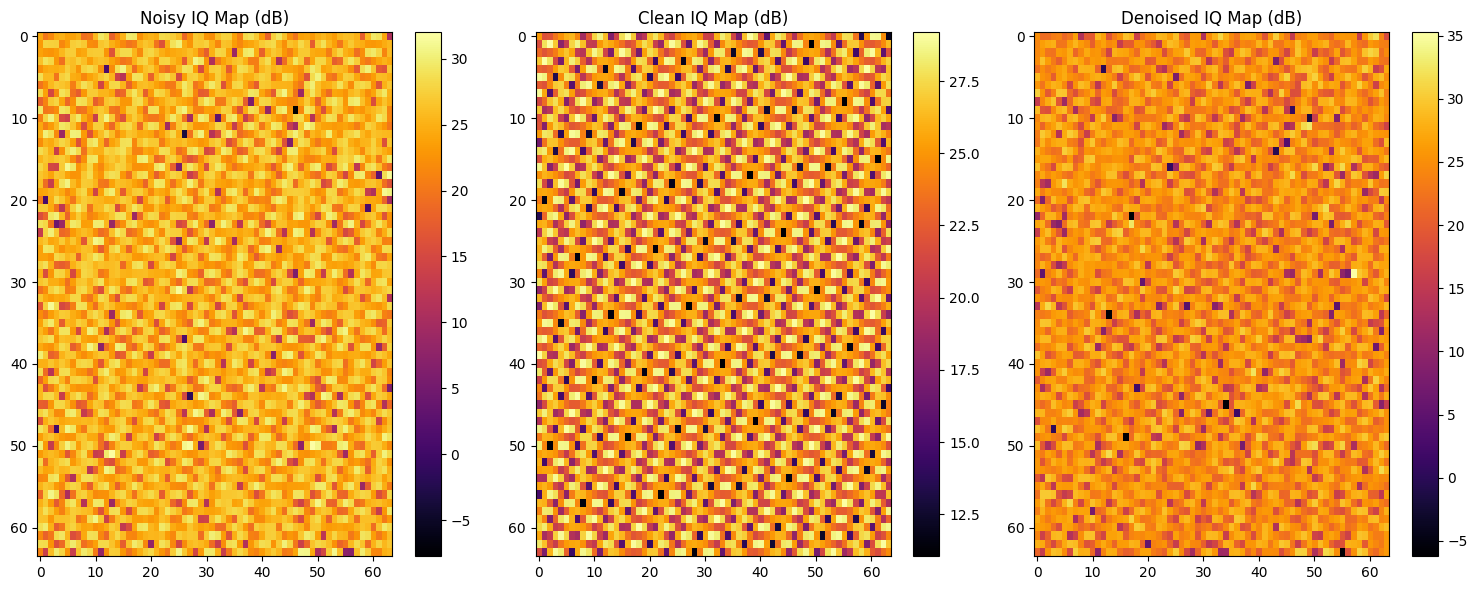

SCNR (Noisy): -2.13 dB
SCNR (Clean Target): -1.46 dB
SCNR (Denoised): -2.64 dB


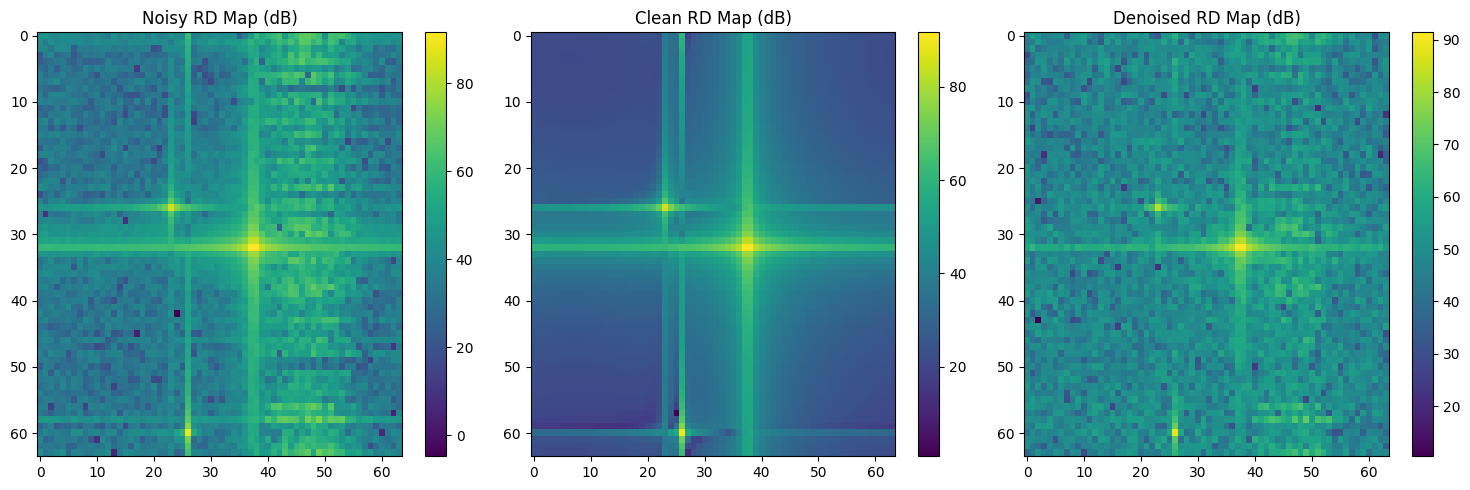

In [23]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import StudentT

# --- (Assume RadarDataset and UNetDenoiser definitions are already available) ---

##############################################
# Helper Functions
##############################################
def complex_to_channels(x):
    """
    Convert a complex tensor x (shape [H, W]) to 2-channel tensor (real and imaginary).
    """
    return torch.stack([x.real, x.imag], dim=0)  # [2, H, W]

def channels_to_complex(x):
    """
    Convert a 2-channel tensor (shape [B, 2, H, W]) to a complex tensor (shape [B, H, W]).
    """
    return x[:, 0, :, :] + 1j * x[:, 1, :, :]

def to_dB(x, eps=1e-8):
    """
    Convert a tensor x (magnitude) to decibel scale.
    """
    return 10 * torch.log10(x.abs() ** 2 + eps)

def compute_rd_map(x, range_steering_full):
    """
    Given an IQ map x (complex, shape [B, N, K]),
    compute the range-Doppler map using the provided range steering matrix.
    """
    # x: [B, N, K] (complex)
    # range_steering_full: [N, dR] (complex)
    # Compute range-domain signal: X_range = range_steering_full^H @ x -> shape: [B, dR, K]
    X_range = torch.matmul(range_steering_full.conj().T, x)
    # FFT along Doppler axis
    X_RD = torch.fft.fft(X_range, dim=-1)
    X_RD = torch.fft.fftshift(X_RD, dim=-1)
    RD_map = X_RD.flip(dims=[-1])
    return RD_map

def compute_scnr(rd_map, rd_label):
    """
    Computes SCNR (dB) given a range-Doppler map and ground truth binary label mask.
    """
    mag2 = rd_map.abs() ** 2
    mask = rd_label.bool()
    target_power = mag2[mask].sum()
    background_power = mag2[~mask].sum() + 1e-8
    scnr = 10 * torch.log10(target_power / background_power)
    return scnr.item()

##############################################
# Inference: Reverse Diffusion Process
##############################################
def run_inference(model, noisy_map, t_start, T, betas, alpha_bars, device):
    """
    Runs reverse diffusion from step t_start down to t=0.
    The observed noisy_map is first moved onto the diffusion trajectory at t_start.
    """
    B = noisy_map.shape[0]
    nu = 5  # degrees of freedom (should match training)
    noise_dist = StudentT(df=nu)
    noise = noise_dist.sample(sample_shape=noisy_map.shape).to(device).float()
    
    alpha_bar_t = alpha_bars[t_start].view(1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * noisy_map + torch.sqrt(1 - alpha_bar_t) * noise

    for t_val in reversed(range(1, t_start)):
        t_tensor = torch.full((B,), t_val, device=device, dtype=torch.long)
        alpha_bar_current = alpha_bars[t_val].view(1, 1, 1, 1)
        alpha_bar_prev = alpha_bars[t_val - 1].view(1, 1, 1, 1)
        with torch.no_grad():
            pred_noise = model(x_t, t_tensor)
        x0_pred = (x_t - torch.sqrt(1 - alpha_bar_current) * pred_noise) / torch.sqrt(alpha_bar_current)
        x_t = torch.sqrt(alpha_bar_prev) * x0_pred + torch.sqrt(1 - alpha_bar_prev) * pred_noise
    return x_t

##############################################
# Main Inference and Visualization Routine
##############################################
def inference_and_visualize():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load one sample from RadarDataset
    dataset = RadarDataset(num_samples=1000)
    S, _, _, IQ_map, clean_RD_map, RD_map, rd_label = dataset[0]
    
    # Convert complex IQ maps to 2-channel format: shape [2, N, K]
    clean_iq = complex_to_channels(S)
    noisy_iq = complex_to_channels(IQ_map)
    
    # Add a batch dimension and move to device: shape [1, 2, N, K]
    clean_map = clean_iq.unsqueeze(0).to(device).float()
    noisy_map = noisy_iq.unsqueeze(0).to(device).float()
    
    # Load the trained model
    model = UNetDenoiser(in_channels=2, base_channels=64, time_emb_dim=256).to(device)
    model.load_state_dict(torch.load("unet_diffusion_model.pth", map_location=device))
    model.eval()
    
    # Diffusion parameters (must match training)
    T = 1000
    betas = torch.linspace(1e-4, 2e-2, T).to(device)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0).to(device)
    
    # Choose a starting step for reverse diffusion (e.g., t_start = 500)
    t_start = 500
    denoised_map = run_inference(model, noisy_map, t_start, T, betas, alpha_bars, device)
    
    # Convert the 2-channel outputs back to complex format (shape [1, N, K])
    noisy_complex = channels_to_complex(noisy_map).cpu().detach()
    clean_complex = channels_to_complex(clean_map).cpu().detach()
    denoised_complex = channels_to_complex(denoised_map).cpu().detach()
    
    # Visualize IQ maps (display magnitude in dB)
    iq_noisy_db = to_dB(noisy_complex[0])
    iq_clean_db = to_dB(clean_complex[0])
    iq_denoised_db = to_dB(denoised_complex[0])
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    plt.imshow(iq_noisy_db, aspect='auto', cmap='inferno')
    plt.title("Noisy IQ Map (dB)")
    plt.colorbar()
    
    plt.subplot(1,3,2)
    plt.imshow(iq_clean_db, aspect='auto', cmap='inferno')
    plt.title("Clean IQ Map (dB)")
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plt.imshow(iq_denoised_db, aspect='auto', cmap='inferno')
    plt.title("Denoised IQ Map (dB)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Compute RD maps using the dataset's range steering matrix
    range_steering_full = dataset.range_steering_full  # [N, dR]
    # For inference, assume our IQ maps have shape [1, N, K] (complex)
    noisy_RD = compute_rd_map(noisy_complex, range_steering_full)[0]
    clean_RD = compute_rd_map(clean_complex, range_steering_full)[0]
    denoised_RD = compute_rd_map(denoised_complex, range_steering_full)[0]
    
    # Compute SCNR metrics using the ground truth rd_label (shape [dR, dV])
    scnr_noisy = compute_scnr(noisy_RD, rd_label)
    scnr_clean = compute_scnr(clean_RD, rd_label)
    scnr_denoised = compute_scnr(denoised_RD, rd_label)
    
    print(f"SCNR (Noisy): {scnr_noisy:.2f} dB")
    print(f"SCNR (Clean Target): {scnr_clean:.2f} dB")
    print(f"SCNR (Denoised): {scnr_denoised:.2f} dB")
    
    # Visualize RD maps (magnitude in dB)
    rd_noisy_db = to_dB(noisy_RD)
    rd_clean_db = to_dB(clean_RD)
    rd_denoised_db = to_dB(denoised_RD)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(rd_noisy_db.cpu(), aspect='auto', cmap='viridis')
    plt.title("Noisy RD Map (dB)")
    plt.colorbar()
    
    plt.subplot(1,3,2)
    plt.imshow(rd_clean_db.cpu(), aspect='auto', cmap='viridis')
    plt.title("Clean RD Map (dB)")
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plt.imshow(rd_denoised_db.cpu(), aspect='auto', cmap='viridis')
    plt.title("Denoised RD Map (dB)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    inference_and_visualize()


# Rearange

## Imports

In [1]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

### wandb

In [2]:
# os.environ["#wandb_NOTEBOOK_NAME"] = "compare.ipynb"
# #wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
# #wandb.init(project="Diffusion-for-radar", mode="online")

## dataset

In [3]:
import torch
from torch.utils.data import Dataset

class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        """
        Creates the raw (unscaled) target signals for each target,
        then (if old scnr approach) scales them to achieve the desired scnr in dB,
        or returns them raw for later scaling if snr/cnr approach is used.
        """
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        
        # If we are using the old SCNR approach, scale immediately
        # Gains in dB => each target’s SCNR
        if (self.snr_dB is None) or (self.cnr_dB is None):
            # Old approach: sum all scaled targets into a single matrix
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            # With the new approach, we do NOT scale by SCNR here.
            # We return the raw sum across all targets, for later power-based scaling.
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        # M is the covariance-like matrix for correlated clutter
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        # Draw complex Gaussian
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        # Impart heavy–tailed behavior via Gamma modulation (shape = scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation
        # using a range–steering operation.
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        """
        Generate one radar data frame, label map, and the separate S, C, W
        so that we can control SNR and CNR (if specified).
        """
        # 1. Generate unscaled noise (mean 0, unit variance in each real/imag component).
        #    We'll measure it and scale later if snr/cnr is used.
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        # 2. Generate unscaled clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        
        # 3. Prepare to generate target signal(s)
        #    We'll choose random targets if with_targets == True
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            # If new SNR/CNR approach is NOT used, we fallback to scnr or [-5, 10] dB random
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                # Just pass dummy dB array here; we won't scale inside 'generate_target_signal'
                # Instead, we will do the scaling outside
                S_raw = []
                for i in range(n):
                    # Each target can have the same 'gain' placeholder
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                # Sum all targets
                S_unscaled = sum(S_raw)

            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        # ---------------------------
        # NEW: If snr & cnr are given, do amplitude scaling here
        # ---------------------------
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            # 1) measure raw powers
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            # 2) define desired linear ratios
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            # 3) define desired final powers
            #    We'll anchor the noise to "1.0" average power for convenience
            #    (or you could anchor it to some other power). Then scale clutter & signal.
            #    Step (A): Scale noise to final_noise_power = 1.0
            #             => alpha_n = sqrt(1 / noise_power).
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            #    Step (B): Clutter should have average power = cnr_lin * final_noise_power
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            #    Step (C): Signal should have average power = snr_lin * final_noise_power
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        # Optional: measure the resulting SCNR for *your own* info
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        """
        Return the data and label for sample 'idx'.
        """
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB

In [4]:
def visualize_sample(dataset, sample_index: int = 0):

    signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[sample_index]
    print(scnr_dB)
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 6, 1)
    plt.imshow(torch.real(signal), aspect='auto', cmap='viridis')
    plt.title("Real clean Signal", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 2)
    plt.imshow(torch.imag(signal), aspect='auto', cmap='viridis')
    plt.title("Imaginary clean Siganl", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 3)
    plt.imshow(torch.real(clutter), aspect='auto', cmap='viridis')
    plt.title("Real Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 4)
    plt.imshow(torch.imag(clutter), aspect='auto', cmap='viridis')
    plt.title("Imaginary Clutter", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 5)
    plt.imshow(torch.real(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("real white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.subplot(1, 6, 6)
    plt.imshow(torch.imag(gaus_noise), aspect='auto', cmap='viridis')
    plt.title("Imaginary white gaussian noise", fontsize=14)
    plt.xlabel("Fast Time", fontsize=12)
    plt.ylabel("Slow Time", fontsize=12)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 6))
    plt.subplot(1,3,1)
    plt.imshow(abs(IQ), aspect='auto', cmap='viridis')
    plt.title("Noisy IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,2)
    plt.imshow(abs(signal), aspect='auto', cmap='viridis')
    plt.title("Clean IQ Map", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.subplot(1,3,3)
    plt.imshow(rd_label, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Label", fontsize=14)
    plt.xlabel("Range", fontsize=12)
    plt.ylabel("Doppler", fontsize=12)

    plt.tight_layout()
    plt.show()


In [5]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=1,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )
            
            signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[0]

            iq_magnitude = torch.abs(IQ)
            iq_db = 20 * torch.log10(iq_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(iq_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            
            _, C_sample, W_sample, _, _, _ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # 2) Now plot a SECOND figure comparing all nu's at once
    # -----------------------------------------------------
    plt.figure(figsize=(8, 6))

    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


tensor(-0.6464)


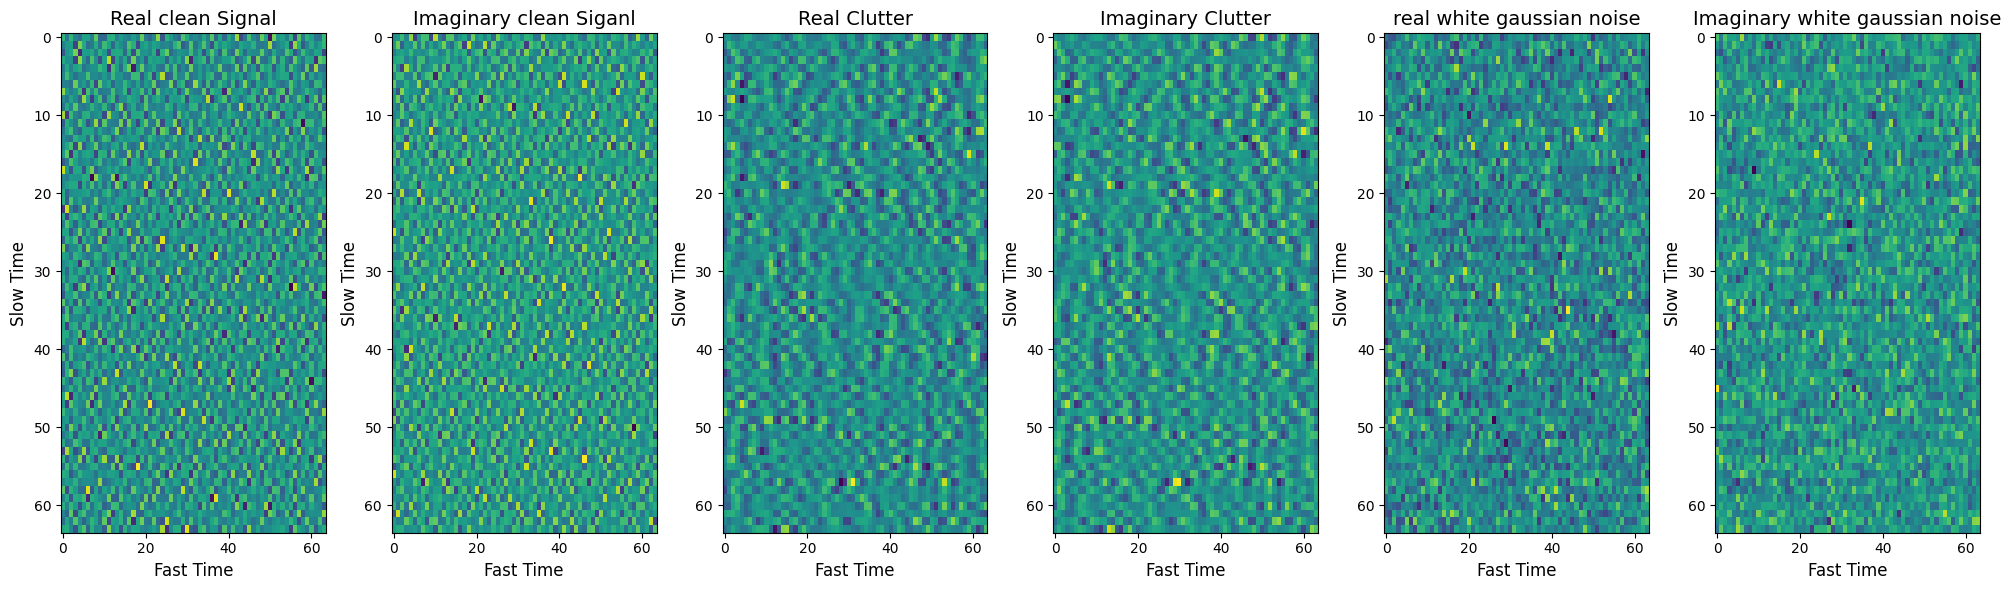

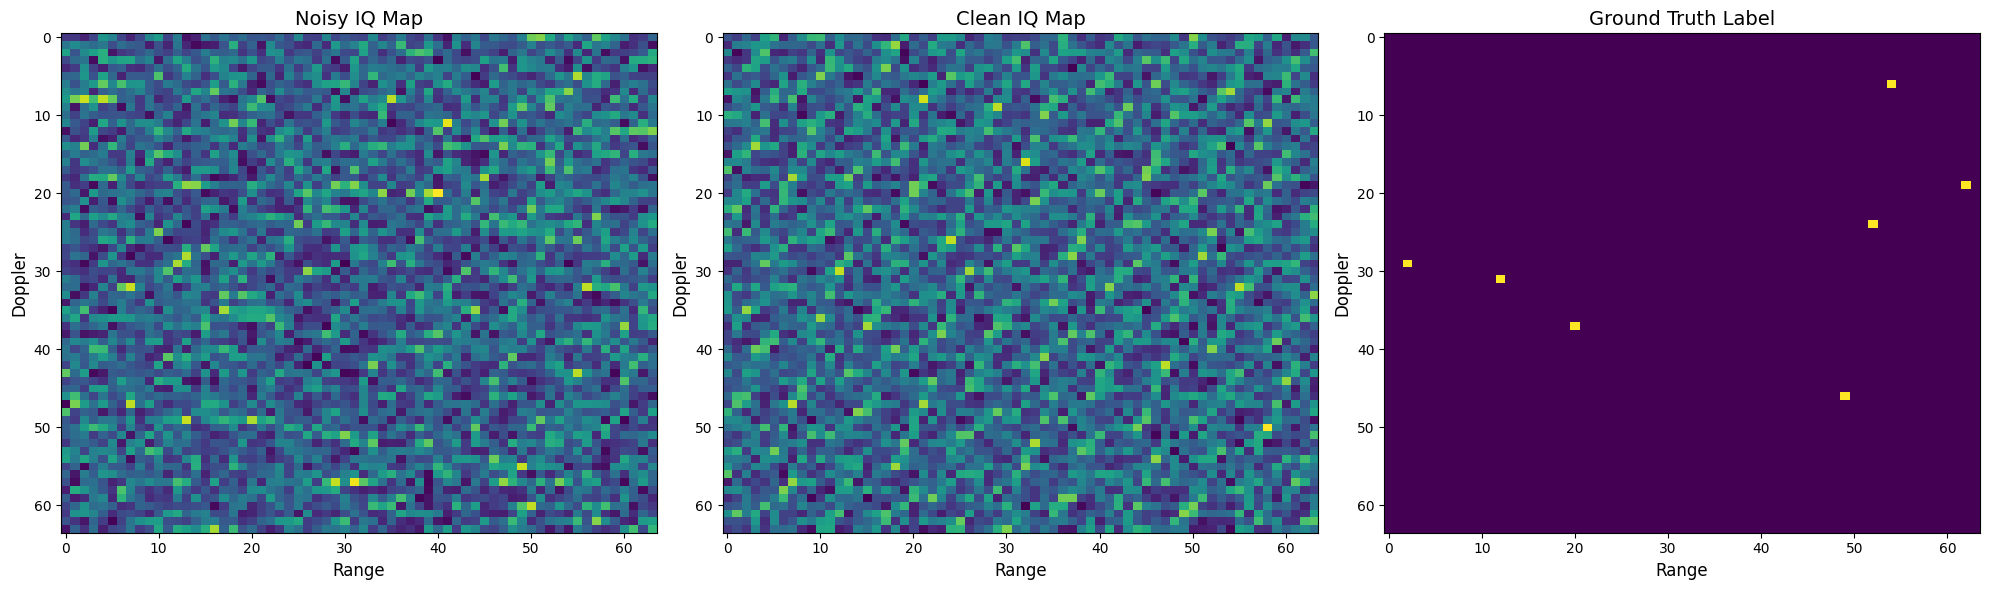

In [6]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True, scnr=-10)
visualize_sample(train_dataset_with_targets, sample_index=1)

tensor(9.5861)


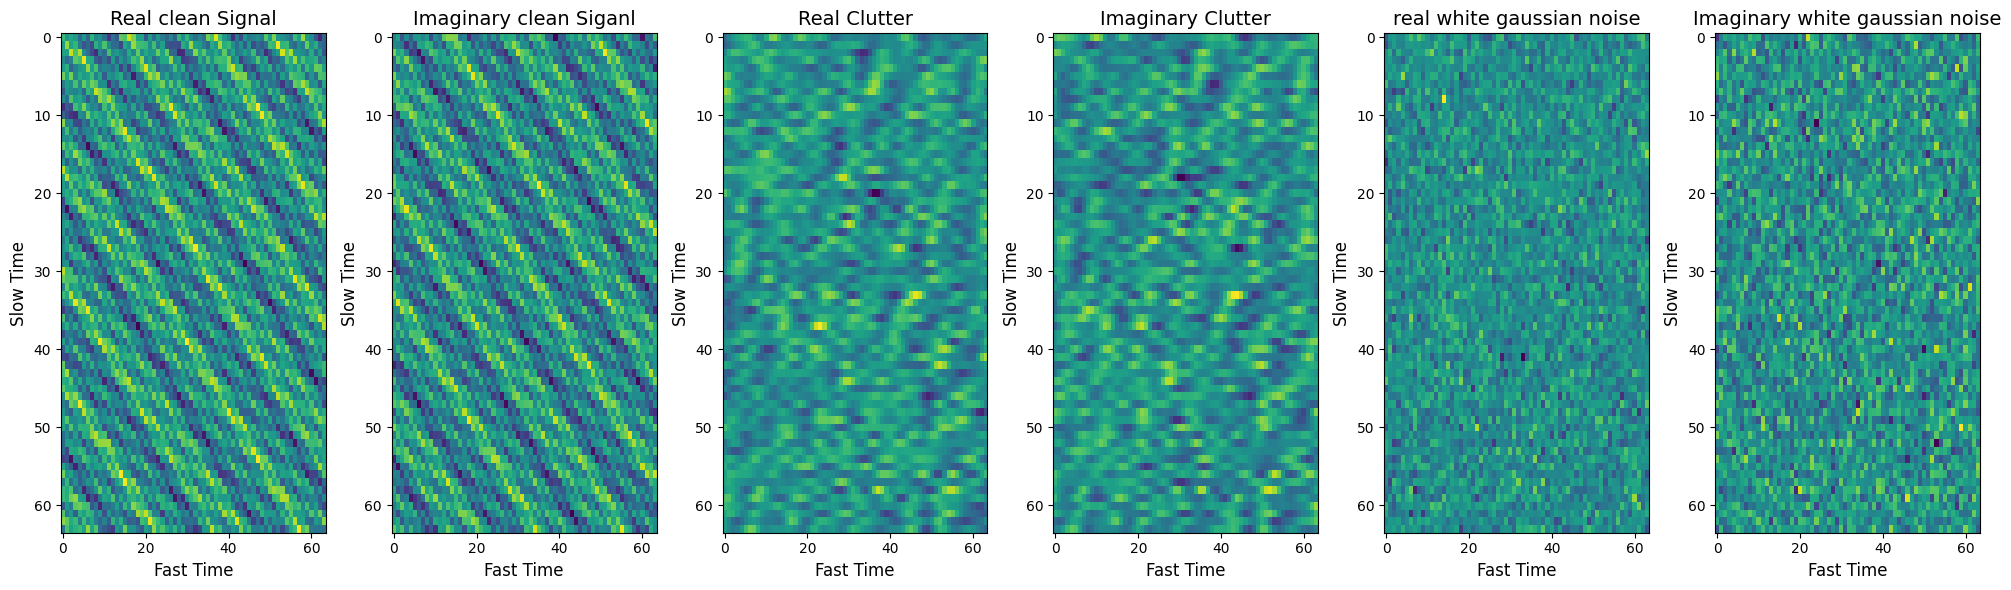

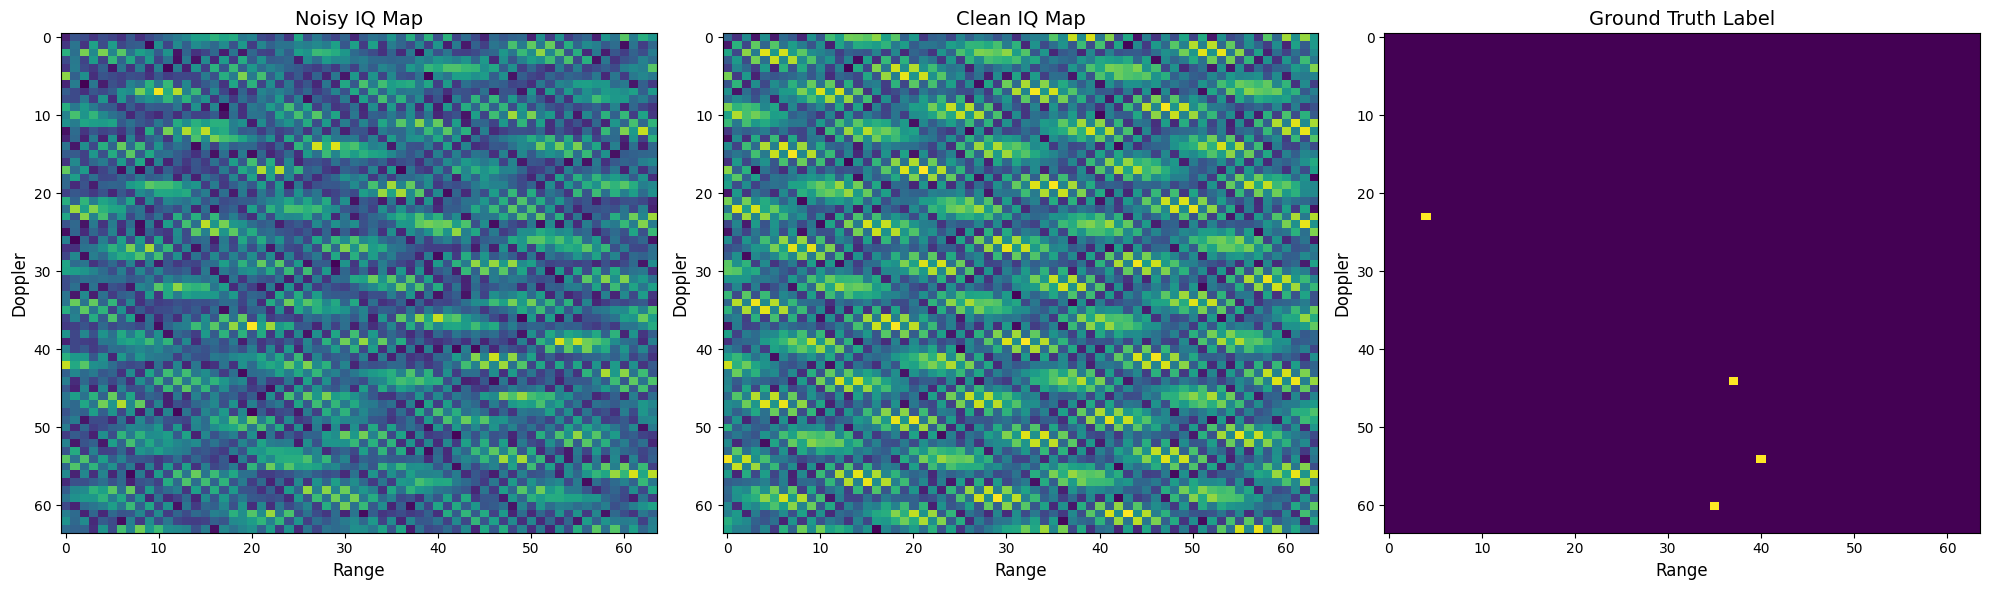

In [7]:
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=4, random_n_targets=False, snr=20, cnr=10)
visualize_sample(train_dataset_with_targets, sample_index=1)

In [8]:
def compare_nu_scnr(nu_values, scnr_values, radar_dataset_class):

    fig, axs = plt.subplots(
        nrows=len(nu_values),
        ncols=len(scnr_values) + 1,
        figsize=(20, 10),
        sharex=False,
        sharey=False
    )

    clutter_real_dict = {nu_val: [] for nu_val in nu_values}

    for i, nu_val in enumerate(nu_values):
        for j, scnr_val in enumerate(scnr_values):

            dataset = radar_dataset_class(
                num_samples=1,
                n_targets=3,          
                random_n_targets=False,
                nu=nu_val,            
                scnr=scnr_val         
            )

            signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[0]

            rd_magnitude = torch.abs(IQ)
            rd_db = 20 * torch.log10(rd_magnitude + 1e-8)
            ax_rd = axs[i, j]
            im = ax_rd.imshow(rd_db, aspect='auto', cmap='viridis')
            ax_rd.set_title(f"nu={nu_val}, SCNR={scnr_val} dB", fontsize=9)
            plt.colorbar(im, ax=ax_rd)

        ax_hist = axs[i, -1]

        num_clutter_samples = 50
        real_values = []

        for _ in range(num_clutter_samples):
            dataset_clutter = radar_dataset_class(
                num_samples=1,
                n_targets=0,  
                random_n_targets=False,
                nu=nu_val
            )
            _, C_sample, W_sample, _,_,_ = dataset_clutter.gen_frame_and_labels()
            real_part = torch.real(C_sample).view(-1).cpu().numpy()
            real_values.extend(real_part)

        ax_hist.hist(real_values, bins=50, density=True, alpha=0.7, color='gray')
        ax_hist.set_title(f"Real(Clutter) Dist\n(nu={nu_val})", fontsize=9)
        ax_hist.set_xlabel("Amplitude (Real Part)")
        ax_hist.set_ylabel("PDF")

        clutter_real_dict[nu_val].extend(real_values)

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # 2) Now plot a SECOND figure comparing all nu's at once
    # -----------------------------------------------------
    plt.figure(figsize=(8, 6))

    all_vals = []
    for nu_val in nu_values:
        all_vals.extend(clutter_real_dict[nu_val])
    min_val = min(all_vals)
    max_val = max(all_vals)
    bins = np.linspace(min_val, max_val, 100)

    for nu_val in nu_values:
        arr = clutter_real_dict[nu_val]
        plt.hist(arr, bins=bins, alpha=0.5, density=True, label=f"nu={nu_val}")

    plt.yscale('log')
    plt.xlabel("Real(Clutter) amplitude")
    plt.ylabel("PDF (log scale)")
    plt.title("Comparison of Clutter Real-Part Distributions for Different nu")
    plt.legend()
    plt.show()


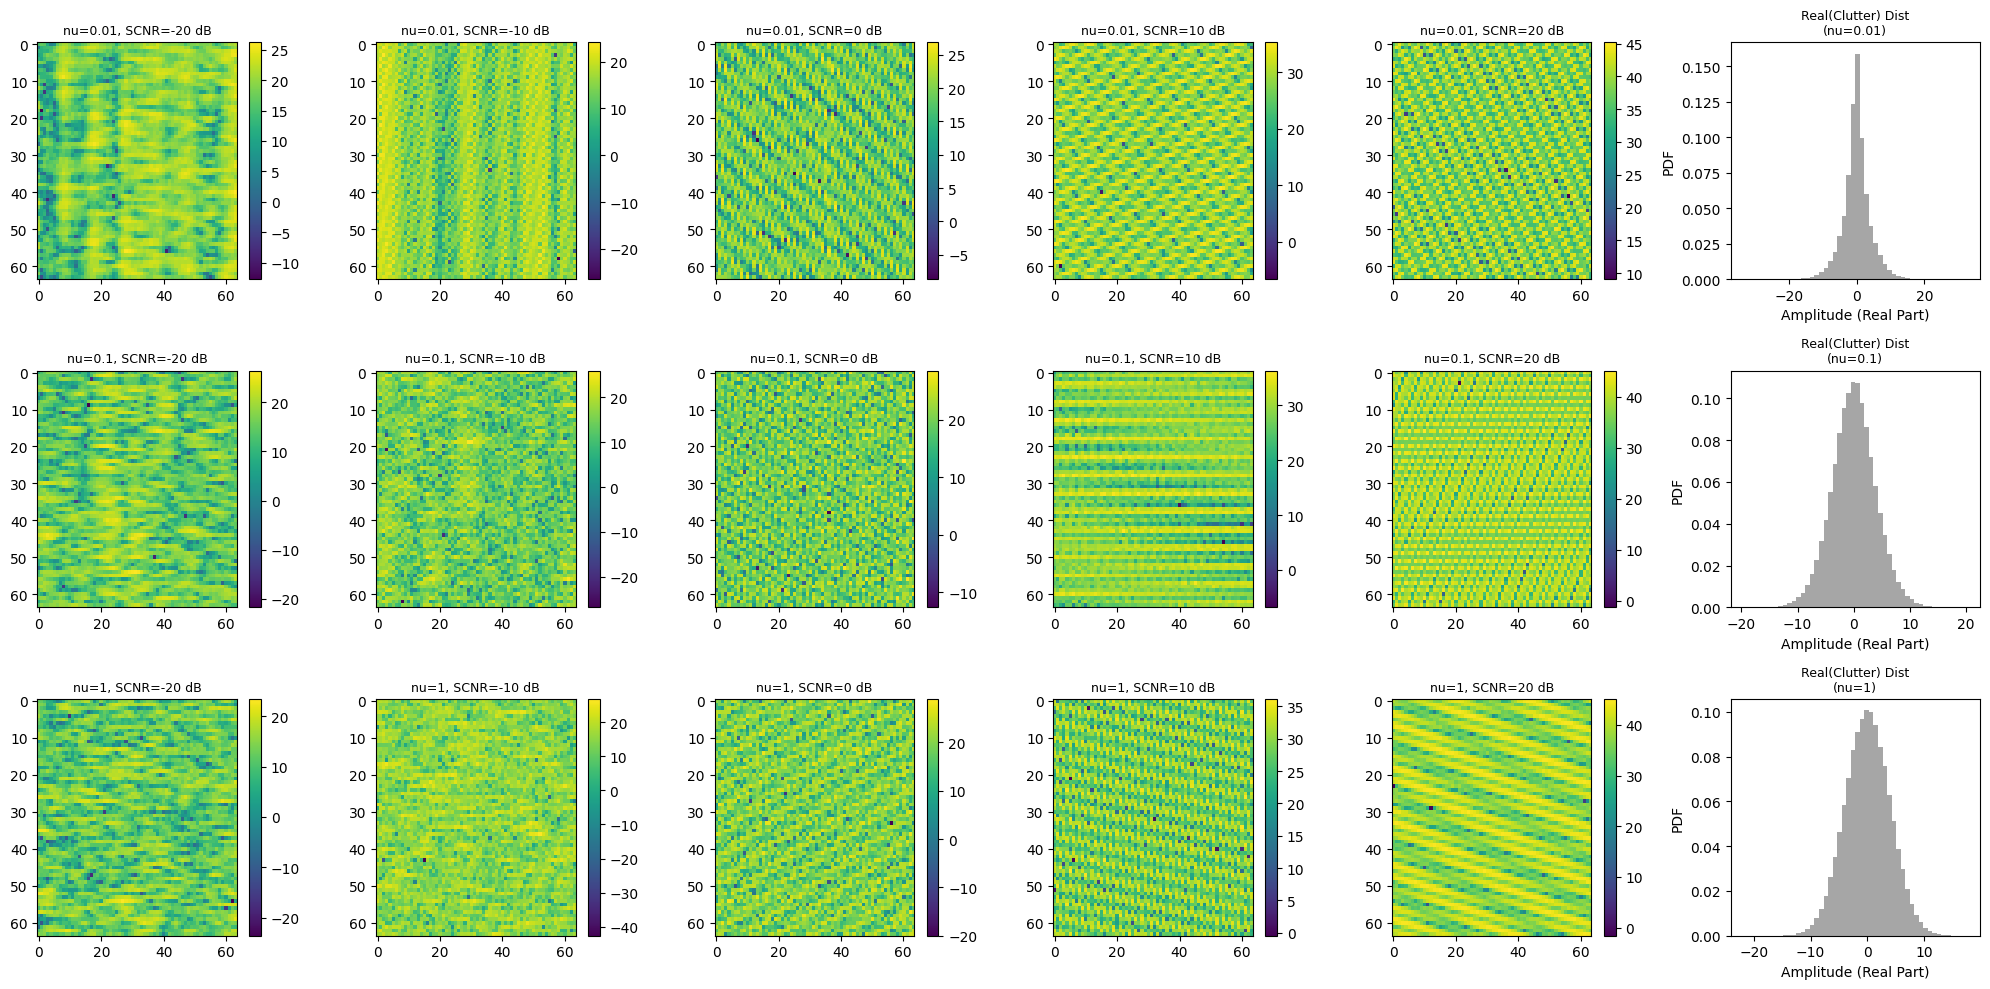

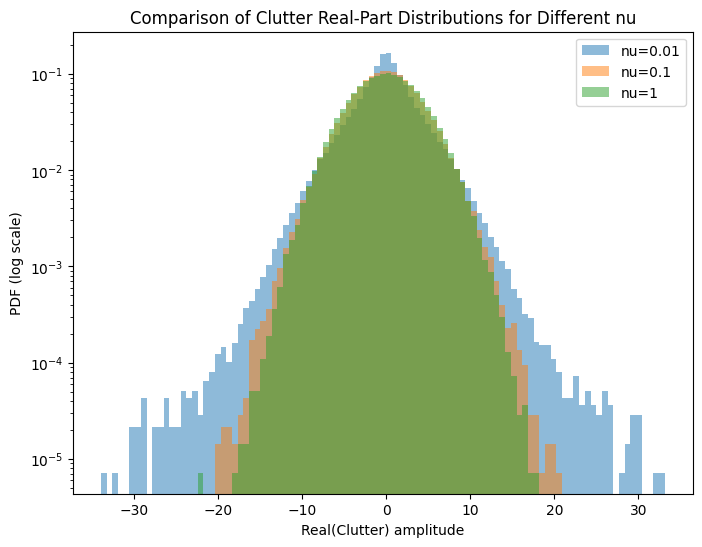

In [9]:
compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset)

## CFAR functions

In [10]:
def ca_cfar_2d(signal, num_train, num_guard, Pfa):
    """
    Standard CA–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Scaling factor for exponential noise
    alpha = num_training_cells * (Pfa**(-1/num_training_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            noise_level = np.mean(training_cells)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map

def tm_cfar_2d(signal, num_train, num_guard, trim_ratio, Pfa):
    """
    TM–CFAR on a 2D signal.
    """
    rows, cols = signal.shape
    detection_map = np.zeros_like(signal)
    
    win_size = 2 * (num_train + num_guard) + 1
    guard_size = 2 * num_guard + 1
    num_training_cells = win_size**2 - guard_size**2
    
    # Number of cells to trim from each end
    trim_cells = int(trim_ratio * num_training_cells)
    effective_cells = num_training_cells - 2 * trim_cells
    if effective_cells <= 0:
        effective_cells = num_training_cells  # fallback
    alpha = effective_cells * (Pfa**(-1/effective_cells) - 1)
    
    pad = num_train + num_guard
    padded_signal = np.pad(signal, pad, mode='constant', constant_values=0)
    
    for i in range(pad, pad + rows):
        for j in range(pad, pad + cols):
            window = padded_signal[i - pad:i + pad + 1, j - pad:j + pad + 1]
            start = num_train
            end = num_train + 2 * num_guard + 1
            training_cells = np.concatenate((window[:start, :].ravel(),
                                             window[end:, :].ravel(),
                                             window[start:end, :start].ravel(),
                                             window[start:end, end:].ravel()))
            sorted_cells = np.sort(training_cells)
            if 2 * trim_cells < num_training_cells:
                trimmed = sorted_cells[trim_cells: num_training_cells - trim_cells]
            else:
                trimmed = sorted_cells
            noise_level = np.mean(trimmed)
            threshold = alpha * noise_level
            if signal[i - pad, j - pad] > threshold:
                detection_map[i - pad, j - pad] = 1
    return detection_map


In [11]:
def simulate_cfar_performance(cfar_func, specified_Pfa, nu_val, num_trials=100,
                              n_targets=3, random_n_targets=False, **cfar_kwargs):
    """
    For a given CFAR function, specified false–alarm parameter, and clutter nu,
    simulate num_trials frames and compute the average probability of detection (Pd)
    and measured probability of false alarm (Pfa_meas).
    """
    dataset = RadarDataset(num_samples=num_trials, n_targets=n_targets,
                           random_n_targets=random_n_targets, nu=nu_val)
    total_true_detections = 0
    total_targets = 0
    total_false_alarms = 0
    total_non_target_cells = 0
    for i in range(num_trials):
        _, _, _, _, RD_map, rd_label = dataset[i]
        RD_mag = torch.abs(RD_map).detach().numpy()
        detection_map = cfar_func(RD_mag, **cfar_kwargs, Pfa=specified_Pfa)
        gt = rd_label.detach().numpy()
        true_detections = np.sum((detection_map == 1) & (gt == 1))
        false_alarms = np.sum((detection_map == 1) & (gt == 0))
        total_targets += np.sum(gt)
        total_true_detections += true_detections
        total_false_alarms += false_alarms
        total_non_target_cells += (gt.size - np.sum(gt))
    pd_rate = total_true_detections / total_targets if total_targets > 0 else 0
    measured_pfa = total_false_alarms / total_non_target_cells if total_non_target_cells > 0 else 0
    return pd_rate, measured_pfa

## DAFC

In [12]:
class RadarPreprocessing(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        Preprocessing module as described in Section III.B

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()
        self.detection_type = detection_type

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch, N, K, 2) - real and imaginary parts stacked in last dimension
        # Step 1: Reshape input based on detection type
        if self.detection_type == "range":
            X_0 = X.transpose(1, 2)  # (batch, K, N)
        else:  # doppler
            X_0 = X  # (batch, N, K)
        # Step 2: Center features over rows
        X_mean = torch.mean(X_0, dim=1, keepdim=True)
        X_1 = X_0 - X_mean
        # Step 3: Concatenate real and imaginary terms
        if torch.is_complex(X):

            Z_0 = torch.cat([X_1.real, X_1.imag], dim=-1)  # (batch, K/N, 2*N/K)
        else:
            Z_0 = torch.cat([X_1, torch.zeros_like(X_1)], dim=-1)
        return Z_0

In [13]:
class DAFCBlock(nn.Module):
    def __init__(self, H: int, W: int, H_out: int, W_out: int):
        """
        Dimensional-Alternating Fully Connected Block

        Args:
            H: Input height
            W: Input width
            H_out: Output height
            W_out: Output width
        """
        super().__init__()

        # Row mapping layer (F transform)
        self.row_fc = nn.Linear(W, W_out)

        # Column mapping layer (G transform)
        self.col_fc = nn.Linear(H, H_out)

        # Activation functions
        self.hr = nn.Tanh()
        self.hc = nn.Tanh()

    def forward(self, Z_in: torch.Tensor) -> torch.Tensor:
        Z_in = Z_in.float()
        batch_size = Z_in.size(0)
        H = Z_in.size(1)

        # Step 1: FC transform of each row
        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_in.reshape(-1, Z_in.size(-1))  # (batch*H, W)

        Z_r = self.hr(self.row_fc(Z_reshaped))  # (batch*H, W_out)

        # Reshaping back to normal after applying nn.Linear
        Z_r = Z_r.reshape(batch_size, H, -1)  # (batch, H, W_out)

        # Step 2: FC transform of each column
        Z_r = Z_r.transpose(1, 2)  # (batch, W_out, H)
        Z_r = Z_r.contiguous()  # Make memory contiguous after transpose

        # Reshaping is necessary to apply nn.Linear
        Z_reshaped = Z_r.reshape(-1, Z_r.size(-1))  # (batch*W_out, H)

        Z_out = self.hc(self.col_fc(Z_reshaped))  # (batch*W_out, H_out)

        # Reshaping back to normal after applying nn.Linear
        Z_out = Z_out.reshape(batch_size, -1, Z_out.size(-1))  # (batch, W_out, H_out)

        Z_out = Z_out.transpose(1, 2)  # (batch, H_out, W_out)

        return Z_out


class DAFCRadarNet(nn.Module):
    def __init__(self, detection_type: str = "range"):
        """
        DAFC-based Radar Detection Network

        Args:
            detection_type: Either "range" or "doppler"
        """
        super().__init__()

        # Parameters from Table I
        
        
        if detection_type == "range":
            self.input_dim = (64, 128)  # (K, 2*N)
        else:  # doppler
            self.input_dim = (64, 128)  # (N, 2*K)
    
        # Preprocessing
        self.preprocess = RadarPreprocessing(detection_type)

        # DAFC blocks (dimensions from Table I)
        self.dafc1 = DAFCBlock(self.input_dim[0], self.input_dim[1], 128, 1024)
        self.dafc2 = DAFCBlock(128, 1024, 16, 256)
        self.dafc3 = DAFCBlock(16, 256, 4, 128)

        # Final FC layer
        fc_input_size = 4 * 128
        self.fc = nn.Linear(fc_input_size, 64)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Preprocessing
        Z_0 = self.preprocess(X)
        # DAFC blocks
        Z_1 = self.dafc1(Z_0)
        Z_2 = self.dafc2(Z_1)
        Z_3 = self.dafc3(Z_2)

        # Flatten and final FC layer
        Z_flat = Z_3.reshape(Z_3.size(0), -1)
        y = self.sigmoid(self.fc(Z_flat))

        return y
    


In [14]:
class CBBCE(nn.Module):
    def __init__(self, ratio: float, beta: float = 0.99):
        """
        Class-Balanced Binary Cross Entropy Loss

        Args:
            ratio: Ratio of positive samples in dataset
            (number of targets in the dataset / number of bins in the dataset)
            beta: Beta parameter for class balancing
        """
        super().__init__()
        self.weight1 = (1 - beta) / (1 - beta ** ratio)
        print("w1: ", self.weight1)

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            y_pred: Predicted values [batch, dim] (after sigmoid)
            y_true: True values [batch, dim]
        """
        _nll2 = F.binary_cross_entropy(y_pred, y_true, reduction='none')
        # Find indices where y_true >= 0.9999
        ind1 = (y_true >= 0.9999).nonzero(as_tuple=False)  # Shape: [N, 2]

        # Gather the loss values at these indices
        _nll_subset = self.weight1 * _nll2[ind1[:, 0], ind1[:, 1]]

        # Update the original loss tensor using scatter_
        _nll2 = _nll2.index_put_((ind1[:, 0], ind1[:, 1]), _nll_subset)

        # Return the mean of the updated loss tensor
        loss = torch.mean(_nll2)
        return loss


In [15]:
def calculate_ratio(train_loader, detection_type):
    """Calculate ratio of positive samples in dataset from 2D labels"""
    n1 = 0  # target samples
    n_total = len(train_loader.dataset)
    n_total *= 32 if detection_type == 'range' else 63
    #for _, rd_label in train_loader:
    for _, _, _, _, rd_label,_ in train_loader:
    
        # Get 1D labels by summing across appropriate dimension
        label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()
        # Count bins with targets
        n1 += torch.sum(label >= 0.9999)
    ratio = n1.item() / n_total
    print("ratio:", ratio, ", n1:", n1.item(), ", n_total:", n_total)
    return ratio


In [16]:
def plot_training_history(history: dict, detection_type: str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{detection_type} Detector Training History", fontsize=16, fontweight='bold')

    # Plot Loss
    ax1.plot(history["train_loss"], label="Training Loss", color="steelblue", linewidth=1)
    ax1.plot(history["val_loss"], label="Validation Loss", color="firebrick", linewidth=1)
    ax1.set_title("Loss per Epoch", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history["train_accuracy"], label="Training Accuracy", color="darkgreen", linewidth=1)
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="darkorange", linewidth=1)
    ax2.set_title("Accuracy per Epoch", fontsize=14)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.savefig(f"{detection_type}_IQ_training_history.png", dpi=300)
    plt.close()


In [17]:
def train_model(model, criterion, train_loader, val_loader, detection_type, epochs=300, learning_rate=1e-3,
                weight_decay=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.905, patience=5)
    print(f"Last computed LR: {scheduler.get_last_lr()[0]}")

    # Training history
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    # Early stopping setup
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    epoch_pbar = tqdm(range(epochs), desc="Training Progress")

    for epoch in epoch_pbar:
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for _, _, _, X, rd_label, _ in train_loader:
            X = X.to(device)
            rd_label = rd_label.to(device)

            # Preprocess input and get 1D label
            label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, label)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_correct += (predictions == label).float().sum().item()
            train_total += label.numel()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for _, _, _, X, rd_label, _  in val_loader:
                X = X.to(device)
                rd_label = rd_label.to(device)

                # Preprocess input and get 1D label
                label = (rd_label.sum(dim=-1 if detection_type == "range" else -2) >= 1).float()

                outputs = model(X)
                loss = criterion(outputs, label)

                val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == label).float().sum().item()
                val_total += label.numel()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total

        # Update history
        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)
        history["train_accuracy"].append(epoch_train_acc)
        history["val_accuracy"].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break

        # Print epoch results every 10 epochs
        if epoch % 10 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
            print(f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    torch.save(model.state_dict(), f"{detection_type}_64_IQ_model.pt")

    return history


## Train DAFC

In [18]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0, random_n_targets=False)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0, random_n_targets=False)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

In [19]:
print("\nTraining IQ Range Detector:")
detection_type = "range"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
range_model = DAFCRadarNet(detection_type)
range_history = train_model(range_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(range_history, "Range")
detection_type = "doppler"
ratio = calculate_ratio(train_loader, detection_type)
criterion = CBBCE(ratio)
print("\nTraining IQ Doppler Detector:")
doppler_model = DAFCRadarNet(detection_type)
doppler_history = train_model(doppler_model, criterion, train_loader, val_loader, detection_type)
plot_training_history(doppler_history, "Doppler")


Training IQ Range Detector:
ratio: 0.0680908203125 , n1: 44624 , n_total: 655360
w1:  14.617713710872605
Last computed LR: 0.001


Training Progress:   0%|          | 1/300 [00:10<52:31, 10.54s/it]


Epoch 1/300
Train Loss: 0.8736 | Val Loss: 0.7052
Train Acc: 0.9119 | Val Acc: 0.8269


Training Progress:   4%|▎         | 11/300 [01:55<50:48, 10.55s/it]


Epoch 11/300
Train Loss: 0.6504 | Val Loss: 0.6549
Train Acc: 0.7220 | Val Acc: 0.7150


Training Progress:   7%|▋         | 21/300 [03:41<49:00, 10.54s/it]


Epoch 21/300
Train Loss: 0.6480 | Val Loss: 0.6489
Train Acc: 0.7288 | Val Acc: 0.7403


Training Progress:  10%|█         | 31/300 [05:26<47:12, 10.53s/it]


Epoch 31/300
Train Loss: 0.5892 | Val Loss: 0.5807
Train Acc: 0.7570 | Val Acc: 0.7558


Training Progress:  14%|█▎        | 41/300 [07:11<45:25, 10.52s/it]


Epoch 41/300
Train Loss: 0.4381 | Val Loss: 0.4225
Train Acc: 0.8407 | Val Acc: 0.8435


Training Progress:  17%|█▋        | 51/300 [08:57<43:44, 10.54s/it]


Epoch 51/300
Train Loss: 0.3165 | Val Loss: 0.3109
Train Acc: 0.8987 | Val Acc: 0.9018


Training Progress:  20%|██        | 61/300 [10:42<41:53, 10.52s/it]


Epoch 61/300
Train Loss: 0.2457 | Val Loss: 0.2322
Train Acc: 0.9280 | Val Acc: 0.9295


Training Progress:  24%|██▎       | 71/300 [12:27<40:10, 10.53s/it]


Epoch 71/300
Train Loss: 0.1986 | Val Loss: 0.2006
Train Acc: 0.9463 | Val Acc: 0.9444


Training Progress:  27%|██▋       | 81/300 [14:12<38:23, 10.52s/it]


Epoch 81/300
Train Loss: 0.1770 | Val Loss: 0.1766
Train Acc: 0.9538 | Val Acc: 0.9522


Training Progress:  30%|███       | 91/300 [15:58<36:39, 10.53s/it]


Epoch 91/300
Train Loss: 0.1683 | Val Loss: 0.1653
Train Acc: 0.9569 | Val Acc: 0.9556


Training Progress:  34%|███▎      | 101/300 [17:43<35:03, 10.57s/it]


Epoch 101/300
Train Loss: 0.1555 | Val Loss: 0.1537
Train Acc: 0.9605 | Val Acc: 0.9604


Training Progress:  37%|███▋      | 111/300 [19:28<33:04, 10.50s/it]


Epoch 111/300
Train Loss: 0.1505 | Val Loss: 0.1547
Train Acc: 0.9629 | Val Acc: 0.9613


Training Progress:  40%|████      | 121/300 [21:13<31:20, 10.51s/it]


Epoch 121/300
Train Loss: 0.1399 | Val Loss: 0.1372
Train Acc: 0.9660 | Val Acc: 0.9657


Training Progress:  44%|████▎     | 131/300 [22:58<29:37, 10.52s/it]


Epoch 131/300
Train Loss: 0.1338 | Val Loss: 0.1275
Train Acc: 0.9678 | Val Acc: 0.9686


Training Progress:  47%|████▋     | 141/300 [24:44<27:54, 10.53s/it]


Epoch 141/300
Train Loss: 0.1304 | Val Loss: 0.1313
Train Acc: 0.9692 | Val Acc: 0.9674


Training Progress:  50%|█████     | 151/300 [26:29<26:07, 10.52s/it]


Epoch 151/300
Train Loss: 0.1266 | Val Loss: 0.1285
Train Acc: 0.9702 | Val Acc: 0.9692


Training Progress:  54%|█████▎    | 161/300 [28:15<24:23, 10.53s/it]


Epoch 161/300
Train Loss: 0.1246 | Val Loss: 0.1229
Train Acc: 0.9709 | Val Acc: 0.9714


Training Progress:  57%|█████▋    | 171/300 [30:00<22:37, 10.53s/it]


Epoch 171/300
Train Loss: 0.1229 | Val Loss: 0.1197
Train Acc: 0.9713 | Val Acc: 0.9729


Training Progress:  60%|██████    | 181/300 [31:45<20:51, 10.52s/it]


Epoch 181/300
Train Loss: 0.1235 | Val Loss: 0.1233
Train Acc: 0.9712 | Val Acc: 0.9729


Training Progress:  64%|██████▎   | 191/300 [33:30<19:07, 10.52s/it]


Epoch 191/300
Train Loss: 0.1166 | Val Loss: 0.1202
Train Acc: 0.9731 | Val Acc: 0.9711


Training Progress:  67%|██████▋   | 201/300 [35:16<17:20, 10.51s/it]


Epoch 201/300
Train Loss: 0.1161 | Val Loss: 0.1165
Train Acc: 0.9735 | Val Acc: 0.9726


Training Progress:  70%|███████   | 211/300 [37:01<15:34, 10.50s/it]


Epoch 211/300
Train Loss: 0.1123 | Val Loss: 0.1128
Train Acc: 0.9744 | Val Acc: 0.9736


Training Progress:  74%|███████▎  | 221/300 [38:46<13:51, 10.52s/it]


Epoch 221/300
Train Loss: 0.1133 | Val Loss: 0.1141
Train Acc: 0.9746 | Val Acc: 0.9743


Training Progress:  77%|███████▋  | 231/300 [40:31<12:04, 10.50s/it]


Epoch 231/300
Train Loss: 0.1123 | Val Loss: 0.1130
Train Acc: 0.9746 | Val Acc: 0.9742


Training Progress:  80%|████████  | 241/300 [42:16<10:21, 10.53s/it]


Epoch 241/300
Train Loss: 0.1080 | Val Loss: 0.1062
Train Acc: 0.9754 | Val Acc: 0.9757


Training Progress:  84%|████████▎ | 251/300 [44:02<08:34, 10.51s/it]


Epoch 251/300
Train Loss: 0.1069 | Val Loss: 0.1047
Train Acc: 0.9757 | Val Acc: 0.9756


Training Progress:  87%|████████▋ | 261/300 [45:47<06:50, 10.51s/it]


Epoch 261/300
Train Loss: 0.1098 | Val Loss: 0.1044
Train Acc: 0.9754 | Val Acc: 0.9765


Training Progress:  90%|█████████ | 271/300 [47:32<05:04, 10.50s/it]


Epoch 271/300
Train Loss: 0.1068 | Val Loss: 0.1046
Train Acc: 0.9757 | Val Acc: 0.9759


Training Progress:  94%|█████████▎| 281/300 [49:17<03:19, 10.51s/it]


Epoch 281/300
Train Loss: 0.1047 | Val Loss: 0.1038
Train Acc: 0.9763 | Val Acc: 0.9772


Training Progress:  97%|█████████▋| 291/300 [51:03<01:34, 10.51s/it]


Epoch 291/300
Train Loss: 0.1040 | Val Loss: 0.1093
Train Acc: 0.9767 | Val Acc: 0.9759


Training Progress: 100%|██████████| 300/300 [52:37<00:00, 10.53s/it]


ratio: 0.034463355654761905 , n1: 44466 , n_total: 1290240
w1:  28.876002715148836

Training IQ Doppler Detector:
Last computed LR: 0.001


Training Progress:   0%|          | 1/300 [00:10<52:22, 10.51s/it]


Epoch 1/300
Train Loss: 1.2258 | Val Loss: 0.9654
Train Acc: 0.5410 | Val Acc: 0.6241


Training Progress:   4%|▎         | 11/300 [01:55<50:29, 10.48s/it]


Epoch 11/300
Train Loss: 0.8475 | Val Loss: 0.8317
Train Acc: 0.6451 | Val Acc: 0.6474


Training Progress:   7%|▋         | 21/300 [03:40<48:55, 10.52s/it]


Epoch 21/300
Train Loss: 0.6327 | Val Loss: 0.6199
Train Acc: 0.7754 | Val Acc: 0.7792


Training Progress:  10%|█         | 31/300 [05:25<47:02, 10.49s/it]


Epoch 31/300
Train Loss: 0.4575 | Val Loss: 0.4562
Train Acc: 0.8582 | Val Acc: 0.8573


Training Progress:  14%|█▎        | 41/300 [07:10<45:17, 10.49s/it]


Epoch 41/300
Train Loss: 0.3894 | Val Loss: 0.3834
Train Acc: 0.8850 | Val Acc: 0.8791


Training Progress:  17%|█▋        | 51/300 [08:55<43:40, 10.52s/it]


Epoch 51/300
Train Loss: 0.3302 | Val Loss: 0.3302
Train Acc: 0.9088 | Val Acc: 0.9080


Training Progress:  20%|██        | 61/300 [10:41<41:51, 10.51s/it]


Epoch 61/300
Train Loss: 0.2927 | Val Loss: 0.2848
Train Acc: 0.9214 | Val Acc: 0.9270


Training Progress:  24%|██▎       | 71/300 [12:25<40:02, 10.49s/it]


Epoch 71/300
Train Loss: 0.2786 | Val Loss: 0.2700
Train Acc: 0.9269 | Val Acc: 0.9280


Training Progress:  27%|██▋       | 81/300 [14:11<38:20, 10.51s/it]


Epoch 81/300
Train Loss: 0.2619 | Val Loss: 0.2603
Train Acc: 0.9316 | Val Acc: 0.9337


Training Progress:  30%|███       | 91/300 [15:56<36:48, 10.57s/it]


Epoch 91/300
Train Loss: 0.2492 | Val Loss: 0.2523
Train Acc: 0.9352 | Val Acc: 0.9324


Training Progress:  34%|███▎      | 101/300 [17:41<34:55, 10.53s/it]


Epoch 101/300
Train Loss: 0.2454 | Val Loss: 0.2462
Train Acc: 0.9368 | Val Acc: 0.9314


Training Progress:  37%|███▋      | 111/300 [19:26<32:52, 10.44s/it]


Epoch 111/300
Train Loss: 0.2341 | Val Loss: 0.2414
Train Acc: 0.9400 | Val Acc: 0.9420


Training Progress:  40%|████      | 121/300 [21:10<31:04, 10.42s/it]


Epoch 121/300
Train Loss: 0.2257 | Val Loss: 0.2249
Train Acc: 0.9428 | Val Acc: 0.9406


Training Progress:  44%|████▎     | 131/300 [22:54<29:17, 10.40s/it]


Epoch 131/300
Train Loss: 0.2270 | Val Loss: 0.2289
Train Acc: 0.9430 | Val Acc: 0.9411


Training Progress:  47%|████▋     | 141/300 [24:38<27:38, 10.43s/it]


Epoch 141/300
Train Loss: 0.2259 | Val Loss: 0.2208
Train Acc: 0.9437 | Val Acc: 0.9402


Training Progress:  50%|█████     | 151/300 [26:22<25:51, 10.42s/it]


Epoch 151/300
Train Loss: 0.2218 | Val Loss: 0.2193
Train Acc: 0.9446 | Val Acc: 0.9464


Training Progress:  54%|█████▎    | 161/300 [28:06<24:07, 10.42s/it]


Epoch 161/300
Train Loss: 0.2174 | Val Loss: 0.2224
Train Acc: 0.9458 | Val Acc: 0.9445


Training Progress:  57%|█████▋    | 171/300 [29:51<22:24, 10.42s/it]


Epoch 171/300
Train Loss: 0.2110 | Val Loss: 0.2154
Train Acc: 0.9473 | Val Acc: 0.9450


Training Progress:  60%|██████    | 181/300 [31:35<20:39, 10.41s/it]


Epoch 181/300
Train Loss: 0.2104 | Val Loss: 0.2100
Train Acc: 0.9478 | Val Acc: 0.9491


Training Progress:  64%|██████▎   | 191/300 [33:19<18:53, 10.39s/it]


Epoch 191/300
Train Loss: 0.2042 | Val Loss: 0.2091
Train Acc: 0.9493 | Val Acc: 0.9501


Training Progress:  67%|██████▋   | 201/300 [35:03<17:08, 10.39s/it]


Epoch 201/300
Train Loss: 0.2019 | Val Loss: 0.1973
Train Acc: 0.9501 | Val Acc: 0.9484


Training Progress:  70%|███████   | 211/300 [36:47<15:25, 10.40s/it]


Epoch 211/300
Train Loss: 0.2014 | Val Loss: 0.2012
Train Acc: 0.9503 | Val Acc: 0.9494


Training Progress:  74%|███████▎  | 221/300 [38:31<13:43, 10.42s/it]


Epoch 221/300
Train Loss: 0.1989 | Val Loss: 0.1938
Train Acc: 0.9508 | Val Acc: 0.9529


Training Progress:  77%|███████▋  | 231/300 [40:15<11:57, 10.39s/it]


Epoch 231/300
Train Loss: 0.1981 | Val Loss: 0.1955
Train Acc: 0.9517 | Val Acc: 0.9527


Training Progress:  80%|████████  | 241/300 [41:59<10:21, 10.53s/it]


Epoch 241/300
Train Loss: 0.1951 | Val Loss: 0.1977
Train Acc: 0.9523 | Val Acc: 0.9537


Training Progress:  84%|████████▎ | 251/300 [43:44<08:33, 10.48s/it]


Epoch 251/300
Train Loss: 0.1936 | Val Loss: 0.1900
Train Acc: 0.9529 | Val Acc: 0.9526


Training Progress:  87%|████████▋ | 261/300 [45:29<06:49, 10.50s/it]


Epoch 261/300
Train Loss: 0.1937 | Val Loss: 0.1962
Train Acc: 0.9529 | Val Acc: 0.9535


Training Progress:  90%|█████████ | 271/300 [47:15<05:04, 10.52s/it]


Epoch 271/300
Train Loss: 0.1921 | Val Loss: 0.1888
Train Acc: 0.9538 | Val Acc: 0.9536


Training Progress:  94%|█████████▎| 281/300 [48:59<03:19, 10.51s/it]


Epoch 281/300
Train Loss: 0.1886 | Val Loss: 0.1955
Train Acc: 0.9542 | Val Acc: 0.9554


Training Progress:  97%|█████████▋| 291/300 [50:45<01:34, 10.51s/it]


Epoch 291/300
Train Loss: 0.1884 | Val Loss: 0.1904
Train Acc: 0.9545 | Val Acc: 0.9555


Training Progress:  99%|█████████▉| 297/300 [51:58<00:31, 10.50s/it]


Early stopping triggered after 298 epochs


In [20]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)


In [21]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)

        # reshape to (B, num_heads, C//num_heads, H*W)
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) / math.sqrt(C // self.num_heads)
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return x + out


In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)


In [23]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

In [24]:
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            diffY = skip.size()[2] - x.size()[2]
            diffX = skip.size()[3] - x.size()[3]
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

In [25]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, time_emb_dim=32):
        """
        in_channels=2 because we concatenate:
            - x_t: the noised (or current reverse process) image (1 channel)
            - cond: the conditioning (noisy observed) image (1 channel)
        """
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU()
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Bottleneck with attention
        self.bot = DoubleConv(256, 512)
        self.attn = SelfAttention2d(512)
        # Decoder with time embedding injections
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Time embeddings injected at various stages:
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B,2,H,W) where channels are [x_t, cond]
        t: (B,) normalized timesteps
        """
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)

        x1 = self.inc(x)                 # (B,64,H,W)
        x2_skip, x2 = self.down1(x1)     # (B,128,...)
        x3_skip, x3 = self.down2(x2)     # (B,256,...)
        x4_skip, x4 = self.down3(x3)     # (B,256,...)
        
        x_bot = self.bot(x4)
        x_bot = self.attn(x_bot)
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        x = self.up1(x_bot, x4_skip)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)
        output = self.outc(x)
        return output

In [26]:
class ConditionalDiffusion(nn.Module):
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model  # ConditionalUNet
        self.T = T
        self.register_buffer("betas", torch.linspace(beta_start, beta_end, T))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        """
        Forward diffusion: add noise to x0 at timestep t.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

    def p_losses(self, x0, t, cond):
        """
        Loss: train network to predict the noise added.
        x0: clean image (B,1,H,W)
        cond: conditioning (observed noisy image) (B,1,H,W)
        """
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        
        # Concatenate along channel dimension: [x_noisy, cond]
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, t, cond):
        """
        One reverse diffusion step (from x_t to x_{t-1}).
        """
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t], device=x.device).float() / self.T).repeat(x.shape[0])

        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1 - alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        
        noise = torch.randn_like(x) if t > 0 else 0
        return mean + torch.sqrt(betas_t) * noise

    @torch.no_grad()
    def sample(self, cond, shape):
        """
        Generate a denoised image conditioned on cond.
        cond: (B,1,H,W) the observed noisy image.
        shape: desired shape of x (B,1,H,W)
        """
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x
